## Plot metric models
The idea is to perform a radar plot on each of the models, considering some the following metrics:
   - Number of reactions
   - Enzymatic reactions (reactions with associated genes)
   - Memote score
   - Number of genes
   - Number of metabolites
   - Unique metabolites (issues with compartments)
   - Biomass metabolites
   - Dead ends
   - Metabolite participation (average participation of metabolites in reactions)

This notebook considers that files are organized in folders named as the different methods used, and each model with its respective organism name. Both models and memote reports (in .json format) are in the same folder.
**TO DO**
- Reconciliation metabolites different namespaces

In [1]:
import cobra
import numpy as np
import json
from cobra import Model, Reaction, Metabolite
import os
import pandas as pd
import logging
logging.getLogger("cobra").setLevel(logging.ERROR)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import seaborn as sns
sns.set_style("white")

## Funciones mapeo metabolitos

In [2]:
import re  # Asegurémonos de importar el módulo re para usarlo en las funciones
import libsbml
import csv
import pandas as pd
from fuzzywuzzy import fuzz
import json
import cobra

# Función para normalizar identificadores (IDs) con eliminación de prefijos y sufijos
def normalize_id(identifier, DB):
    """
    Normaliza un identificador eliminando caracteres especiales, convirtiéndolo a minúsculas,
    y eliminando prefijos y sufijos específicos si están presentes.
    
    Args:
        identifier (str): El identificador a normalizar.

    Returns:
        str: El identificador normalizado.
    """
    
    
    # Elimina prefijos y sufijos específicos
    prefixes = ["M_"]#, "R_"]
    #NJT
    if DB == 'bigg':
        suffixes = ["_e", "_p", "_c"] #depende de DB
    elif DB=='kegg':
        suffixes=['__extr', '__cytop', '__vacu', '__in', '__nucl', '__chlo', '__mito', '__pero', '__out']
    elif DB=='metacyc':
        suffixes=["_e", "_p", "_c", "_t","_CCO__45__OUT", "_CCO__45__IN"]#"ccopmbacneg", "ccooutccoin"
    elif DB=='modelseed':
        suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c", '_b']
        prefixes = ['m_']
    else:
        print('Database not found!')
        
        
    for prefix in prefixes:
        if identifier.startswith(prefix):
            identifier = identifier[len(prefix):]
            break
    for suffix in suffixes:
        
        if identifier.endswith(suffix):
            #print(identifier)
            #print(suffix)
            identifier = identifier[:-len(suffix)]
            break

    # Elimina caracteres especiales
    identifier = cobra.io.sbml._f_specie(identifier)
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    # Convierte a minúsculas
    identifier = identifier.lower()
    return identifier

# Función para normalizar identificadores (IDs) sin eliminación de prefijos y sufijos
def normalize_id_no_prefix_suffix(identifier):
    """
    Normaliza un identificador eliminando caracteres especiales y convirtiéndolo a minúsculas.

    Args:
        identifier (str): El identificador a normalizar.

    Returns:
        str: El identificador normalizado.
    """
    # Elimina caracteres especiales
    identifier = re.sub(r"[^a-zA-Z0-9]+", "", identifier)
    
    # Convierte a minúsculas
    identifier = identifier.lower()
    
    return identifier

def gen_df(route_sbml, db_sbml, mnx_only=False):
    #this_db is the db in which the sbml is coded
    # read SBML
    document = libsbml.readSBMLFromFile(route_sbml)
    models = document.getModel()
    # Extraer los IDs originales de las especies del modelo
    species_ids = [species.getId() for species in models.getListOfSpecies()]
    #print(species_ids)
    #reaction_ids = [reaction.getId() for reaction in models.getListOfReactions()] #future considerations
    # Normalizar los IDs de las especies
    normalized_species_ids = [normalize_id(i, db_sbml) for i in species_ids]
    #for i in range(10):
    #    print(species_ids[i])
    #    print(normalized_species_ids[i])
    #1. metanetx
    df_map = map_mnx(db_sbml, species_ids, normalized_species_ids)
    print('mapping metanetx')
    print(df_map.head())
    #2. modelseed
    if not mnx_only:
        if db_sbml!='bigg':
            print('bigg map')
            df_map = map_bigg(df_map, db_sbml)
        if db_sbml!='modelseed':
            print('mapping modelseed')
            df_map = map_modelseed(df_map, db_sbml)

        print(df_map.head())
        #add name and formula for fuzzy
        print('adding name and formula')
        df_map = add_name_formula(models, df_map, db_sbml)
        print(df_map.head())

        #3. fuzzy wuzzys
        if db_sbml!='metacyc':
            print('fuzzy meta')
            df_map = fuzzy_map_meta(df_map)
            print(df_map.head())
        if db_sbml!='kegg':
            df_map = fuzzy_map_kegg(df_map)
            print('fuzzy kegg')
            print(df_map.head())
        if db_sbml!='modelseed':
            df_map = fuzzy_map_modelseed(df_map)
            print('fuzzy ms')
            print(df_map.head())
        if db_sbml!='bigg':
            print('fuzzy bigg')
            df_map = fuzzy_map_bigg(df_map)
            print(df_map.head())
        
    df_map = df_map.fillna('')
    #assuming route is "to_plot/method/org.something"
    method = route_sbml.split('/')[2]
    org = route_sbml.split('/')[3].split('.')[0]
    df_map.to_csv(method+'_'+org+'_'+'.csv') #store mapping
    return(df_map)

def gen_mnx_db_dict(chem_xref_file, db_out):
    #NJ adapted
    #generates dict mapping from MNX to a db_out database based on file from metanetx
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'}
    db_dict = {}
    with open(chem_xref_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if  row[0].startswith(db_prefix_dict[db_out]):
                out_id = row[0][len(db_prefix_dict[db_out]):]  # Eliminar los primeros 9 caracteres ("metacycM:")
                MNX = row[1]
                if out_id.startswith('M_'):#why? I removed it 28/11
                    out_id = out_id[2:]
                db_dict[MNX] = out_id
    return db_dict

def map_mnx(this_db, species_ids, normalized_species_ids, chem_xref_file = r"./DB/chem_xref.tsv"):
    #Map ids model to mnx
    #STEP 1: metanetx
    # Ruta al archivo de referencias
    # Crear un diccionario para las conversiones de bigg
    this_db_dict = {}
    for species_id, normalized_species_id in zip(species_ids, normalized_species_ids):
        this_db_dict[species_id] = (normalized_species_id,)
    # Crear un diccionario para las conversiones de Metanetx
    db_prefix_dict = {'bigg': 'biggM:', 'metacyc': 'metacycM:', 'kegg': 'kegg.compound:', 'modelseed': 'seedM:'}
    #this_db
    metanetx_dict = {}
    
    with open(chem_xref_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if row[0].startswith(db_prefix_dict[this_db]): #especifico DB
                id_orig = row[0][len(db_prefix_dict[this_db]):]  # Eliminar los primeros 6 caracteres ("biggM:") #id_orig comes from the id of the DB
                id_norm = normalize_id_no_prefix_suffix(id_orig)
                value = row[1]
                metanetx_dict[id_orig] = (id_norm, value) #tuple instead of single value
                
    
    
    other_dbs = list(db_prefix_dict.keys())
    other_dbs.remove(this_db)
    mnx_db_dicts = dict()
    for db in other_dbs:
        mnx_db_dicts[db] = gen_mnx_db_dict(chem_xref_file, db)

    #print('mnx_db_dicts')
    #print(mnx_db_dicts)    
    # Crear un diccionario para las conversiones de metacyc
    #metacyc_dict = gen_mnx_db_dict(chem_xref_file, 'metacyc')
    #kegg_dict = gen_mnx_db_dict(chem_xref_file, 'kegg')
    #seed_dict = gen_mnx_db_dict(chem_xref_file, 'seed')

    # Convertir los diccionarios en DataFrames de pandas para bigg y Metanetx
    df_this = pd.DataFrame.from_dict(this_db_dict, orient='index', columns=['normalized_id'])
    df_this.index.name = 'original_id'

    # Crear una nueva columna llamada 'original_id' con los valores del índice
    df_this['original_id'] = df_this.index

    # Permutar las columnas y establecer 'normalized_id' como índice en df_bigg
    df_this = df_this[['normalized_id', 'original_id']].set_index('normalized_id', drop=True)
    # Convertir el diccionario metanetx_dict a un DataFrame de pandas
    df_metanetx = pd.DataFrame.from_dict(metanetx_dict, orient='index', columns=['normalized_id', 'MNX'])
    df_metanetx.index.name = 'original_id'
    print('df_metanetx')
    print(df_metanetx.head())
   
    # Crear una nueva columna llamada 'original_id' con los valores del índice y cambiar el nombre de la columna
    df_metanetx[this_db] = df_metanetx.index
    df_metanetx = df_metanetx.rename(columns={'original_id': this_db})
    
    # Permutar las columnas y establecer 'normalized_id' como índice en df_metanetx
    df_metanetx = df_metanetx[['normalized_id', 'MNX', this_db]].set_index('normalized_id', drop=True)

    # Realizar una fusión de los DataFrames de bigg y Metanetx en df_merged
    df_merged = df_this.merge(df_metanetx, how='left', left_index=True, right_index=True)
    #print('df_this.index')
    #print(df_this.index)
    #print('df_metanetx.index')
    #print(df_metanetx.index)
    
    df_no_data = df_merged.isna().all(axis=1)
    df_no_data.to_csv('no_data_rows.txt', header=False) #borrar?
    
    for db in other_dbs:
        #print(db)
        df_merged[db+'_mnx'] = df_merged['MNX'].map(mnx_db_dicts[db])
        
    # Restablecer el índice en df_merged y cambiar el nombre de la columna
    df_merged.reset_index(inplace=True)
    df_merged.rename(columns={'index': 'normalized_id'}, inplace=True)
    #print(df_merged.tail(10))
    return(df_merged)

def map_modelseed(df_merged, this_db, ruta_archivo = './DB/compounds.tsv'):

    # Definir la ruta del archivo TSV de modelseed
    ruta_archivo = './DB/compounds.tsv'

    # Definir la base de datos objetivo
    dict_obj_db = {'bigg':'BiGG', 'kegg': 'KEGG', 'metacyc':'MetaCyc'  }
    base_de_datos_objetivo = dict_obj_db[this_db]

    # Cargar el archivo TSV en un DataFrame de pandas
    df = pd.read_csv(ruta_archivo, sep='\t', header=None)

    # Crear un nuevo DataFrame para almacenar los identificadores
    df_nuevo = pd.DataFrame(columns=['Identificador', 'Modelseed_DB'])

    # Definir un patrón de búsqueda para "base_de_datos_objetivo: xxxx" con límites de palabra (\b)
    patron_busqueda = re.compile(rf'\b{base_de_datos_objetivo}: ([\w-]+)\b')

    # Iterar sobre las filas del DataFrame original y extraer los identificadores
    iden_dict = dict()
    for idx, row in df.iterrows():
        row_dict = dict()
        identificador_principal = row.iloc[0]
        for col in row[1:]:
            matches = patron_busqueda.findall(str(col))
            if matches:
                if len(matches)>1:
                    print(matches)
                identificador_encontrado = matches[0]
                #doing this with dicts instead: 
                row_dict['Identificador'] = identificador_encontrado
                row_dict['Modelseed_DB'] = identificador_principal
                iden_dict[idx] = row_dict
                # Agregar el identificador encontrado y su correspondiente 'Modelseed_DB' al DataFrame df_nuevo
                #df_nuevo = df_nuevo.append({'Identificador': identificador_encontrado, 'Modelseed_DB': identificador_principal}, ignore_index=True)
    df_nuevo = pd.DataFrame.from_dict(iden_dict, orient='index')
    # Realizar la combinación entre df_merged y df_nuevo utilizando 'Biggcyc_norm' e 'Identificador' como claves de combinación
    df_merged = df_merged.merge(df_nuevo, left_on=this_db, right_on='Identificador', how='left')

    # Eliminar la columna 'Identificador' del DataFrame resultante para limpiarlo
    df_merged.drop('Identificador', axis=1, inplace=True)
    
    return(df_merged)


def add_name_formula(models, df_merged, this_db, path_ms_db = './DB/compounds.tsv'):
    #input model in sbml
    #generate dicts with names and formulas
    #if this_db is modelseed, skip loading model and get formulas from database
    if this_db=='modelseed':
        df_ms = pd.read_csv(path_ms_db, sep='\t')
    name_dict = dict()
    formula_dict = dict()
    for met in models.getListOfSpecies():
        met_id = met.getIdAttribute()
        
        if met_id.startswith('M_'):
            met_id = met_id[2:]
        if this_db!='kegg':
            #clean compartment at the end (assuming it ends in "_c")
            #This could not be the case for other databases
            #print(met_id)
            if this_db=='modelseed':
                met_id = met_id[:-3]
            else:
                met_id = met_id[:-2]
            #print(met_id)
            
        if this_db=='modelseed':
            this_row = df_ms[df_ms['id']==met_id]
            if not this_row.empty:
                name_dict[met_id] = str(this_row['name'].iloc[0])
                formula_dict[met_id] = str(this_row['formula'].iloc[0])
            else:
                name_dict[met_id] = ''
                formula_dict[met_id] = ''
                
        else:
            name_dict[met_id] = met.getName()
             #met.getIdAttribute()
            notes = met.getNotesString()
            for n in notes.split('\n'):
                if 'FORMULA' in n:
                    formula = n.split(': ')[1].replace('</p>','')
                    formula_dict[met_id] = formula
            if not 'FORMULA' in notes:
                #print(notes)

                specie_fbc: "libsbml.FbcSpeciesPlugin" = met.getPlugin("fbc")
                if specie_fbc:
                    #charge = specie_fbc.getCharge()
                    formula = specie_fbc.getChemicalFormula() or ''
                    formula_dict[met_id] = formula
        # Agregar las columnas 'name' y 'formula' al DataFrame df_merged
    df_merged['name'] = ''
    df_merged['formula'] = ''

    # Iterar sobre cada fila del DataFrame df_merged y buscar el metabolito correspondiente en el modelo
    for index, row in df_merged.iterrows():
        #print(row[this_db])
        metabolito_id = row[this_db]#[2:]  # Obtén la cadena a partir del tercer carácter en adelante 
        #metabolito = modelo.metabolites.get_by_id(metabolito_id)

        # Obtener el nombre y la fórmula del metabolito
        if metabolito_id in name_dict.keys():
            #print('mapped name')
            nombre_metabolito = name_dict[metabolito_id]
            if metabolito_id in formula_dict.keys():
                formula_metabolito = formula_dict[metabolito_id]
            else:
                formula_metabolito = ''
        else:
            nombre_metabolito = ''
            formula_metabolito = ''

        # Agregar los valores de nombre y fórmula al DataFrame df_merged
        df_merged.at[index, 'name'] = nombre_metabolito
        df_merged.at[index, 'formula'] = formula_metabolito
        
    
    return(df_merged)
  

def map_bigg(df_merged, this_db, ruta_archivo='./DB/universal_model.json'):
    with open(ruta_archivo, 'r') as f:
        data = json.load(f)

    dict_obj_db = {'bigg':'BiGG', 'kegg': 'KEGG', 'metacyc':'MetaCyc', 'modelseed': 'modelseed' }
    base_de_datos_objetivo = dict_obj_db[this_db]
    # Crear una lista para almacenar los datos relevantes de los metabolitos
    metabolites = []
    for metabolite in data['metabolites']:
        bigg_id = metabolite['id']
        kegg_id = None
        seed_id = None
        metacyc_id = None
        mnx_id = None
        for annotation in metabolite['annotation']:
            #FALTA METACYC AQUI
            if 'kegg.compound' in annotation[1]:
                # Extraer el identificador kegg.compound de la anotación
                kegg_id = annotation[1].split('/')[-1]
            if 'seed.compound' in annotation[1]:
                # Extraer el identificador Modelseed de la anotación
                seed_id = annotation[1].split('/')[-1]
            if 'biocyc' in annotation[1]:
                # Extraer el identificador Metacyc de la anotación
                metacyc_id = annotation[1].split('/')[-1].replace('META:', '')
            if 'metanetx.chemical' in annotation[1]:
                # Extraer el identificador Metanetx de la anotación
                mnx_id = annotation[1].split('/')[-1]
            
        # Agregar los datos de metabolito a la lista
        metabolites.append({'BiGG': bigg_id, 'KEGG': kegg_id, 'modelseed': seed_id, 'MetaCyc': metacyc_id, 'Mnx': mnx_id})

    # Crear un DataFrame a partir de la lista de metabolitos
    df_metabolites = pd.json_normalize(metabolites)

    # Aplicar la función de normalización a la columna "See" después de reemplazar valores nulos con una cadena vacía
    df_metabolites[base_de_datos_objetivo+'_norm'] = df_metabolites[base_de_datos_objetivo].fillna('').apply(normalize_id_no_prefix_suffix)

    # Crear una nueva columna en df_merged para almacenar identificadores Bigg universales
    df_merged['bigg_DB'] = ''

    # Iterar sobre cada fila en df_merged
    for i, row in df_merged.iterrows():
        # Buscar si hay una coincidencia en "kegg_norm" en df_metabolites
        idx = df_metabolites.index[df_metabolites[base_de_datos_objetivo+'_norm'] == row['normalized_id']]
        if len(idx) > 0:
            # Si hay una coincidencia, asignar el valor de "Bigg" de df_metabolites
            df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']
        else:
            #print(df_metabolites.columns)
            # Si no hay una coincidencia, buscar una coincidencia en "Mnx" en ambos DataFrames
            idx = df_metabolites.index[df_metabolites['Mnx'] == row['MNX']]
            if len(idx) > 0:
                # Si hay una coincidencia, asignar el valor de "Bigg" de df_metabolites
                df_merged.at[i, 'bigg_DB'] = df_metabolites.at[idx[0], 'BiGG']


    #df_merged.to_csv('D:\\Master\\Master 2023\\Paper Methods\\IDs\\Test\\df_merged_with_bigg_universal.csv', index=False)
    df_merged = df_merged.fillna('')
    return(df_merged)


#Fuzzy wuzzy mapping 
def fuzzy_map_meta(df_merged, ruta_archivo = './DB/MetaCyc.csv', tol=80 ):
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    
    #Columns in MetaCyc.csv
    #Column1;Column2;Column3;Column4;Column5;Column6;Column7;Column8;Column9
    #Compound Name;Chemical Formula;Mol. Wt.;SMILES;Species;Summary;Names;Pathways of compound;Object ID
    

    df_Metacyc = pd.read_csv(ruta_archivo, sep=';')

    # Mapeo directo nombre y fórmula
    df_merged['metacyc_NF_direc'] = ''  # Inicialmente, configuramos kegg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        #Column7: Names
        #Column2: Chemical formula
        if len(formula)>0:
            match = df_Metacyc[(df_Metacyc['Column7'].str.strip().str.lower() == name) & (df_Metacyc['Column2'].str.strip().str.lower() == formula)]
        else:
            match = df_Metacyc[(df_Metacyc['Column7'].str.strip().str.lower() == name)]
        if not match.empty:
            df_merged.at[index, 'metacyc_NF_direc'] = match.iloc[0]['Column9']
            #Column9: Object ID
    # Mapeo opciones nombre y fórmula
    df_merged['metacyc_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'metacyc_NF_direc']:  # Solo si kegg_NF_direc está en blanco
            matches = df_Metacyc[(df_Metacyc['Column7'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_Metacyc['Column2'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'metacyc_opc'] = ', '.join(matches['Column9'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['Column9'].tolist()}")
                
                
    return(df_merged)

def fuzzy_map_kegg(df_merged, ruta_archivo = './DB/Kegg_progreso_3.csv', tol=80):
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    # Cargar el archivo en un DataFrame
    df_kegg = pd.read_csv(ruta_archivo)

    # Mapeo directo nombre y fórmula
    df_merged['kegg_NF_direc'] = ''  # Inicialmente, configuramos kegg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        
        if len(formula)>0:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name)]
        else:
            match = df_kegg[(df_kegg['NAME'].str.strip().str.lower() == name) & (df_kegg['FORMULA'].str.strip().str.lower() == formula)]
        if not match.empty:
            df_merged.at[index, 'kegg_NF_direc'] = match.iloc[0]['ENTRY']

    # Mapeo opciones nombre y fórmula
    df_merged['kegg_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'kegg_NF_direc']:  # Solo si kegg_NF_direc está en blanco
            if len(formula)>0:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_kegg['FORMULA'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            else:
                matches = df_kegg[(df_kegg['NAME'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol)]
            
            if not matches.empty:
                df_merged.at[index, 'kegg_opc'] = ', '.join(matches['ENTRY'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['ENTRY'].tolist()}")
    
    return(df_merged)

def fuzzy_map_modelseed(df_merged, ruta_archivo = './DB/compounds.tsv', tol=80):\
    #tol: tolerance for fuzzy wuzzy comparison. Default 80%
    # Cargar el archivo en un DataFrame
    df_modelseed = pd.read_csv(ruta_archivo, sep='\t', usecols=['id', 'name', 'formula'])

    # Mapeo directo nombre y fórmula
    df_merged['modelseed_NF_direc'] = ''  # Inicialmente, configuramos modelseed_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        formula = row['formula'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        match = df_modelseed[(df_modelseed['name'].str.strip().str.lower() == name) & (df_modelseed['formula'].str.strip().str.lower() == formula)]
        if not match.empty:
            df_merged.at[index, 'modelseed_NF_direc'] = match.iloc[0]['id']

    # Mapeo opciones nombre y fórmula
    df_merged['modelseed_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        formula = row['formula']
        if not df_merged.at[index, 'modelseed_NF_direc']:  # Solo si modelseed_NF_direc está en blanco
            matches = df_modelseed[(df_modelseed['name'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol) & (df_modelseed['formula'].apply(lambda x: fuzz.ratio(str(x), str(formula))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'modelseed_opc'] = ', '.join(matches['id'].tolist())
                print(f"Identificadores agregados para {name} - {formula}: {matches['id'].tolist()}")
    
    return(df_merged)

def fuzzy_map_bigg(df_merged, tol=80, ruta_archivo='./DB/Name_formula_bigg.csv'):
    df_name_formula = pd.read_csv('./DB/Name_formula_bigg.csv')

    # Mapeo directo nombre y fórmula
    df_merged['bigg_NF_direc'] = ''  # Inicialmente, configuramos bigg_NF_direc en blanco

    for index, row in df_merged.iterrows():
        name = row['name'].strip().lower()  # Eliminar espacios y convertir a minúsculas
        match = df_name_formula[(df_name_formula['name_2'].str.strip().str.lower() == name)]
        if not match.empty:
            df_merged.at[index, 'bigg_NF_direc'] = match.iloc[0]['id']

    # Mapeo opciones nombre y fórmula
    df_merged['bigg_opc'] = ''  # Creamos una nueva columna para el mapeo de opciones

    for index, row in df_merged.iterrows():
        name = row['name']
        if not df_merged.at[index, 'bigg_NF_direc']:  # Solo si bigg_NF_direc está en blanco
            matches = df_name_formula[(df_name_formula['name_2'].apply(lambda x: fuzz.ratio(str(x), str(name))) > tol)]
            if not matches.empty:
                df_merged.at[index, 'bigg_opc'] = ', '.join(matches['id'].tolist())
                print(f"Identificadores agregados para {name}: {matches['id'].tolist()}")
    
    return(df_merged)

def map_metabolites(met_list, model_path, this_db, db_out, mnx_only=False):
    #met list: list with metabolite ids from model 
    #model_path: path to sbml model (with info name formula)
    #this_db (string): database in which this model is based
    #db_out (string): database to which we are going to map
    
    df_map = gen_df(model_path, this_db, mnx_only)
    df_map = df_map.fillna('')
    print(met_list[0:20])
    
    
    #decide on metabolites
    met_map_dict = dict()
    for met in met_list:
        map_met=''
        norm_met = normalize_id(met, this_db)
        row = df_map[df_map['normalized_id']==norm_met]
        #print(met)
        #print('mapping row')
        #print(row)
        if db_out=='MNX':
            #print('db_out is mnx')
            if not row['MNX'].empty:
                #print('row mnx not empty')
                map_met = row['MNX'].iloc[0]
            else:
                print('is empty?')
                print(row)
        else:
            if db_out+'_mnx' in df_map.columns:
                if len(row[db_out+'_mnx'])>0:
                    map_met = row[db_out+'_mnx'].iloc[0]
                else:
                    map_met = ''
            if map_met=='': #no direct map available (column) or map available but empty
                if db_out=='bigg' and 'bigg_DB' in df_map.columns:
                    if not row['bigg_DB'].empty:
                        #check map bigg
                        #print(row)
                        map_met = row['bigg_DB'].iloc[0]
                elif db_out=='modelseed' and 'modelseed_DB' in df_map.columns:
                    #check map modelseed
                    if not row['modelseed_DB'].empty:
                        map_met = row['modelseed_DB'].iloc[0]
            if map_met=='':#no effective map before, map "Name formula" (fuzzy)  
                if db_out+'_NF_direc' in df_map.columns:
                    #from modelseed this will never work (no formulas)
                    if not row[db_out+'_NF_direc'].empty:
                        map_met = row[db_out+'_NF_direc'].iloc[0]
                        print(map_met)
            if map_met=='':
                if db_out+'_opc' in df_map.columns:
                    if not row[db_out+'_opc'].empty:
                        map_met=row[db_out+'_opc'].iloc[0]
            if map_met=='':
                print(met)
                print(df_map.head(1))
                #print(row)
        
        met_map_dict[met] = map_met   
        
    return(met_map_dict)

In [3]:
def get_memote_score(test_dict):
    
    #Computes the memote (global) score based on info provided by memote
    #Input: dict from parsed json from memote analysis
    #Output: memote score
    
    #TO DO:
    #     - Check scores of everything but consistency
    #     - Report inconsistencies with regards to memote scores from their own report (github?)
    
    #####Consistency
    s_cons = 1 - test_dict['test_stoichiometric_consistency']['metric'] #STOICHIOMETRIC CONSISTENCY
    m_bal = 1 - test_dict['test_reaction_mass_balance']['metric'] #MASS BALANCE #unbalanced reactions
    c_bal = 1 - test_dict['test_reaction_charge_balance']['metric'] #CHARGE BALANCE #unbalanced reactions
    m_conn = 1 - test_dict['test_find_disconnected']['metric'] #METABOLITE CONNECTIVITY #percentage of metabolites not associated with reactions
    u_flux = 1-test_dict['test_find_reactions_unbounded_flux_default_condition']['metric'] #UNBOUNDED FLUX IN DEFAULT MEDIUM

    cons_score = (s_cons + m_bal + c_bal + m_conn + u_flux)/5

    ####Annotation - Metabolites
    ann_pres = 1- test_dict['test_metabolite_annotation_presence']['metric'] #% of metabolites WITHOUT annotation
    ann_over = 0 #metabolites annotated in diff databases
    for k in test_dict['test_metabolite_annotation_overview']['metric'].keys():
        res = test_dict['test_metabolite_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0
    #test_dict['test_metabolite_annotation_wrong_ids']#['metric'] #CONFORMITY #% (0-1) metabolites that are NOT annotated
    for k in test_dict['test_metabolite_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_metabolite_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_met_score = (ann_pres + ann_over+ ann_wrong)/24


    ####Annotation - Reactions 
    ann_pres = 1 - test_dict['test_reaction_annotation_presence']['metric'] #number rxns no annotation
    ann_over = 0 #annotations per database #number reactions per db
    for k in test_dict['test_reaction_annotation_overview']['metric'].keys():
        res = test_dict['test_reaction_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#conformity #%0-1 that do not match
    for k in test_dict['test_reaction_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_reaction_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)

    ann_name = 1 - test_dict['test_reaction_id_namespace_consistency']['metric'] #%? reactions that deviate from largest namespace #uniform reaction identifier namespace

    ann_rxn_score = (ann_pres+ann_over+ann_wrong+ann_name)/20
    ###Annotation - Genes 
    ann_pres = 1- test_dict['test_gene_product_annotation_presence']['metric'] #presence gene annotation #% genes without any form of annotation
    ann_over = 0 #% 0-1 genes without annotation on diff databases (specified in keys) #annotations per database
    for k in test_dict['test_gene_product_annotation_overview']['metric'].keys():
        res = test_dict['test_gene_product_annotation_overview']['metric'][k]
        ann_over = ann_over + (1-res)

    ann_wrong = 0#%0-1 genes annotated ondiff dbs#annotation conformity 
    for k in test_dict['test_gene_product_annotation_wrong_ids']['metric'].keys():
        res = test_dict['test_gene_product_annotation_wrong_ids']['metric'][k]
        ann_wrong = ann_wrong + (1-res)    

    ann_gen_score = (ann_pres+ann_over+ann_wrong)/21


    ###Annotation - SBO terms
    sbo_met_gen = test_dict['test_metabolite_sbo_presence']['metric'] #Metabolite general SBO
    sbo_met_spe = test_dict['test_metabolite_specific_sbo_presence']['metric'] #Metabolite SBO: presence
    sbo_rxn_gen = test_dict['test_reaction_sbo_presence']['metric'] #Reaction general SBO presence
    sbo_rxn_spe = test_dict['test_metabolic_reaction_specific_sbo_presence']['metric'] #metabolic reaction SBO
    sbo_trans_pres = test_dict['test_transport_reaction_specific_sbo_presence']['metric'] #% reactions that have annotation (I think because it failed) #transport reaction SBO


    ##Exchange
    if test_dict['test_exchange_specific_sbo_presence']['result'] == 'skipped':
        sbo_ex_spe = 0
    else:
        sbo_ex_spe = test_dict['test_exchange_specific_sbo_presence']['metric']

    ##Demand
    if test_dict['test_demand_specific_sbo_presence']['result'] == 'skipped':
        sbo_dm_spe = 0
    else:
        sbo_dm_spe = test_dict['test_demand_specific_sbo_presence']['metric']

    ##Sink
    if test_dict['test_sink_specific_sbo_presence']['result'] == 'skipped':
        sbo_sink_spe = 0
    else:
        sbo_sink_spe = test_dict['test_sink_specific_sbo_presence']['metric']


    sbo_gen_gen = test_dict['test_gene_sbo_presence']['metric'] #General SBO presence
    sbo_gen_spe = test_dict['test_gene_specific_sbo_presence']['metric'] #Gene SBO:0000243 Presence
    if test_dict['test_biomass_specific_sbo_presence']['result'] == 'skipped':
        sbo_bio_spe = 0
    else:
        sbo_bio_spe = test_dict['test_biomass_specific_sbo_presence']['metric']


    sbo_score = (sbo_met_gen+sbo_met_spe+sbo_rxn_gen+sbo_rxn_spe+sbo_trans_pres+sbo_ex_spe+sbo_dm_spe
                 +sbo_sink_spe+sbo_gen_gen+sbo_gen_spe+sbo_bio_spe)/11
    
    score = (3*cons_score + 1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/(3+3+2)
    
    ann_global_score = (1*ann_met_score + 1*ann_rxn_score + 1*ann_gen_score + 2*sbo_score)/5
    return [cons_score, ann_global_score, score]

def get_memote_stats(test_dict):
    #Parses json dict and gets metrics of interest for plot
    #Returns dict with stats
    
    #TO DO:
    #   - Biomass metabolites (currently as number of metabolites detected)
    reactions = test_dict['test_metabolic_coverage']['data'][0]
    genes = test_dict['test_metabolic_coverage']['data'][1]
    biomass = len(test_dict['test_biomass_presence']['data'])
    enzymatic_rxns = reactions - len(test_dict['test_gene_protein_reaction_rule_presence']['data'])
    dead_ends = len(test_dict['test_find_deadends']['data'])
    #unique_metabolites = test_dict['test_find_unique_metabolites']['metric']
    unique_metabolites =compute_unique_metabolites(test_dict)
    ###other interesting metrics
    #Changed "blocked_rxns" to unblocked reactions
    if test_dict['test_blocked_reactions']['data'] is not None:
        blocked_rxns = 1-len(test_dict['test_blocked_reactions']['data'])/reactions
    else:
        blocked_rxns = 0 #all blocked reactions? 
    
    orphans =  test_dict['test_find_orphans']['data']
    metabolic_coverage = test_dict['test_metabolic_coverage']['data'][1]/test_dict['test_metabolic_coverage']['data'][0]
    total_metabolites = len(test_dict['test_metabolites_presence']['data'])
    compartments = len(test_dict['test_compartments_presence']['data'])
    pure_metabolic = len(test_dict['test_find_pure_metabolic_reactions']['data'])
    metric_dict = dict()
    metric_dict['reactions'] = reactions
    metric_dict['genes'] = genes
    #metric_dict['biomass'] = biomass #old biomass metric
    metric_dict['enzymatic_rxns'] = enzymatic_rxns
    metric_dict['flux_rxns'] = blocked_rxns #now "unblocked"
    #metric_dict['dead_ends'] = dead_ends
    metric_dict['unique_metabolites'] = unique_metabolites
    metric_dict['metabolites'] = total_metabolites
    metric_dict['compartments'] = compartments
    metric_dict['pure_met_rxns'] = pure_metabolic
    return metric_dict

#def gen_dict_metrics(d, method, org):
def gen_dict_metrics(org, d, method, bio_mets):
    test_dict = d['tests']
    this_dict = dict()
    #get org #externally
    #get method #external
    #add stats
    this_dict = get_memote_stats(test_dict)
    #add score
    scores = get_memote_score(test_dict)
    this_dict['score'] = scores[2]
    this_dict['cons_score'] = scores[0]
    this_dict['ann_score'] = scores[1]
    this_dict = get_time(this_dict, method)
    #function that gets biomass value
    #transform org to sbml readable
    suffix = ['.xml', '.sbml']
    dir_files = os.listdir('./to_plot/'+method+'/')
    org_name = org.replace('.json','')
    for s in suffix:
        if org_name+s in dir_files:
            m = cobra.io.read_sbml_model('./to_plot/'+method+'/'+org_name+s)#here I filter the xml and consider the json only 
            
            this_dict['biomass'] = analysis_biomass_detailed(m, org_name, method, bio_mets)['score']
            print(this_dict['biomass'])
    return this_dict

def get_time(this_dict, method,time_dict=None):
    #add data time for plotting
    #method: string of the name of the folder in to_plot
    #time_dict: custom dict with times (it has one hardcoded but could accept another one if specified
    if time_dict is None:
        #Use data created here:
        time_dict = {'AuReMe': 5, 'carveMe': 0.08, 'merlin': 120, 'modelseed': 0.2, 'raven_homo': 1, 'raven': 0.2, 'raven_comb': 1.2, 'reconstructor': 2,
                    'pathway_tools': 4}
        #get max value
        max_val = 0
        for k in time_dict.keys():
            this_val = time_dict[k]
            if this_val > max_val:
                max_val = this_val
    if method in time_dict.keys():
        this_dict['time'] = 1-(time_dict[method]/max_val) #more area is better
    else:
        this_dict['time'] = 0
        
    return this_dict

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def gen_df_org(target, mega_dict):
    df_dict = dict()
    for method in mega_dict.keys():
        #generate a dataframe with all the data to process and normalize 
        df_dict[method] = mega_dict[method][target]

    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    
    return df_data
    #"intra normalization" % of reactions/metabolites that have those characteristics
    #df_data['enzymatic_rxns'] = df_data['enzymatic_rxns']/df_data['reactions']
    #df_data['dead_ends'] = df_data['dead_ends']/df_data['metabolites']
    #df_data['unique_metabolites'] = df_data['unique_metabolites']/df_data['metabolites']
    #"inter normalization" normalization in regards to bigger model
    #df_data['reactions'] = df_data['reactions']/max(df_data['reactions'])
    #df_data['genes'] = df_data['genes']/max(df_data['genes'])
    #df_data['metabolites'] = df_data['metabolites']/max(df_data['metabolites'])
    
def gen_org_tuple(target, order, mega_dict):
    df_dict = dict()
    for method in mega_dict.keys():
        #generate a dataframe with all the data to process and normalize
        if target not in mega_dict[method].keys():
            #define a dict that has everything but with nans? 
            df_dict[method] = make_fake_dict() 
        else: 
            df_dict[method] = mega_dict[method][target]

    df_data = pd.DataFrame.from_dict(df_dict).transpose()
    #"intra normalization" % of reactions/metabolites that have those characteristics
    df_data['enzymatic_rxns'] = df_data['enzymatic_rxns']/df_data['reactions']
    #df_data['dead_ends'] = df_data['dead_ends']/df_data['metabolites']
    df_data['flux_rxns'] = df_data['flux_rxns']
    df_data['unique_metabolites'] = df_data['unique_metabolites']
   #df_data['unique_metabolites'] =compute_unique_metabolites(test_dict)
    
    #"inter normalization" normalization in regards to bigger model
    df_data['reactions'] = df_data['reactions']/max(df_data['reactions'])
    df_data['genes'] = df_data['genes']/max(df_data['genes'])
    df_data['metabolites'] = df_data['metabolites']/max(df_data['metabolites'])
    df_data['compartments'] = df_data['compartments']/max(df_data['compartments'])
    #Old biomass metric, number of metabolites in biomass function
    #if max(df_data['biomass']) == 0:
    #    df_data['biomass'] = df_data['biomass']
    #else:
    #    df_data['biomass'] = df_data['biomass']/max(df_data['biomass'])
    df_dict = df_data.transpose().to_dict()
    org_array = []

    for method in df_dict:
        method_array = [df_dict[method][k] for k in order]

        org_array.append(method_array)
        
    org_tuple = (target, org_array)
    print(org_tuple)
    return org_tuple

def make_fake_dict():
    fake_dict = dict()
    fake_dict['enzymatic_rxns'] = np.nan
    fake_dict['reactions'] = np.nan
    fake_dict['flux_rxns'] = np.nan
    fake_dict['unique_metabolites'] = np.nan
    fake_dict['genes'] = np.nan
    fake_dict['metaolites'] = np.nan
    fake_dict['biomass'] = np.nan
    
    
    return fake_dict

def compute_unique_metabolites(test_dict):
    #Modification of the memote test based on info provided by memote, the current method ignores that
    # compartments may have more than one "letter" on their assignation and uses the compartment definition
    # to parse the metabolite list 
    
    total_mets = test_dict['test_metabolites_presence']['data']
    compartments = test_dict['test_compartments_presence']['data']
    
    
    print(compartments)
    #if all compartments start in C_ delete that from compartment name
    prefix_comps = all([c.startswith('C_') for c in compartments])
    unicode_comps = any(['__' in c for c in compartments])
    name_comps = any(['cytosol' in c for c in compartments])
    if prefix_comps:
        print('corrected prefix_comps (C_)')
        new_comps = [c.replace('C_','') for c in compartments]
    elif unicode_comps:
        print('corrected unicode compartments')
        new_comps = list()
        for c in compartments:
            #print(c)
            if '__' in c:
                print(c)
                #get positions first and last appeareance
                pos = [i for i in range(len(c)) if c.startswith('__', i)]
                code = c[pos[0]+len('__'):pos[1]]
                nc = c.replace('__'+code+'__',chr(int(code)))
                #print(nc)
                new_comps.append(nc)
            else:
                new_comps.append(c)
    elif name_comps:
        print('name comps correction')
        new_comps = []
        #check if there is a 
        dict_changes = dict()
        dict_changes['cytoplasm'] = 'c'
        dict_changes['cytosol'] = 'c'
        dict_changes['extracellular'] = 'e'
        dict_changes['periplasm'] = 'p'
        dict_changes['mitochondria'] = 'm'
        for c in compartments:
            if c not in dict_changes.keys():
                print('COMPARTMENT ABSENT IN DICTIONARY')
            else:
                new_comps.append(dict_changes[c])
    else:
        new_comps = compartments
    print(compartments)
    print(new_comps)
    #print(total_mets[0:20])
    #for met in total_mets:
    #print(new_comps)
    
    ###function memote find_unique_metabolites(model)
    unique = set()
    for met in total_mets:
        is_missing = True
        for comp in new_comps:
            if met.endswith("_{}".format(comp)):
                unique.add(met[: -(len(comp) + 1)])
                is_missing = False
                break
        if is_missing:
            unique.add(met)
    #print(unique)
    #print(len(unique))
    #print(len(total_mets))
    
    return len(unique)/len(total_mets)

In [4]:
def get_bio_mets():
    biomets = dict()
    sbml_fid = {'CHO': 'CHO.xml', 'M_pyrifera': 'S_japonica.xml', 'E_siliculosus': 'E_siliculosus.xml', 'A_aegypti': 'A_aegypti.xml'}
    biomass_id = {'CHO':['BIOMASS_cho'], 'M_pyrifera': ['biomass_rxn'], 'E_siliculosus': ['biomass_rxn'], 'A_aegypti': ['biomass_DNA', 'biomass_RNA', 'biomass_carbohydrate','biomass_lipid', 'biomass_protein' ] }
    models_id = {'CHO':'BIOMASS_cho', 'M_pyrifera': 'biomass_rxn', 'E_siliculosus': 'biomass_rxn', 'A_aegypti': 'biomass_reaction' }
    db_org = {'CHO': 'bigg', 'M_pyrifera': 'metacyc', 'E_siliculosus': 'metacyc', 'A_aegypti': 'bigg'}
    for org in biomass_id.keys():
        sbml_path = './curated_models/'+sbml_fid[org]
        model =  cobra.io.read_sbml_model(sbml_path)    
        bio_rid = biomass_id[org]
        mets = []
        for r in bio_rid:
            bio_rxn = model.reactions.get_by_id(r)
            mets.extend([k.id for k in bio_rxn.metabolites.keys() if bio_rxn.metabolites[k]<0])
        print(mets)
        this_db = db_org[org]
        org_dict = dict()
        org_dict['mets'] = mets
        org_dict['db'] = this_db
        org_dict['model'] = sbml_path
        #db_out = 'MNX'
        
        biomets[org] = org_dict #consider in which database there are present? Map to mnx? 
    return biomets

#- Integration to dataframe results to plot
def analysis_biomass(model, org, method, org_met_dict):
    metabolite_list = org_met_dict[org]['mets']
    orig_len = len(metabolite_list)
    this_db = org_met_dict[org]['db']
    print(this_db)
    orig_model = org_met_dict[org]['model']
    db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"]}
    db_out = db_dict[method]
    
    # load file with info of biomass composition on different organisms


    file = open('mets_bio_df.json')
    mets_other_dbs = json.load(file) #dict [org][db] (dict with metabolites)
    
    met_list = []
    for db in db_out:
        #met_list.extend(map_metabolites(metabolite_list, orig_model, this_db, db, mnx_only=False))
        if isinstance(mets_other_dbs[org][db],list):
            met_list.extend(mets_other_dbs[org][db])
        else:
            met_dict = mets_other_dbs[org][db]
            for k in met_dict.keys():
                met_list.append(met_dict[k])
        
    metabolite_list = list(set(met_list))
    map_len = len(metabolite_list)
    #function that adds artificial biomass and tries to produce it
    #inputs: model, metabolite_list (with metabolites on same namespace)

    #score assignement:
    # absent metabolite 0
    # present metabolite 1
    # present and producible 2

    #open exchanges of model
    for reaction in model.exchanges:
        reaction.bounds = (
                        min(reaction.lower_bound, -1000),
                        max(reaction.upper_bound, 1000),
                    )
            
    
    curr_score = 0
    #mod_mets = org_met_dict[org]['mets']
    mod_mets = [m.id for m in model.metabolites]
    max_score = orig_len*2 #all metabolites present and producible
    for m in metabolite_list:
        
        if m in mod_mets:
            curr_score = curr_score + 1
            with model:
                art_rxn = Reaction('test_biomass') #artificial biomass reaction
                met = model.metabolites.get_by_id(m)
                art_rxn.add_metabolites({met: -1})
                model.add_reactions([art_rxn])
                
                model.objective = model.reactions.test_biomass
                sol = model.optimize()
                
                if sol.status == 'optimal' and sol.objective_value > model.tolerance:
                    curr_score = curr_score + 1
            
        else:
            curr_score = curr_score +0
    #What is their media? Assuming open all entries of the model
    
    score = curr_score/max_score

    return score

def analysis_biomass_detailed(model, org, method, org_met_dict):
    #Instead of returning score, returns lists of metabolites absent, non producible and producible
    #model: cobra model (loaded)
    #org: string (org name)
    #method: string (method name)
    #biom_mets (now org_met_dict) from get_bio_mets
    metabolite_list = org_met_dict[org]['mets']
    orig_len = len(set(metabolite_list))
    this_db = org_met_dict[org]['db']
    #print(this_db)
    orig_model = org_met_dict[org]['model']
    db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"], 'reference': ''}
    db_out = db_dict[method]

    absent = list() #list of absent metabolites
    no_prod = list() #non-producible metabolites
    prod = list() #producible metabolites
    # load file with info of biomass composition on different organisms
    file = open('mets_bio_df.json')
    mets_other_dbs = json.load(file) #dict [org][db] (dict with metabolites)
    
    met_list = []
    kegg_dict = dict()
  
    ###match 
    if len(db_out)>0:
        for db in db_out:
            #met_list.extend(map_metabolites(metabolite_list, orig_model, this_db, db, mnx_only=False))
            if isinstance(mets_other_dbs[org][db],list): #if is list, then we are in the same DB as template
                met_list.extend(mets_other_dbs[org][db])
                #rev_dict is the rev dict from this database to kegg
                for k in mets_other_dbs[org]['kegg']:
                    kegg_dict[k] = mets_other_dbs[org]['kegg'][k]
                #kegg_dict = mets_other_dbs[org]['kegg']
            else: #if it is dict then we need to move to the other database and store that
                met_dict = mets_other_dbs[org][db]
                for this_k in list(met_dict):#.keys():
                    k = this_k #fix error changing dict
                    met_list.append(met_dict[k])
                    kegg_dict[met_dict[k]] = mets_other_dbs[org]['kegg'][k]

    else:
        met_list = metabolite_list
        
    metabolite_list = list(set(met_list))
    map_len = len(metabolite_list)
    #function that adds artificial biomass and tries to produce it
    #inputs: model, metabolite_list (with metabolites on same namespace)

    #score assignement:
    # absent metabolite 0
    # present metabolite 1
    # present and producible 2

    #open exchanges of model
    for reaction in model.exchanges:
        reaction.bounds = (
                        min(reaction.lower_bound, -1000),
                        max(reaction.upper_bound, 1000),
                    )
      
    
    curr_score = 0
    #mod_mets = org_met_dict[org]['mets']
    mod_mets = [m.id for m in model.metabolites] # considers all in cytoplasm
    #print('sample mod_mets')
    #print(mod_mets[0:10])
    #I have models where suffix do not coincide with classical _c compartments, if these are here, I have to remove them and add _c for
    # comparison with database, and THEN in the test_biomass 
    if method=='merlin':
        #suffixes=['__extr', '__cytop', '__vacu', '__in', '__nucl', '__chlo', '__mito']
        suffix = '__cytop'
        modsuffix = '' #_c
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='modelseed':
        #suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c"]
        suffix = '__c0'
        modsuffix = ''
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='reconstructor':
        suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c"]
        suffix = '_c'
        modsuffix = ''
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='raven':
        #mets sin sufijo metacyc, agregar para mapear a la base de datos y luego eliminar para modelo
        suffix = ''
        modsuffix = '_c'
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='raven_comb':
        #no tiene sufijo, agregar? que tipo de modelo?
        suffix = ''
        modsuffix = '_c'
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
      
    else:
        suffix = ''
        modsuffix=''
    
    max_score = orig_len*2 #all metabolites present and producible
    print('metabolite list')
    print(metabolite_list)
    
    for m in metabolite_list:   
        if m in mod_mets:
            if len(modsuffix)==0:
                orig_met = m+suffix
            else:
                orig_met = m[:-len(modsuffix)]+suffix
            #metabolites present in model (we still don't know if they are producible)
            curr_score = curr_score + 1
            no_prod.append(m) #could potentially be non-producible
            with model:
                art_rxn = Reaction('test_biomass') #artificial biomass reaction
                
                
                met = model.metabolites.get_by_id(orig_met)
                art_rxn.add_metabolites({met: -1})
                model.add_reactions([art_rxn])
                
                model.objective = model.reactions.test_biomass
                sol = model.optimize()
                
                if sol.status == 'optimal' and sol.objective_value > model.tolerance:
                    curr_score = curr_score + 1
                    prod.append(m)
                    no_prod.remove(m) #if producible then remove from this list
                
            
        else:
            curr_score = curr_score +0
            print(m)
            if len(modsuffix)==0:
                orig_met = m+suffix
            else:
                orig_met = m[:-len(modsuffix)]+suffix
            print(orig_met)
            absent.append(m)
            
    #What is their media? Assuming open all entries of the model
    #print(kegg_dict)
    result = dict()
    print('kegg_dict')
    print(kegg_dict)
    print('absent')
    print(absent)
    #absent_kegg = [kegg_dict[a] for a in absent] #absent
    #noprod_kegg = [kegg_dict[n_p] for n_p in no_prod] #no_prod
    
    #abs_set = set(absent_kegg)
    #non_prod_set = set(noprod_kegg)
    #if len(abs_set.intersection(non_prod_set))>0:
    #    for m in list(abs_set.intersection(non_prod_set)):
    #        noprod_kegg.remove(m)
    
    #Currently it delivers all results mapped to kegg, previous version in comments for each line
    #result['absent'] = absent_kegg #absent
    #result['non-producible'] = noprod_kegg #no_prod
    #result['producible'] = [kegg_dict[p] for p in prod] #prod
    
    #result['absent-original'] = absent
    #result['non-producible-original'] = no_prod
    #result['producible-original'] = prod
    #result['metabolite-list'] = met_list
    result['score'] = curr_score/(orig_len*2)
    return result


In [5]:
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method (statistics derived from memote)

#metacyc
#methods_to_plot = ['raven', 'raven_homo', 'raven_comb', 'pathway_tools']
#modelseed
#methods_to_plot = ['modelseed', 'reconstructor']
#bigg (with pathway tools to compare)
#methods_to_plot = ['carveMe', 'pathway_tools']
#KEGG
#methods_to_plot = ['merlin', 'raven_homo']
#ravens
#methods_to_plot = ['raven', 'raven_homo', 'raven_comb']

#ALL METHODS
methods_to_plot = ['carveMe', 'merlin', 'modelseed', 'raven_homo',
       'reconstructor', 'raven', 'AuReMe', 'raven_comb', 'pathway_tools']
#METHODS PAPER
#methods_to_plot = ['AuReMe', 'carveMe', 'merlin', 
#       'pathway_tools', 'raven', 'raven_comb','reconstructor', 'reference']
if len(methods_to_plot) == 0:
    filter_methods = False
else:
    filter_methods = True
bio_mets = get_bio_mets()    
for method in sorted(os.listdir('./to_plot/')):
    if len(methods_to_plot) == 0:
            methods_to_plot = sorted(os.listdir('./to_plot/'))
    if not method.startswith('.'):
        method_dict = dict()
        
        if method in methods_to_plot:
            print(method)
            for org in sorted(os.listdir('./to_plot/'+method)):
                
                if not org.startswith('.') and org.endswith('.json'):
                    org_dict = dict()
                    print(org)
                    with open('./to_plot/'+method+'/'+org, encoding="utf-8") as json_data:
                        d = json.load(json_data)
                        json_data.close()

                    
                    org_dict = gen_dict_metrics(org, d, method, bio_mets )
                    #print(org_dict)
                    method_dict[org.replace('.json','')] = org_dict

                mega_dict[method] = method_dict
            
#order metrics to generate plot (using keys from metrics dict)
#order = ['reactions', 'score', 'genes', 'biomass', 'enzymatic_rxns', 'unique_metabolites',  'blocked_rxns', 'metabolites']
order = ['reactions', 'cons_score', 'ann_score', 'genes', 'biomass', 'enzymatic_rxns', 'compartments',  'flux_rxns', 'metabolites', 'time']

mega_df = pd.DataFrame.from_dict(mega_dict)
##Generate data to plot
data = []
#data.append(['Reactions', 'Memote score', 'Genes', 'Biomass metabolites', 'Enzymatic reactions', 'Unique metabolites',  'Blocked reactions', 'Metabolites'])
data.append(['Reactions', 'Consistency\nscore', 'Annotation\nscore', 'Genes', 'Biomass\nmetabolites', 'Enzymatic\nreactions', 'Compartments',  'Flux\nreactions', 'Metabolites', 'Time'])

for org in mega_df.index:
    data.append(gen_org_tuple(org, order, mega_dict))
    
data_plot = data            

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-01
['ala__L_c', 'arg__L_c', 'asn__L_c', 'asp__L_c', 'atp_c', 'chsterol_c', 'clpn_cho_c', 'ctp_c', 'cys__L_c', 'datp_c', 'dctp_c', 'dgtp_c', 'dttp_c', 'gln__L_c', 'glu__L_c', 'gly_c', 'glygn2_c', 'gtp_c', 'h2o_c', 'his__L_c', 'ile__L_c', 'leu__L_c', 'lys__L_c', 'met__L_c', 'pa_cho_c', 'pail_cho_c', 'pchol_cho_c', 'pe_cho_c', 'pglyc_cho_c', 'phe__L_c', 'pro__L_c', 'ps_cho_c', 'ser__L_c', 'sphmyln_cho_c', 'tag_cho_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c', 'utp_c', 'val__L_c', 'xolest_cho_c']


'' is not a valid SBML 'SId'.


['LYS_c', '4-AMINO-BUTYRATE_c', 'ARG_c', 'MET_c', 'ASN_c', 'CIT_c', 'CYS_c', 'GLC_c', 'GLT_c', 'GLY_c', 'GLYCEROL_c', 'GLYCOLLATE_c', 'HIS_c', 'ILE_c', 'L-ALPHA-ALANINE_c', 'L-ASPARTATE_c', 'L-ORNITHINE_c', 'LEU_c', 'MANNITOL_c', 'PHE_c', 'SER_c', 'SUC_c', 'THR_c', 'THREO-DS-ISO-CITRATE_c', 'VAL_c', 'PRO_c', 'GLN_c', 'GLYCERATE_c', 'TRP_c', 'TYR_c']
['GLYCOLLATE_c', 'PHE_c', 'THR_c', 'GLT_c', 'GLY_c', 'L-ALPHA-ALANINE_c', 'L-ORNITHINE_c', 'GLYCEROL_c', 'CIT_c', 'GLC_c', 'ILE_c', 'VAL_c', 'L-ASPARTATE_c', 'LYS_c', 'MANNITOL_c', 'PRO_c', 'SUC_c', 'ARG_c', 'MET_c', 'ASN_c', 'GLN_c', 'THREO-DS-ISO-CITRATE_c', 'HIS_c', 'TRP_c', 'TYR_c', 'LEU_c', '4-AMINO-BUTYRATE_c', 'CYS_c', 'GLYCERATE_c', 'SER_c']
['datp_n', 'dctp_n', 'dgtp_n', 'dttp_n', 'atp_c', 'ctp_c', 'gtp_c', 'utp_c', 'g6p_c', 'chsterol_c', 'clpn_hs_c', 'pail_hs_c', 'pchol_hs_c', 'pe_hs_c', 'ps_hs_c', 'ala_L_c', 'arg_L_c', 'asn_L_c', 'asp_L_c', 'atp_c', 'cys_L_c', 'gln_L_c', 'glu_L_c', 'gly_c', 'h2o_c', 'his_L_c', 'ile_L_c', 'leu_L_c

No objective coefficients in model. Unclear what should be optimized


metabolite list
['', 'C01194', 'L-ALPHA-ALANINE_c', 'PHE_c', 'C00062', 'chsterol_c', 'C00768', 'C00187', 'C00079', 'gly_c', 'ala__L_c', 'dgtp_n', 'trp__L_c', 'cpd00001', 'g6p_c', 'datp_n', 'asp__L_c', 'ASN_c', 'leu__L_c', 'cpd00066', 'UTP_c', 'ATP_c', 'asn__L_c', 'h2o_c', 'ILE_c', 'cpd30745', 'C00065', 'C00123', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd15141', 'GLN_c', 'D-glucopyranose-6-phosphate_c', 'dctp_n', 'atp_c', 'WATER_c', 'cpd00084', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'ctp_c', 'lys__L_c', 'GLY_c', 'cpd00052', 'DATP_c', 'pchol_hs_c', 'tyr__L_c', 'C16435', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00063', 'C00286', 'C00073', 'C00188', 'CHOLESTEROL_c', 'glu__L_c', 'DGTP_c', 'TRP_c', 'cpd15140', 'TYR_c', 'DCTP_c', 'pro__L_c', 'pe_hs_c', 'CTP_c', 'his__L_c', 'cpd00033', 'gln__L_c', 'THR_c', 'LEU_c', 'C00350', 'cpd00051', 'cpd00062', 'phe__L_c', 'C00152', 'C02737', 'C00037', 'C00097', 'utp_c', 'dttp_n', 'cpd19182', 'VAL_c', 'clpn_hs_c', 'GLT_c', 'C00459

No objective coefficients in model. Unclear what should be optimized


metabolite list
['', 'C01194', 'L-ALPHA-ALANINE_c', 'PHE_c', 'C00062', 'chsterol_c', 'C00768', 'C00187', 'C00079', 'gly_c', 'ala__L_c', 'tag_cho_c', 'datp_c', 'trp__L_c', 'cpd00001', 'ps_cho_c', 'asp__L_c', 'ASN_c', 'leu__L_c', 'cpd00066', 'cpd00356', 'UTP_c', 'ATP_c', 'asn__L_c', 'pe_cho_c', 'h2o_c', 'ILE_c', 'cpd30745', 'C00065', 'cpd00241', 'C00416', 'C00123', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd15141', 'GLN_c', 'xolest_cho_c', 'atp_c', 'WATER_c', 'cpd00084', 'dgtp_c', 'clpn_cho_c', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'ctp_c', 'lys__L_c', 'C00182', 'GLY_c', 'cpd00052', 'DATP_c', 'tyr__L_c', 'C16435', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00063', 'C00286', 'C00073', 'C00188', 'CHOLESTEROL_c', 'glu__L_c', 'DGTP_c', 'TRP_c', 'cpd15140', 'TYR_c', 'DCTP_c', 'dctp_c', 'pro__L_c', 'CTP_c', 'his__L_c', 'C02530', 'cpd00033', 'gln__L_c', 'THR_c', 'LEU_c', 'C00350', 'pa_cho_c', 'cpd00051', 'cpd00062', 'phe__L_c', 'C00152', 'C02737', 'C00037', 'C00097', 'ut

No objective coefficients in model. Unclear what should be optimized


metabolite list
['', 'PHE_c', 'L-ALPHA-ALANINE_c', 'C00062', 'C00768', 'C00079', 'GLYCEROL_c', 'gly_c', 'ala__L_c', 'cpd00064', 'trp__L_c', 'cpd00036', 'asp__L_c', 'ASN_c', 'cpd00190', 'leu__L_c', 'cpd00066', 'asn__L_c', 'L-ORNITHINE_c', 'ILE_c', 'cpd30745', 'C00065', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd00223', 'cpd15141', 'GLN_c', 'C00160', 'cpd00084', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'lys__L_c', 'GLY_c', 'cit_c', 'tyr__L_c', 'C16435', 'succ_c', 'C00258', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00073', 'C00188', 'C16439', 'glu__L_c', 'TRP_c', 'cpd15140', 'C00077', 'TYR_c', 'pro__L_c', 'cpd00314', 'glyclt_c', 'his__L_c', 'orn__L_c', 'glyc_c', 'cpd00353', 'cpd00033', 'gln__L_c', 'cpd15143', 'THR_c', 'LEU_c', 'C00042', 'cpd00051', 'phe__L_c', 'cpd00100', 'C00152', 'C00221', 'C00037', 'C00097', 'cpd19182', 'VAL_c', 'GLT_c', 'GLYCERATE_c', 'LYS_c', 'MET_c', 'HIS_c', 'ARG_c', 'thr__L_c', 'GLYCOLLATE_c', 'L-ASPARTATE_c', 'arg__L_c', 'MANNITOL_c', 'C0080

No objective coefficients in model. Unclear what should be optimized


metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'C00062', 'C00768', 'C00079', 'GLYCEROL_c', 'gly_c', 'ala__L_c', 'cpd00064', 'trp__L_c', 'cpd00036', 'asp__L_c', 'ASN_c', 'cpd00190', 'leu__L_c', 'cpd00066', 'asn__L_c', 'L-ORNITHINE_c', 'ILE_c', 'cpd30745', 'C00065', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd00223', 'cpd15141', 'GLN_c', 'C00160', 'cpd00084', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'lys__L_c', 'GLY_c', 'cit_c', 'tyr__L_c', 'C16435', 'succ_c', 'C00258', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00073', 'C00188', 'C16439', 'glu__L_c', 'TRP_c', 'cpd15140', 'C00077', 'TYR_c', 'pro__L_c', 'cpd00314', 'glyclt_c', 'his__L_c', 'orn__L_c', 'glyc_c', 'cpd00353', 'cpd00033', 'gln__L_c', 'cpd15143', 'THR_c', 'LEU_c', 'C00042', 'cpd00051', 'phe__L_c', 'cpd00100', 'C00152', 'C00221', 'C00037', 'C00097', 'cpd19182', 'VAL_c', 'GLT_c', 'GLYCERATE_c', 'LYS_c', 'MET_c', 'HIS_c', 'ARG_c', 'thr__L_c', 'GLYCOLLATE_c', 'L-ASPARTATE_c', 'arg__L_c', 'MANNITOL_c', 'C0080

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['dctp_n', 'gln__L_c', 'chsterol_c', 'atp_c', 'ser__L_c', 'gly_c', 'ala__L_c', 'pail_hs_c', 'dgtp_n', 'ile__L_c', 'phe__L_c', 'met__L_c', 'ctp_c', 'lys__L_c', 'trp__L_c', 'utp_c', 'g6p_c', 'datp_n', 'dttp_n', 'gtp_c', 'pchol_hs_c', 'ps_hs_c', 'asp__L_c', 'clpn_hs_c', 'tyr__L_c', 'cys__L_c', 'leu__L_c', 'val__L_c', 'asn__L_c', 'h2o_c', 'thr__L_c', 'glu__L_c', 'arg__L_c', 'pro__L_c', 'pe_hs_c', 'his__L_c']
dctp_n
dctp_n
chsterol_c
chsterol_c
pail_hs_c
pail_hs_c
dgtp_n
dgtp_n
datp_n
datp_n
dttp_n
dttp_n
pchol_hs_c
pchol_hs_c
ps_hs_c
ps_hs_c
clpn_hs_c
clpn_hs_c
pe_hs_c
pe_hs_c
kegg_dict
{'datp_n': 'C00131', 'dctp_n': 'C00458', 'dgtp_n': 'C00286', 'dttp_n': 'C00459', 'atp_c': 'C00002', 'ctp_c': 'C00063', 'gtp_c': 'C00044', 'utp_c': 'C00075', 'g6p_c': 'C00092', 'chsterol_c': 'C00187', 'clpn_hs_c': 'C05980', 'pail_hs_c': 'C01194', 'pchol_hs_c': 'C00157', 'pe_hs_c': 'C00350', 'ps_hs_c': 'C02737', 'ala__L_c': 'C00041', 'arg__L_c': 'C00062', 'asn__L_c': 'C00152', 'asp__L_c': 'C00

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['gln__L_c', 'chsterol_c', 'atp_c', 'ser__L_c', 'dgtp_c', 'gly_c', 'ala__L_c', 'clpn_cho_c', 'ile__L_c', 'pa_cho_c', 'tag_cho_c', 'datp_c', 'phe__L_c', 'met__L_c', 'ctp_c', 'lys__L_c', 'trp__L_c', 'ps_cho_c', 'utp_c', 'gtp_c', 'asp__L_c', 'tyr__L_c', 'cys__L_c', 'leu__L_c', 'val__L_c', 'asn__L_c', 'sphmyln_cho_c', 'pchol_cho_c', 'pe_cho_c', 'h2o_c', 'pail_cho_c', 'pglyc_cho_c', 'glygn2_c', 'thr__L_c', 'dttp_c', 'glu__L_c', 'arg__L_c', 'dctp_c', 'pro__L_c', 'his__L_c', 'xolest_cho_c']
chsterol_c
chsterol_c
clpn_cho_c
clpn_cho_c
pa_cho_c
pa_cho_c
tag_cho_c
tag_cho_c
ps_cho_c
ps_cho_c
sphmyln_cho_c
sphmyln_cho_c
pchol_cho_c
pchol_cho_c
pe_cho_c
pe_cho_c
pail_cho_c
pail_cho_c
pglyc_cho_c
pglyc_cho_c
glygn2_c
glygn2_c
xolest_cho_c
xolest_cho_c
kegg_dict
{'ala__L_c': 'C00041', 'arg__L_c': 'C00062', 'asn__L_c': 'C00152', 'asp__L_c': 'C00049', 'atp_c': 'C00002', 'chsterol_c': 'C00187', 'clpn_cho_c': 'C05980', 'ctp_c': 'C00063', 'cys__L_c': 'C00097', 'datp_c': 'C00131', 'dctp_c'

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'gln__L_c', 'ser__L_c', 'his__L_c', 'glc__bD_c', 'gly_c', 'ala__L_c', 'ile__L_c', 'orn__L_c', 'phe__L_c', 'met__L_c', '4abut_c', 'lys__L_c', 'trp__L_c', 'cit_c', 'asp__L_c', 'tyr__L_c', 'cys__L_c', 'leu__L_c', 'succ_c', 'val__L_c', 'mnl_c', 'asn__L_c', 'thr__L_c', 'glu__L_c', 'arg__L_c', 'glyc__R_c', 'pro__L_c', 'glyclt_c', 'glyc_c']


orn__L_c
orn__L_c
mnl_c
mnl_c
kegg_dict
{'glyclt_c': 'C00160', 'phe__L_c': 'C00079', 'thr__L_c': 'C00188', 'glu__L_c': 'C00025', 'gly_c': 'C00037', 'ala__L_c': 'C00041', 'orn__L_c': 'C00077', 'glyc_c': 'C00116', 'cit_c': 'C00158', 'glc__bD_c': 'C00221', 'ile__L_c': 'C16434', 'val__L_c': 'C16436', 'asp__L_c': 'C00049', 'lys__L_c': 'C16440', 'mnl_c': 'C00392', 'pro__L_c': 'C16435', 'succ_c': 'C00042', 'arg__L_c': 'C00062', 'met__L_c': 'C00073', 'asn__L_c': 'C00152', 'gln__L_c': 'C00303', '': 'C00451', 'his__L_c': 'C00768', 'trp__L_c': 'C00806', 'tyr__L_c': 'C01536', 'leu__L_c': 'C16439', '4abut_c': 'C00334', 'cys__L_c': 'C00097', 'glyc

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'gln__L_c', 'ser__L_c', 'glc__bD_c', 'gly_c', 'ala__L_c', 'ile__L_c', 'glyclt_c', 'phe__L_c', 'met__L_c', '4abut_c', 'lys__L_c', 'trp__L_c', 'cit_c', 'asp__L_c', 'tyr__L_c', 'cys__L_c', 'leu__L_c', 'succ_c', 'mnl_c', 'asn__L_c', 'val__L_c', 'thr__L_c', 'glu__L_c', 'arg__L_c', 'glyc_c', 'glyc__R_c', 'pro__L_c', 'orn__L_c', 'his__L_c']


mnl_c
mnl_c
orn__L_c
orn__L_c
kegg_dict
{'lys__L_c': 'C16440', '4abut_c': 'C00334', 'arg__L_c': 'C00062', 'met__L_c': 'C00073', 'asn__L_c': 'C00152', 'cit_c': 'C00158', 'cys__L_c': 'C00097', 'glc__bD_c': 'C00221', 'glu__L_c': 'C00025', 'gly_c': 'C00037', 'glyc_c': 'C00116', 'glyclt_c': 'C00160', 'his__L_c': 'C00768', 'ile__L_c': 'C16434', 'ala__L_c': 'C00041', 'asp__L_c': 'C00049', 'orn__L_c': 'C00077', 'leu__L_c': 'C16439', 'mnl_c': 'C00392', 'phe__L_c': 'C00079', 'ser__L_c': 'C00065', 'succ_c': 'C00042', 'thr__L_c': 'C00188', '': 'C00451', 'val__L_c': 'C16436', 'pro__L_c': 'C16435', 'gln__L_c': 'C00303', 'glyc__R_c': 'C00258', 'trp

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'cpd00033', 'cpd00084', 'cpd26836', 'cpd00051', 'cpd00062', 'cpd16974', 'cpd00054', 'cpd00001', 'cpd00052', 'cpd19182', 'cpd15139', 'cpd00066', 'cpd00002', 'cpd00023', 'cpd00253', 'cpd00161', 'cpd30745', 'cpd19007', 'cpd00060', 'cpd00038', 'cpd00160', 'cpd11456', 'cpd15140', 'cpd00035', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd15141']

__c0
cpd00033
cpd00033__c0
cpd00084
cpd00084__c0
cpd26836
cpd26836__c0
cpd00051
cpd00051__c0
cpd00062
cpd00062__c0
cpd16974
cpd16974__c0
cpd00054
cpd00054__c0
cpd00001
cpd00001__c0
cpd00052
cpd00052__c0
cpd19182
cpd19182__c0
cpd15139
cpd15139__c0
cpd00066
cpd00066__c0
cpd00002
cpd00002__c0
cpd00023
cpd00023__c0
cpd00253
cpd00253__c0
cpd00161
cpd00161__c0
cpd30745
cpd30745__c0
cpd19007
cpd19007__c0
cpd00060
cpd00060__c0
cpd00038
cpd00038__c0
cpd00160
cpd00160__c0
cpd11456
cpd11456__c0
cpd15140
cpd15140__c0
cpd00035
cpd00035__c0
cpd00132
cpd00132__c0
cpd00572
cpd00572__c0
cpd00041
cpd00041__c0
cpd15141
cpd15141__c0
kegg_dict
{'': 'C0012

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'cpd00033', 'cpd00084', 'cpd00051', 'cpd00062', 'cpd00054', 'cpd00001', 'cpd00115', 'cpd00052', 'cpd19182', 'cpd15139', 'cpd00066', 'cpd00002', 'cpd00356', 'cpd00023', 'cpd00253', 'cpd00161', 'cpd30745', 'cpd19007', 'cpd00060', 'cpd00241', 'cpd00038', 'cpd00160', 'cpd15140', 'cpd00035', 'cpd00132', 'cpd00357', 'cpd00041', 'cpd00572', 'cpd15141']

__c0
cpd00033
cpd00033__c0
cpd00084
cpd00084__c0
cpd00051
cpd00051__c0
cpd00062
cpd00062__c0
cpd00054
cpd00054__c0
cpd00001
cpd00001__c0
cpd00115
cpd00115__c0
cpd00052
cpd00052__c0
cpd19182
cpd19182__c0
cpd15139
cpd15139__c0
cpd00066
cpd00066__c0
cpd00002
cpd00002__c0
cpd00356
cpd00356__c0
cpd00023
cpd00023__c0
cpd00253
cpd00253__c0
cpd00161
cpd00161__c0
cpd30745
cpd30745__c0
cpd19007
cpd19007__c0
cpd00060
cpd00060__c0
cpd00241
cpd00241__c0
cpd00038
cpd00038__c0
cpd00160
cpd00160__c0
cpd15140
cpd15140__c0
cpd00035
cpd00035__c0
cpd00132
cpd00132__c0
cpd00357
cpd00357__c0
cpd00041
cpd00041__c0
cpd00572
cpd00572__c0
cpd15141


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '__cobra_escape__9647706__COBRA_DOT__fgenesh2_kg__COBRA_DOT__23₂TRINITY_DN26574_c2_g1_i3'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '(__cobra_escape__9825993__COBRA_DOT__estExt_fgenesh2_pg__COBRA_DOT__C_340070 or __cobra_escape__9511768__COBRA_DOT__fgenesh2_kg__COBRA_DOT__10㋺TRINITY_DN40656_c0_g2_i4)'
  warn(
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cob

metabolite list
['cpd00353', 'cpd00033', 'cpd15143', 'cpd00084', 'cpd00064', 'cpd00051', 'cpd00100', 'cpd00054', 'cpd00036', 'cpd19182', 'cpd15139', 'cpd00190', 'cpd00066', 'cpd00137', 'cpd12347', 'cpd00023', 'cpd00253', 'cpd00161', 'cpd30745', 'cpd19007', 'cpd00060', 'cpd00281', 'cpd15140', 'cpd00035', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd00223', 'cpd00314', 'cpd15141']
cpd00353
cpd00353__c0
cpd00033
cpd00033__c0
cpd15143
cpd15143__c0
cpd00084
cpd00084__c0
cpd00064
cpd00064__c0
cpd00051
cpd00051__c0
cpd00100
cpd00100__c0
cpd00054
cpd00054__c0
cpd00036
cpd00036__c0
cpd19182
cpd19182__c0
cpd15139
cpd15139__c0
cpd00190
cpd00190__c0
cpd00066
cpd00066__c0
cpd00137
cpd00137__c0
cpd12347
cpd12347__c0
cpd00023
cpd00023__c0
cpd00253
cpd00253__c0
cpd00161
cpd00161__c0
cpd30745
cpd30745__c0
cpd19007
cpd19007__c0
cpd00060
cpd00060__c0
cpd00281
cpd00281__c0
cpd15140
cpd15140__c0
cpd00035
cpd00035__c0
cpd00132
cpd00132__c0
cpd00572
cpd00572__c0
cpd00041
cpd00041__c0
cpd00223
cpd00223__c0
cpd0031

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/core/gene.py:373: SyntaxWarning: Malformed gene_reaction_rule '((__cobra_escape__9514985__COBRA_DOT__fgenesh2_kg__COBRA_DOT__11ݦTRINITY_DN615_c0_g1_i41 or __cobra_escape__9433477__COBRA_DOT__fgenesh2_kg__COBRA_DOT__5☇TRINITY_DN21643_c1_g1_i8 or __cobra_escape__1230168__COBRA_DOT__estExt_Genewise1Plus__COBRA_DOT__C_26_t10402 or __cobra_escape__8876945__COBRA_DOT__g16136__COBRA_DOT__t1 or __cobra_escape__1234177__COBRA_DOT__estExt_Genewise1Plus__COBRA_DOT__C_33_t10285 or __cobra_escape__1170082__COBRA_DOT__e_gw1__COBRA_DOT__19__COBRA_DOT__233__COBRA_DOT__1) or (__cobra_escape__9514985__COBRA_DOT__fgenesh2_kg__COBRA_DOT__11ݦTRINITY_DN615_c0_g1_i41 or __cobra_escape__9433477__COBRA_DOT__fgenesh2_kg__COBRA_DOT__5☇TRINITY_DN21643_c1_g1_i8 or __cobra_escape__1230168__COBRA_DOT__estExt_Genewise1Plus__COBRA_DOT__C_26_t10402 or __cobra_escape__8876945__COBRA_DOT__g16136__COBRA_DOT__t1 or __cobra_escape__1234177__COB

metabolite list
['cpd00353', 'cpd00033', 'cpd15143', 'cpd00084', 'cpd00064', 'cpd00051', 'cpd00100', 'cpd00054', 'cpd00036', 'cpd19182', 'cpd15139', 'cpd00190', 'cpd00066', 'cpd00137', 'cpd12347', 'cpd00023', 'cpd00253', 'cpd00161', 'cpd30745', 'cpd19007', 'cpd00060', 'cpd00281', 'cpd15140', 'cpd00132', 'cpd00035', 'cpd00572', 'cpd00041', 'cpd00223', 'cpd00314', 'cpd15141']
cpd00353
cpd00353__c0
cpd00033
cpd00033__c0
cpd15143
cpd15143__c0
cpd00084
cpd00084__c0
cpd00064
cpd00064__c0
cpd00051
cpd00051__c0
cpd00100
cpd00100__c0
cpd00054
cpd00054__c0
cpd00036
cpd00036__c0
cpd19182
cpd19182__c0
cpd15139
cpd15139__c0
cpd00190
cpd00190__c0
cpd00066
cpd00066__c0
cpd00137
cpd00137__c0
cpd12347
cpd12347__c0
cpd00023
cpd00023__c0
cpd00253
cpd00253__c0
cpd00161
cpd00161__c0
cpd30745
cpd30745__c0
cpd19007
cpd19007__c0
cpd00060
cpd00060__c0
cpd00281
cpd00281__c0
cpd15140
cpd15140__c0
cpd00132
cpd00132__c0
cpd00035
cpd00035__c0
cpd00572
cpd00572__c0
cpd00041
cpd00041__c0
cpd00223
cpd00223__c0
cpd0031

No objective coefficients in model. Unclear what should be optimized


metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'WATER_c', 'LEU_c', 'PRO_c', 'GLY_c', 'DATP_c', 'ASN_c', 'VAL_c', 'GLT_c', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'MET_c', 'ILE_c', 'ARG_c', 'L-ASPARTATE_c', 'CYS_c', 'CHOLESTEROL_c', 'DGTP_c', 'TRP_c', 'TYR_c', 'DCTP_c', 'CTP_c', 'GLN_c', 'D-glucopyranose-6-phosphate_c', 'DTTP_c']


DTTP_c
DTTP_c
kegg_dict
{'DATP_c': 'C00131', 'DCTP_c': 'C00458', 'DGTP_c': 'C00286', 'DTTP_c': 'C00459', 'ATP_c': 'C00002', 'CTP_c': 'C00063', 'GTP_c': 'C00044', 'UTP_c': 'C00075', 'D-glucopyranose-6-phosphate_c': 'C00092', 'CHOLESTEROL_c': 'C00187', '': 'C02737', 'L-ALPHA-ALANINE_c': 'C00041', 'ARG_c': 'C00062', 'ASN_c': 'C00152', 'L-ASPARTATE_c': 'C00049', 'CYS_c': 'C00097', 'GLN_c': 'C00303', 'GLT_c': 'C00025', 'GLY_c': 'C00037', 'WATER_c': 'C00001', 'HIS_c': 'C00768', 'ILE_c': 'C16434', 'LEU_c': 'C00123', 'LYS_c': 'C16440', 'MET_c': 'C00073', 'PHE_c': 'C00079', 'PRO_c': 'C16435', 'SER_c': 'C00065', 'THR_c': 'C00188', 'TRP_c': 'C

No objective coefficients in model. Unclear what should be optimized


metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'WATER_c', 'LEU_c', 'PRO_c', 'GLY_c', 'DATP_c', 'ASN_c', 'VAL_c', 'GLT_c', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'CARDIOLIPIN_c', 'MET_c', 'TTP_c', 'ILE_c', 'ARG_c', 'L-ASPARTATE_c', 'CYS_c', 'CHOLESTEROL_c', 'DGTP_c', 'L-1-phosphatidyl-inositols_c', 'TRP_c', 'TYR_c', 'DCTP_c', 'CTP_c', 'GLN_c']


kegg_dict
{'L-ALPHA-ALANINE_c': 'C00041', 'ARG_c': 'C00062', 'ASN_c': 'C00152', 'L-ASPARTATE_c': 'C00049', 'ATP_c': 'C00002', 'CHOLESTEROL_c': 'C00187', 'CARDIOLIPIN_c': 'C05980', 'CTP_c': 'C00063', 'CYS_c': 'C00097', 'DATP_c': 'C00131', 'DCTP_c': 'C00458', 'DGTP_c': 'C00286', 'TTP_c': 'C00459', 'GLN_c': 'C00303', 'GLT_c': 'C00025', 'GLY_c': 'C00037', '': 'C02530', 'GTP_c': 'C00044', 'WATER_c': 'C00001', 'HIS_c': 'C00768', 'ILE_c': 'C16434', 'LEU_c': 'C00123', 'LYS_c': 'C16440', 'MET_c': 'C00073', 'L-1-phosphatidyl-inositols_c': 'C01194', 'PHE_c': 'C00079', 'PRO_c': 'C16435', 'SER_c': 'C00065', 'THR_c': 'C00188', 'TRP

No objective coefficients in model. Unclear what should be optimized


metabolite list
['PHE_c', 'L-ALPHA-ALANINE_c', 'THR_c', 'SER_c', 'LEU_c', 'GLYCEROL_c', 'PRO_c', 'THREO-DS-ISO-CITRATE_c', 'GLY_c', 'ASN_c', 'VAL_c', 'GLT_c', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'LYS_c', 'MET_c', 'HIS_c', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'ARG_c', 'GLYCOLLATE_c', 'L-ASPARTATE_c', 'CYS_c', 'GLC_c', 'TRP_c', 'MANNITOL_c', 'TYR_c', 'CIT_c']
4-AMINO-BUTYRATE_c
4-AMINO-BUTYRATE_c
kegg_dict
{'GLYCOLLATE_c': 'C00160', 'PHE_c': 'C00079', 'THR_c': 'C00188', 'GLT_c': 'C00025', 'GLY_c': 'C00037', 'L-ALPHA-ALANINE_c': 'C00041', 'L-ORNITHINE_c': 'C00077', 'GLYCEROL_c': 'C00116', 'CIT_c': 'C00158', 'GLC_c': 'C00221', 'ILE_c': 'C16434', 'VAL_c': 'C16436', 'L-ASPARTATE_c': 'C00049', 'LYS_c': 'C16440', 'MANNITOL_c': 'C00392', 'PRO_c': 'C16435', 'SUC_c': 'C00042', 'ARG_c': 'C00062', 'MET_c': 'C00073', 'ASN_c': 'C00152', 'GLN_c': 'C00303', 'THREO-DS-ISO-CITRATE_c': 'C00451', 'HIS_c': 'C00768', 'TRP_c': 'C00806', 'TYR_c': 'C01536', 'LEU_c': 'C16439', '4-AMINO-BUTYRATE_c': 'C003

No objective coefficients in model. Unclear what should be optimized


metabolite list
['L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'LEU_c', 'GLYCEROL_c', 'PRO_c', 'THREO-DS-ISO-CITRATE_c', 'GLY_c', 'ASN_c', 'VAL_c', 'GLT_c', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'LYS_c', 'MET_c', 'HIS_c', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'ARG_c', 'GLYCOLLATE_c', 'CYS_c', 'L-ASPARTATE_c', 'GLC_c', 'TRP_c', 'MANNITOL_c', 'TYR_c', 'CIT_c']
4-AMINO-BUTYRATE_c
4-AMINO-BUTYRATE_c
kegg_dict
{'LYS_c': 'C16440', '4-AMINO-BUTYRATE_c': 'C00334', 'ARG_c': 'C00062', 'MET_c': 'C00073', 'ASN_c': 'C00152', 'CIT_c': 'C00158', 'CYS_c': 'C00097', 'GLC_c': 'C00221', 'GLT_c': 'C00025', 'GLY_c': 'C00037', 'GLYCEROL_c': 'C00116', 'GLYCOLLATE_c': 'C00160', 'HIS_c': 'C00768', 'ILE_c': 'C16434', 'L-ALPHA-ALANINE_c': 'C00041', 'L-ASPARTATE_c': 'C00049', 'L-ORNITHINE_c': 'C00077', 'LEU_c': 'C16439', 'MANNITOL_c': 'C00392', 'PHE_c': 'C00079', 'SER_c': 'C00065', 'SUC_c': 'C00042', 'THR_c': 'C00188', 'THREO-DS-ISO-CITRATE_c': 'C00451', 'VAL_c': 'C16436', 'PRO_c': 'C16435', 'GLN_c': 'C003

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'WATER_c', 'LEU_c', 'PRO_c', 'GLY_c', 'DATP_c', 'ASN_c', 'VAL_c', 'GLT_c', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'MET_c', 'ILE_c', 'ARG_c', 'L-ASPARTATE_c', 'CYS_c', 'CHOLESTEROL_c', 'DGTP_c', 'TRP_c', 'TYR_c', 'DCTP_c', 'CTP_c', 'GLN_c', 'D-glucopyranose-6-phosphate_c', 'DTTP_c']


L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
WATER_c
WATER
LEU_c
LEU
PRO_c
PRO
GLY_c
GLY
DATP_c
DATP
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
UTP_c
UTP
GTP_c
GTP
ATP_c
ATP
HIS_c
HIS
LYS_c
LYS
MET_c
MET
ILE_c
ILE
ARG_c
ARG
L-ASPARTATE_c
L-ASPARTATE
CYS_c
CYS
CHOLESTEROL_c
CHOLESTEROL
DGTP_c
DGTP
TRP_c
TRP
TYR_c
TYR
DCTP_c
DCTP
CTP_c
CTP
GLN_c
GLN
D-glucopyranose-6-phosphate_c
D-glucopyranose-6-phosphate
DTTP_c
DTTP
kegg_dict
{'DATP_c': 'C00131', 'DCTP_c': 'C00458', 'DGTP_c': 'C00286', 'DTTP_c': 'C00459', 'ATP_c': 'C00002', 'CTP_c': 'C00063', 'GTP_c': 'C00044', 'UTP_c': 'C00075', 'D-glucopyranose-6-phosphate_c': 'C00092', 'CHO

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'WATER_c', 'LEU_c', 'PRO_c', 'GLY_c', 'DATP_c', 'ASN_c', 'VAL_c', 'GLT_c', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'CARDIOLIPIN_c', 'MET_c', 'TTP_c', 'ILE_c', 'ARG_c', 'L-ASPARTATE_c', 'CYS_c', 'CHOLESTEROL_c', 'DGTP_c', 'L-1-phosphatidyl-inositols_c', 'TRP_c', 'TYR_c', 'DCTP_c', 'CTP_c', 'GLN_c']


L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
WATER_c
WATER
LEU_c
LEU
PRO_c
PRO
GLY_c
GLY
DATP_c
DATP
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
UTP_c
UTP
GTP_c
GTP
ATP_c
ATP
HIS_c
HIS
LYS_c
LYS
CARDIOLIPIN_c
CARDIOLIPIN
MET_c
MET
TTP_c
TTP
ILE_c
ILE
ARG_c
ARG
L-ASPARTATE_c
L-ASPARTATE
CYS_c
CYS
CHOLESTEROL_c
CHOLESTEROL
DGTP_c
DGTP
L-1-phosphatidyl-inositols_c
L-1-phosphatidyl-inositols
TRP_c
TRP
TYR_c
TYR
DCTP_c
DCTP
CTP_c
CTP
GLN_c
GLN
kegg_dict
{'L-ALPHA-ALANINE_c': 'C00041', 'ARG_c': 'C00062', 'ASN_c': 'C00152', 'L-ASPARTATE_c': 'C00049', 'ATP_c': 'C00002', 'CHOLESTEROL_c': 'C00187', 'CARDIOLIPIN_c': 'C05980

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['PHE_c', 'L-ALPHA-ALANINE_c', 'THR_c', 'SER_c', 'LEU_c', 'GLYCEROL_c', 'PRO_c', 'THREO-DS-ISO-CITRATE_c', 'GLY_c', 'ASN_c', 'VAL_c', 'GLT_c', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'LYS_c', 'MET_c', 'HIS_c', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'ARG_c', 'GLYCOLLATE_c', 'L-ASPARTATE_c', 'CYS_c', 'GLC_c', 'TRP_c', 'MANNITOL_c', 'TYR_c', 'CIT_c']
PHE_c
PHE
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
THR_c
THR
SER_c
SER
LEU_c
LEU
GLYCEROL_c
GLYCEROL
PRO_c
PRO
THREO-DS-ISO-CITRATE_c
THREO-DS-ISO-CITRATE
GLY_c
GLY
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
4-AMINO-BUTYRATE_c
4-AMINO-BUTYRATE
GLYCERATE_c
GLYCERATE
SUC_c
SUC
LYS_c
LYS
MET_c
MET
HIS_c
HIS
L-ORNITHINE_c
L-ORNITHINE
ILE_c
ILE
GLN_c
GLN
ARG_c
ARG
GLYCOLLATE_c
GLYCOLLATE
L-ASPARTATE_c
L-ASPARTATE
CYS_c
CYS
GLC_c
GLC
TRP_c
TRP
MANNITOL_c
MANNITOL
TYR_c
TYR
CIT_c
CIT
kegg_dict
{'GLYCOLLATE_c': 'C00160', 'PHE_c': 'C00079', 'THR_c': 'C00188', 'GLT_c': 'C00025', 'GLY_c': 'C00037', 'L-ALPHA-ALANINE_c': 'C00041', 'L-ORNITHINE_c': 'C00077',

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'LEU_c', 'GLYCEROL_c', 'PRO_c', 'THREO-DS-ISO-CITRATE_c', 'GLY_c', 'ASN_c', 'VAL_c', 'GLT_c', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'LYS_c', 'MET_c', 'HIS_c', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'ARG_c', 'GLYCOLLATE_c', 'CYS_c', 'L-ASPARTATE_c', 'GLC_c', 'TRP_c', 'MANNITOL_c', 'TYR_c', 'CIT_c']
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
LEU_c
LEU
GLYCEROL_c
GLYCEROL
PRO_c
PRO
THREO-DS-ISO-CITRATE_c
THREO-DS-ISO-CITRATE
GLY_c
GLY
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
4-AMINO-BUTYRATE_c
4-AMINO-BUTYRATE
GLYCERATE_c
GLYCERATE
SUC_c
SUC
LYS_c
LYS
MET_c
MET
HIS_c
HIS
L-ORNITHINE_c
L-ORNITHINE
ILE_c
ILE
GLN_c
GLN
ARG_c
ARG
GLYCOLLATE_c
GLYCOLLATE
CYS_c
CYS
L-ASPARTATE_c
L-ASPARTATE
GLC_c
GLC
TRP_c
TRP
MANNITOL_c
MANNITOL
TYR_c
TYR
CIT_c
CIT
kegg_dict
{'LYS_c': 'C16440', '4-AMINO-BUTYRATE_c': 'C00334', 'ARG_c': 'C00062', 'MET_c': 'C00073', 'ASN_c': 'C00152', 'CIT_c': 'C00158', 'CYS_c': 'C00097', 'GLC_c': 'C00

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'C00044', 'C01194', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'C00002', 'WATER_c', 'C00187', 'LEU_c', 'C00350', 'C00062', 'C00768', 'C00079', 'PRO_c', 'C00025', 'C00303', 'C00152', 'C00131', 'C02737', 'C00037', 'GLY_c', 'C00097', 'C00075', 'C05980', 'DATP_c', 'C16440', 'ASN_c', 'VAL_c', 'GLT_c', 'C00459', 'C16435', 'UTP_c', 'GTP_c', 'C00458', 'ATP_c', 'HIS_c', 'LYS_c', 'MET_c', 'C16436', 'C16434', 'C01536', 'C00157', 'ILE_c', 'C00065', 'ARG_c', 'C00123', 'C00063', 'C00286', 'L-ASPARTATE_c', 'CYS_c', 'C00073', 'CHOLESTEROL_c', 'C00092', 'C00041', 'DGTP_c', 'TRP_c', 'C00001', 'C00188', 'TYR_c', 'DCTP_c', 'C00049', 'C00806', 'CTP_c', 'GLN_c', 'D-glucopyranose-6-phosphate_c', 'DTTP_c']


C00044
C000
C01194
C011
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
C00002
C000
WATER_c
WATER
C00187
C001
LEU_c
LEU
C00350
C003
C00062
C000
C00768
C007
C00079
C000
PRO_c
PRO
C00025
C000
C00303
C003
C00152
C001
C00131
C001
C02737
C027
C00037
C000
GLY_c
GLY
C000

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['', 'C00044', 'C01194', 'C02530', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'C00062', 'WATER_c', 'C00002', 'LEU_c', 'C00187', 'C00768', 'C00350', 'C00079', 'PRO_c', 'C00025', 'C00303', 'C00152', 'C00131', 'C00344', 'C00182', 'C00037', 'C02737', 'GLY_c', 'C00097', 'C00550', 'C05980', 'C16440', 'DATP_c', 'C00075', 'ASN_c', 'VAL_c', 'GLT_c', 'C00459', 'C16435', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'CARDIOLIPIN_c', 'MET_c', 'TTP_c', 'C16436', 'C16434', 'C01536', 'C00157', 'ILE_c', 'C00065', 'C00416', 'ARG_c', 'C00123', 'C00063', 'C00286', 'C00422', 'L-ASPARTATE_c', 'CYS_c', 'C00073', 'CHOLESTEROL_c', 'C00041', 'C00188', 'DGTP_c', 'L-1-phosphatidyl-inositols_c', 'TRP_c', 'C00001', 'TYR_c', 'DCTP_c', 'C00049', 'C00806', 'CTP_c', 'GLN_c', 'C00458']


C00044
C000
C01194
C011
C02530
C025
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
C00062
C000
WATER_c
WATER
C00002
C000
LEU_c
LEU
C00187
C001
C00768
C007
C00350
C003
C00079
C000
PRO_c
PRO
C00025
C0

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['C00451', 'PHE_c', 'L-ALPHA-ALANINE_c', 'THR_c', 'SER_c', 'C00062', 'C00768', 'C00079', 'LEU_c', 'GLYCEROL_c', 'C00042', 'PRO_c', 'C00025', 'C00303', 'C00152', 'THREO-DS-ISO-CITRATE_c', 'C00221', 'C00037', 'GLY_c', 'C00097', 'C16440', 'ASN_c', 'VAL_c', 'GLT_c', 'C16435', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'C00116', 'LYS_c', 'MET_c', 'HIS_c', 'C00334', 'C00258', 'C16436', 'C16434', 'C01536', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'C00065', 'ARG_c', 'GLYCOLLATE_c', 'L-ASPARTATE_c', 'CYS_c', 'C00188', 'C00073', 'C00041', 'GLC_c', 'TRP_c', 'C16439', 'C00077', 'MANNITOL_c', 'TYR_c', 'C00049', 'C00392', 'C00806', 'CIT_c', 'C00158', 'C00160']
C00451
C004
PHE_c
PHE
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
THR_c
THR
SER_c
SER
C00062
C000
C00768
C007
C00079
C000
LEU_c
LEU
GLYCEROL_c
GLYCEROL
C00042
C000
PRO_c
PRO
C00025
C000
C00303
C003
C00152
C001
THREO-DS-ISO-CITRATE_c
THREO-DS-ISO-CITRATE
C00221
C002
C00037
C000
GLY_c
GLY
C00097
C000
C16440
C164
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


metabolite list
['C00451', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'C00062', 'C00768', 'C00079', 'LEU_c', 'GLYCEROL_c', 'C00042', 'PRO_c', 'C00025', 'C00303', 'C00152', 'THREO-DS-ISO-CITRATE_c', 'C00221', 'C00037', 'GLY_c', 'C00097', 'C16440', 'ASN_c', 'VAL_c', 'GLT_c', 'C16435', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'C00116', 'LYS_c', 'MET_c', 'HIS_c', 'C00334', 'C00258', 'C16436', 'C16434', 'C01536', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'C00065', 'ARG_c', 'GLYCOLLATE_c', 'CYS_c', 'L-ASPARTATE_c', 'C00073', 'C00188', 'C00041', 'GLC_c', 'TRP_c', 'C16439', 'C00077', 'MANNITOL_c', 'TYR_c', 'C00049', 'C00392', 'C00806', 'CIT_c', 'C00158', 'C00160']
C00451
C004
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
C00062
C000
C00768
C007
C00079
C000
LEU_c
LEU
GLYCEROL_c
GLYCEROL
C00042
C000
PRO_c
PRO
C00025
C000
C00303
C003
C00152
C001
THREO-DS-ISO-CITRATE_c
THREO-DS-ISO-CITRATE
C00221
C002
C00037
C000
GLY_c
GLY
C00097
C000
C16440
C164
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT


No objective coefficients in model. Unclear what should be optimized


metabolite list
['C00044', 'C01194', 'C00002', 'C00062', 'C00768', 'C00187', 'C00079', 'C00350', 'C00025', 'C00303', 'C00152', 'C00131', 'C02737', 'C00037', 'C00097', 'C00075', 'C05980', 'C16440', 'C00459', 'C16435', 'C16436', 'C16434', 'C01536', 'C00157', 'C00065', 'C00123', 'C00063', 'C00286', 'C00073', 'C00188', 'C00092', 'C00041', 'C00001', 'C00049', 'C00806', 'C00458']
C00768
C00768
C00303
C00303
C16440
C16440
C16435
C16435
C16436
C16436
C16434
C16434
C01536
C01536
C00806
C00806
kegg_dict
{'C00131': 'C00131', 'C00458': 'C00458', 'C00286': 'C00286', 'C00459': 'C00459', 'C00002': 'C00002', 'C00063': 'C00063', 'C00044': 'C00044', 'C00075': 'C00075', 'C00092': 'C00092', 'C00187': 'C00187', 'C05980': 'C05980', 'C01194': 'C01194', 'C00157': 'C00157', 'C00350': 'C00350', 'C02737': 'C02737', 'C00041': 'C00041', 'C00062': 'C00062', 'C00152': 'C00152', 'C00049': 'C00049', 'C00097': 'C00097', 'C00303': 'C00303', 'C00025': 'C00025', 'C00037': 'C00037', 'C00001': 'C00001', 'C00768': 'C00768', 

No objective coefficients in model. Unclear what should be optimized


metabolite list
['C00044', 'C01194', 'C02530', 'C00002', 'C00062', 'C00768', 'C00187', 'C00079', 'C00350', 'C00025', 'C00303', 'C00152', 'C00131', 'C00344', 'C00182', 'C00037', 'C02737', 'C00097', 'C00550', 'C05980', 'C16440', 'C00075', 'C00459', 'C16435', 'C16436', 'C16434', 'C01536', 'C00157', 'C00065', 'C00416', 'C00123', 'C00422', 'C00063', 'C00286', 'C00073', 'C00188', 'C00041', 'C00001', 'C00049', 'C00806', 'C00458']
C00768
C00768
C00303
C00303
C00182
C00182
C16440
C16440
C16435
C16435
C16436
C16436
C16434
C16434
C01536
C01536
C00806
C00806
kegg_dict
{'C00041': 'C00041', 'C00062': 'C00062', 'C00152': 'C00152', 'C00049': 'C00049', 'C00002': 'C00002', 'C00187': 'C00187', 'C05980': 'C05980', 'C00063': 'C00063', 'C00097': 'C00097', 'C00131': 'C00131', 'C00458': 'C00458', 'C00286': 'C00286', 'C00459': 'C00459', 'C00303': 'C00303', 'C00025': 'C00025', 'C00037': 'C00037', 'C00182': 'C00182', 'C00044': 'C00044', 'C00001': 'C00001', 'C00768': 'C00768', 'C16434': 'C16434', 'C00123': 'C0012

No objective coefficients in model. Unclear what should be optimized


metabolite list
['C00451', 'C00062', 'C00768', 'C00079', 'C00042', 'C00025', 'C00303', 'C00152', 'C00221', 'C00037', 'C00097', 'C16440', 'C16435', 'C00116', 'C00258', 'C00334', 'C16436', 'C16434', 'C01536', 'C00065', 'C00073', 'C00188', 'C00041', 'C16439', 'C00077', 'C00392', 'C00049', 'C00806', 'C00158', 'C00160']
C00451
C00451
C00768
C00768
C00303
C00303
C16440
C16440
C16435
C16435
C16436
C16436
C16434
C16434
C01536
C01536
C16439
C16439
C00806
C00806
kegg_dict
{'C00160': 'C00160', 'C00079': 'C00079', 'C00188': 'C00188', 'C00025': 'C00025', 'C00037': 'C00037', 'C00041': 'C00041', 'C00077': 'C00077', 'C00116': 'C00116', 'C00158': 'C00158', 'C00221': 'C00221', 'C16434': 'C16434', 'C16436': 'C16436', 'C00049': 'C00049', 'C16440': 'C16440', 'C00392': 'C00392', 'C16435': 'C16435', 'C00042': 'C00042', 'C00062': 'C00062', 'C00073': 'C00073', 'C00152': 'C00152', 'C00303': 'C00303', 'C00451': 'C00451', 'C00768': 'C00768', 'C00806': 'C00806', 'C01536': 'C01536', 'C16439': 'C16439', 'C00334': 'C

No objective coefficients in model. Unclear what should be optimized


metabolite list
['C00451', 'C00062', 'C00768', 'C00079', 'C00042', 'C00025', 'C00303', 'C00152', 'C00221', 'C00037', 'C00097', 'C16440', 'C16435', 'C00116', 'C00258', 'C00334', 'C16436', 'C16434', 'C01536', 'C00065', 'C00073', 'C00188', 'C00041', 'C16439', 'C00077', 'C00392', 'C00049', 'C00806', 'C00158', 'C00160']
C00451
C00451
C00768
C00768
C00303
C00303
C16440
C16440
C16435
C16435
C16436
C16436
C16434
C16434
C01536
C01536
C16439
C16439
C00806
C00806
kegg_dict
{'C16440': 'C16440', 'C00334': 'C00334', 'C00062': 'C00062', 'C00073': 'C00073', 'C00152': 'C00152', 'C00158': 'C00158', 'C00097': 'C00097', 'C00221': 'C00221', 'C00025': 'C00025', 'C00037': 'C00037', 'C00116': 'C00116', 'C00160': 'C00160', 'C00768': 'C00768', 'C16434': 'C16434', 'C00041': 'C00041', 'C00049': 'C00049', 'C00077': 'C00077', 'C16439': 'C16439', 'C00392': 'C00392', 'C00079': 'C00079', 'C00065': 'C00065', 'C00042': 'C00042', 'C00188': 'C00188', 'C00451': 'C00451', 'C16436': 'C16436', 'C16435': 'C16435', 'C00303': 'C

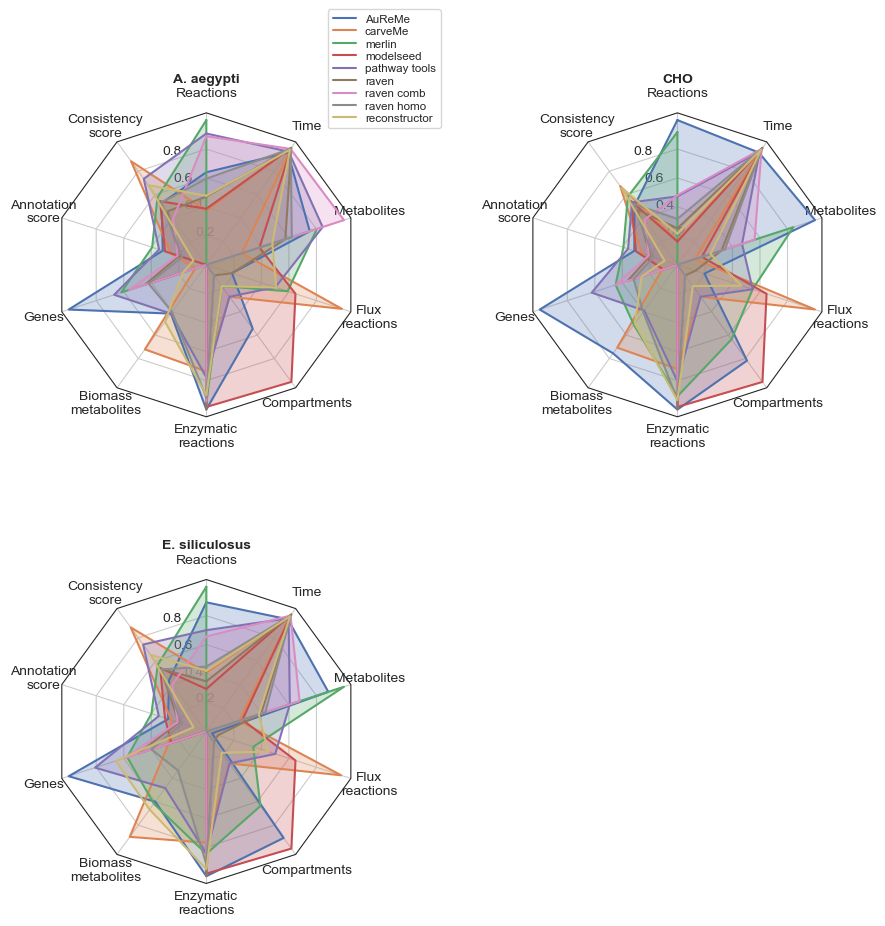

In [6]:
if __name__ == '__main__':
    data = data_plot
    spoke_labels = data.pop(0)
    
    N =len(spoke_labels)
    theta = radar_factory(N, frame='polygon')


    fig, axs = plt.subplots(figsize=(10, 10), nrows=2, ncols=2,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.55, hspace=0.4, top=0.85, bottom=0.05)

    #colors = ['b', 'r', 'g', 'm', 'y'] #colors for different datasets
    colors = sns.color_palette("deep", len(mega_df.columns))
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axs.flat, data):
        if not title =='M_pyrifera':
            ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
            ax.set_title(title.replace('_', '. '), weight='bold', size='medium', position=(0.5, 1.1),
                         horizontalalignment='center', verticalalignment='center')
            for d, color in zip(case_data, colors):
                ax.plot(theta, d, color=color)
                ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
            ax.set_varlabels(spoke_labels)
    axs[1, 1].axis('off')
    # add legend relative to top-left plot
    to_plot_labels = [m.replace('_',' ') for m in mega_df.columns]
    labels = (to_plot_labels) #mega_df.columns
    legend = axs[0, 0].legend(labels, loc=(0.9, 0.95),
                              labelspacing=0.2, fontsize='small')#,  borderpad=2, prop={'size':20})#, alpha=0)#, fontsize='small')

    #legend = axs[0].legend(labels, loc=(0.9, .95),
    #                          labelspacing=0.1, fontsize='small')
    #fig.text(0.5, 0.965, 'Title',
    #         horizontalalignment='center', color='black', weight='bold',
    #         size='large')
    #plt.savefig('test_methods.pdf')
    #plt.savefig('metacyc_methods.png', dpi=300)
    #plt.savefig('modelseed_methods.png', dpi=300)
    #plt.savefig('bigg_methods.png', dpi=300)
    #plt.savefig('kegg_methods.png', dpi=300)
    #plt.savefig('raven_methods.png', dpi=300) 
    #plt.savefig('fig1_withref.png', dpi=300) 
    plt.show()

In [45]:
new_df_dict = dict()
#org='A_aegypti'
#org='CHO'
org='E_siliculosus'
#org=  'M_pyrifera'
for c in mega_df.columns:
    print(c)
    print(mega_df[c][org])
    new_df_dict[c] = mega_df[c][org]


AuReMe
{'reactions': 3403, 'genes': 2857, 'enzymatic_rxns': 3403, 'flux_rxns': 0.04114017043784901, 'unique_metabolites': 0.8633509168550615, 'metabolites': 3981, 'compartments': 10, 'pure_met_rxns': 3286, 'score': 0.3381159244160728, 'cons_score': 0.43869831892497296, 'ann_score': 0.2777664877107327, 'time': 0.9583333333333334, 'biomass': 0.6}
carveMe
{'reactions': 1548, 'genes': 786, 'enzymatic_rxns': 1189, 'flux_rxns': 0.9799741602067183, 'unique_metabolites': 0.7583333333333333, 'metabolites': 1080, 'compartments': 3, 'pure_met_rxns': 1093, 'score': 0.49152312437493706, 'cons_score': 0.8891611690326972, 'ann_score': 0.252940297580281, 'time': 0.9993333333333333, 'biomass': 0.9}
merlin
{'reactions': 3813, 'genes': 1642, 'enzymatic_rxns': 3224, 'flux_rxns': 0.34120115394702333, 'unique_metabolites': 0.4579252003561888, 'metabolites': 4492, 'compartments': 7, 'pure_met_rxns': 3263, 'score': 0.4633782280902675, 'cons_score': 0.5709339561000251, 'ann_score': 0.39884479128441297, 'time':

In [19]:
new_df = pd.DataFrame.from_dict(new_df_dict)
new_df.dropna(axis=1)
#print(method)
print(org)
new_df

E_siliculosus


AuReMe      carveMe       merlin  pathway_tools  \
reactions           3403.000000  1548.000000  3813.000000    2669.000000   
genes               2857.000000   786.000000  1642.000000    2309.000000   
enzymatic_rxns      3403.000000  1189.000000  3224.000000    2250.000000   
flux_rxns              0.041140     0.979974     0.341201       0.500937   
unique_metabolites     0.863351     0.758333     0.457925       0.951577   
metabolites         3981.000000  1080.000000  4492.000000    2726.000000   
compartments          10.000000     3.000000     7.000000       3.000000   
pure_met_rxns       3286.000000  1093.000000  3263.000000    2611.000000   
score                  0.338116     0.491523     0.463378       0.494365   
cons_score             0.438698     0.889161     0.570934       0.742823   
ann_score              0.277766     0.252940     0.398845       0.345291   
time                   0.958333     0.999333     0.000000       0.966667   
biomass                0.600000     0.900000     0.616667       0.483333   

                          raven   raven_comb  reconstructor    reference  
reactions           1322.000000  2503.000000    1601.000000  2005.000000  
genes               1428.000000  1700.000000    1879.000000  2281.000000  
enzymatic_rxns      1322.000000  2360.000000    1523.000000  1601.000000  
flux_rxns              0.084720     0.000000       0.450344     0.300748  
unique_metabolites     1.000000     1.000000       0.979556     0.966455  
metabolites         1789.000000  3043.000000    1712.000000  2206.000000  
compartments           1.000000     1.000000       2.000000     7.000000  
pure_met_rxns       1313.000000  2494.000000    1524.000000  1899.000000  
score                  0.325833     0.279796       0.303891     0.453927  
cons_score             0.536670     0.400241       0.654901     0.617486  
ann_score              0.199330     0.207529       0.093285     0.355791  
time                   0.998333     0.990000       0.983333     0.000000  
biomass                0.000000     0.000000       0.666667     1.000000

In [92]:
mega_df.columns

Index(['carveMe', 'merlin', 'modelseed', 'raven_homo', 'reconstructor',
       'raven', 'AuReMe', 'raven_comb', 'pathway_tools'],
      dtype='object')

In [50]:
new_df_dict = dict()
#methods_to_plot = ['carveMe', 'merlin', 'modelseed', 'raven_homo',
#       'reconstructor', 'raven', 'AuReMe', 'raven_comb', 'pathway_tools']
#method = 'carveMe'
#method = 'merlin'
#method = 'modelseed'
method = 'raven_homo'
#method = 'reconstructor'
#method = 'raven'
#method = 'AuReMe'
#method = 'raven_comb'
#method = 'pathway_tools'
for org in mega_df.index:
    new_df_dict[org] = mega_df[method][org]
#for c in mega_df[method]:
#    print(c)
#    print(c.index)
    #print(mega_df[c][org])
    #new_df_dict[c] = mega_df[c][org]

In [51]:
mega_df.index

Index(['A_aegypti', 'CHO', 'E_siliculosus', 'M_pyrifera'], dtype='object')

In [52]:
new_df = pd.DataFrame.from_dict(new_df_dict)
new_df.dropna(axis=1)
print(method)
#print(org)
new_df

raven_homo


A_aegypti          CHO  E_siliculosus   M_pyrifera
reactions           1723.000000  2210.000000    1710.000000  1698.000000
genes               3452.000000  1990.000000    1141.000000  1568.000000
enzymatic_rxns      1581.000000  2066.000000    1567.000000  1555.000000
flux_rxns              0.000000     0.000000       0.000000     0.000000
unique_metabolites     1.000000     1.000000       1.000000     1.000000
metabolites         1897.000000  2288.000000    1928.000000  1922.000000
compartments           1.000000     1.000000       1.000000     1.000000
pure_met_rxns       1723.000000  2210.000000    1710.000000  1698.000000
score                  0.308364     0.304194       0.308913     0.319233
cons_score             0.530818     0.521086       0.530058     0.529093
ann_score              0.174892     0.174060       0.176226     0.193316
time                   0.991667     0.991667       0.991667     0.991667
biomass                0.402778     0.402439       0.333333     0.333333

In [114]:
with open('./to_plot/carveme/A_aegypti.json', encoding="utf-8") as json_data:
    d = json.load(json_data)
    json_data.close()

test_dict = d['tests']    

In [127]:
get_memote_stats(test_dict)

{'reactions': 3891,
 'genes': 3295,
 'biomass': 0,
 'enzymatic_rxns': 643,
 'dead_ends': 0,
 'unique_metabolites': 3112}

## Biomass analysis
The idea is to add a "curated" version of their biomass as a metric to the plot, for it we need to get curated models of the analyzed organisms. 
- A. aegypti
- CHO
- E. siliculosus
- M. pyrifera (for this we would use S. japonica o E. siliculosus)

In [7]:
os.listdir('./curated_models')

['CHO.json',
 '.DS_Store',
 'S_japonica.xml',
 'E_siliculosus.xml',
 'S_japonica.json',
 'A_aegypti.json',
 'E_siliculosus.json',
 'CHO.xml',
 'A_aegypti.xml']

In [8]:

def get_bio_mets():
    #Pre-load models organism and gets biomass metabolites
    biomets = dict()
    sbml_fid = {'CHO': 'CHO.xml', 'M_pyrifera': 'S_japonica.xml', 'E_siliculosus': 'E_siliculosus.xml', 'A_aegypti': 'A_aegypti.xml'}
    biomass_id = {'CHO':['BIOMASS_cho'], 'M_pyrifera': ['biomass_rxn'], 'E_siliculosus': ['biomass_rxn'], 'A_aegypti': ['biomass_DNA', 'biomass_RNA', 'biomass_carbohydrate','biomass_lipid', 'biomass_protein' ] }
    models_id = {'CHO':'BIOMASS_cho', 'M_pyrifera': 'biomass_rxn', 'E_siliculosus': 'biomass_rxn', 'A_aegypti': 'biomass_reaction' }
    db_org = {'CHO': 'bigg', 'M_pyrifera': 'metacyc', 'E_siliculosus': 'metacyc', 'A_aegypti': 'bigg'}
    for org in biomass_id.keys():
        sbml_path = './curated_models/'+sbml_fid[org]
        model =  cobra.io.read_sbml_model(sbml_path)    
        bio_rid = biomass_id[org]
        mets = []
        for r in bio_rid:
            bio_rxn = model.reactions.get_by_id(r)
            mets.extend([k.id for k in bio_rxn.metabolites.keys() if bio_rxn.metabolites[k]<0])
        print(mets)
        this_db = db_org[org]
        org_dict = dict()
        org_dict['mets'] = mets
        org_dict['db'] = this_db
        org_dict['model'] = sbml_path
        #db_out = 'MNX'
        
        biomets[org] = org_dict #consider in which database there are present? Map to mnx? 
    return biomets

In [9]:
bio_mets = get_bio_mets()

['ala__L_c', 'arg__L_c', 'asn__L_c', 'asp__L_c', 'atp_c', 'chsterol_c', 'clpn_cho_c', 'ctp_c', 'cys__L_c', 'datp_c', 'dctp_c', 'dgtp_c', 'dttp_c', 'gln__L_c', 'glu__L_c', 'gly_c', 'glygn2_c', 'gtp_c', 'h2o_c', 'his__L_c', 'ile__L_c', 'leu__L_c', 'lys__L_c', 'met__L_c', 'pa_cho_c', 'pail_cho_c', 'pchol_cho_c', 'pe_cho_c', 'pglyc_cho_c', 'phe__L_c', 'pro__L_c', 'ps_cho_c', 'ser__L_c', 'sphmyln_cho_c', 'tag_cho_c', 'thr__L_c', 'trp__L_c', 'tyr__L_c', 'utp_c', 'val__L_c', 'xolest_cho_c']


'' is not a valid SBML 'SId'.


['LYS_c', '4-AMINO-BUTYRATE_c', 'ARG_c', 'MET_c', 'ASN_c', 'CIT_c', 'CYS_c', 'GLC_c', 'GLT_c', 'GLY_c', 'GLYCEROL_c', 'GLYCOLLATE_c', 'HIS_c', 'ILE_c', 'L-ALPHA-ALANINE_c', 'L-ASPARTATE_c', 'L-ORNITHINE_c', 'LEU_c', 'MANNITOL_c', 'PHE_c', 'SER_c', 'SUC_c', 'THR_c', 'THREO-DS-ISO-CITRATE_c', 'VAL_c', 'PRO_c', 'GLN_c', 'GLYCERATE_c', 'TRP_c', 'TYR_c']
['GLYCOLLATE_c', 'PHE_c', 'THR_c', 'GLT_c', 'GLY_c', 'L-ALPHA-ALANINE_c', 'L-ORNITHINE_c', 'GLYCEROL_c', 'CIT_c', 'GLC_c', 'ILE_c', 'VAL_c', 'L-ASPARTATE_c', 'LYS_c', 'MANNITOL_c', 'PRO_c', 'SUC_c', 'ARG_c', 'MET_c', 'ASN_c', 'GLN_c', 'THREO-DS-ISO-CITRATE_c', 'HIS_c', 'TRP_c', 'TYR_c', 'LEU_c', '4-AMINO-BUTYRATE_c', 'CYS_c', 'GLYCERATE_c', 'SER_c']
['datp_n', 'dctp_n', 'dgtp_n', 'dttp_n', 'atp_c', 'ctp_c', 'gtp_c', 'utp_c', 'g6p_c', 'chsterol_c', 'clpn_hs_c', 'pail_hs_c', 'pchol_hs_c', 'pe_hs_c', 'ps_hs_c', 'ala_L_c', 'arg_L_c', 'asn_L_c', 'asp_L_c', 'atp_c', 'cys_L_c', 'gln_L_c', 'glu_L_c', 'gly_c', 'h2o_c', 'his_L_c', 'ile_L_c', 'leu_L_c

In [10]:
#- Automation loading models
#- Integration with script to change IDs
#- Integration to dataframe results to plot
def analysis_biomass(model, org, method, org_met_dict):
    #model: loaded cobra model
    #org: (string) id model
    #method: (string) method name
    #org_met_dict: (dict) dictionary 
    metabolite_list = org_met_dict[org]['mets']
    orig_len = len(metabolite_list)
    this_db = org_met_dict[org]['db']
    print(this_db)
    orig_model = org_met_dict[org]['model']
    db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"]}
    db_out = db_dict[method]
    
    met_list = []
    for db in db_out:
        met_list.extend(map_metabolites(metabolite_list, orig_model, this_db, db, mnx_only=False))
    metabolite_list = list(set(met_list))
    map_len = len(metabolite_list)
    #function that adds artificial biomass and tries to produce it
    #inputs: model, metabolite_list (with metabolites on same namespace)

    #score assignement:
    # absent metabolite 0
    # present metabolite 1
    # present and producible 2

    #open exchanges of model
    for reaction in model.exchanges:
        reaction.bounds = (
                        min(reaction.lower_bound, -1000),
                        max(reaction.upper_bound, 1000),
                    )
            
    
    curr_score = 0
    #mod_mets = org_met_dict[org]['mets']
    mod_mets = [m.id for m in model.metabolites]
    max_score = len(metabolite_list)*2 #all metabolites present and producible
    for m in metabolite_list:
        if m in mod_mets:
            curr_score = curr_score + 1
            with model:
                art_rxn = Reaction('test_biomass') #artificial biomass reaction
                met = model.metabolites.get_by_id(m)
                art_rxn.add_metabolites({met: -1})
                model.add_reactions([art_rxn])
                
                model.objective = model.reactions.test_biomass
                sol = model.optimize()
                
                if sol.status == 'optimal' and sol.objective_value > model.tolerance:
                    curr_score = curr_score + 1
            
        else:
            curr_score = curr_score +0
    #What is their media? Assuming open all entries of the model
    
    score = curr_score/max_score

    return score

In [11]:
def analysis_biomass_detailed(model, org, method, org_met_dict):
    #Instead of returning score, returns lists of metabolites absent, non producible and producible
    #model: cobra model (loaded)
    #org: string (org name)
    #method: string (method name)
    #biom_mets (now org_met_dict) from get_bio_mets
    metabolite_list = org_met_dict[org]['mets']
    orig_len = len(metabolite_list)
    this_db = org_met_dict[org]['db']
    max_score = orig_len*2 #all metabolites present and producible
    #print(this_db)
    orig_model = org_met_dict[org]['model']
    #Associate each method to a database (AuReMe is associated with all databases which is "un cacho")
    db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"]}
    db_out = db_dict[method]

    absent = list() #list of absent metabolites
    no_prod = list() #non-producible metabolites
    prod = list() #producible metabolites
    # load file with info of biomass composition on different organisms
    # File is structured in a way that if for a given entry [org][db] it has the dict between ids from its biomass and other dbs
    # BUT if biomass is in that same DB it has a list of metabolites. See file for more details
    file = open('mets_bio_df.json')
    mets_other_dbs = json.load(file) #dict [org][db] (dict with metabolites)
    
    met_list = []
    kegg_dict = dict()
  
    ###match 
    for db in db_out: #for some methods we map to multiple databases (raven_comb, Aureme)
        #met_list.extend(map_metabolites(metabolite_list, orig_model, this_db, db, mnx_only=False)) #old version without multiple db mapping
        if isinstance(mets_other_dbs[org][db],list): #if is list, then we are in the same DB as template
            met_list.extend(mets_other_dbs[org][db]) #list of metabolites to look for in model is the list stored in the file
            
            #rev_dict is the rev dict from this database to kegg (to go back to kegg ids after analysis)
            for k in mets_other_dbs[org]['kegg']:
                kegg_dict[k] = mets_other_dbs[org]['kegg'][k]
            #kegg_dict = mets_other_dbs[org]['kegg']
        
        else: #if it is dict then we need to move to the other database and store that
            met_dict = mets_other_dbs[org][db]
            
            #rev_dict is the rev dict from this database to kegg (to go back to kegg ids after analysis)
            for this_k in list(met_dict):#.keys():
                k = this_k #extra step to fix error message that appears when changing dict while iterating on it (see commented text in for)
                met_list.append(met_dict[k])
                kegg_dict[met_dict[k]] = mets_other_dbs[org]['kegg'][k]

        
    metabolite_list = list(set(met_list)) #metabolites that we are going to look for in model
    map_len = len(metabolite_list)
    #function that adds artificial biomass and tries to produce it
    #inputs: model, metabolite_list (with metabolites on same namespace)

    #score assignement:
    # absent metabolite 0
    # present metabolite 1
    # present and producible 2

    #open exchanges of model
    for reaction in model.exchanges:
        #this could be an issue with models that do not have "exchange" reactions defined
        reaction.bounds = (
                        min(reaction.lower_bound, -1000),
                        max(reaction.upper_bound, 1000),
                    )
      
    curr_score = 0
    mod_mets = [m.id for m in model.metabolites] #considers all in cytoplasm
    print('sample mod_mets')
    print(mod_mets[0:10])
    # TO IGNACIA: I think that this part may be causing our errors in the "sus" models, also in Aedes I did some editing on amino acid 
    # identifiers
    
    #I have models where suffix do not coincide with classical _c compartments, if these are here, I have to remove them and add _c for
    # comparison with database (in dicts), and THEN in the test_biomass 
    
    if method=='merlin':
        #suffixes=['__extr', '__cytop', '__vacu', '__in', '__nucl', '__chlo', '__mito']
        suffix = '__cytop'
        modsuffix = '' #_c
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='modelseed':
        #suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c"]
        suffix = '__c0'
        modsuffix = ''
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='reconstructor':
        suffixes = ["_c0", "_d0", "_g0", "_v0", "_w0", "_x0","_m0", "_n0", "_r0", "_e0", "_j0", "_c"]
        suffix = '_c'
        modsuffix = ''
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='raven':
        #mets without metacyc suffix, add to map to database and then eliminate for model
        suffix = ''
        modsuffix = '_c'
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
    elif method=='raven_comb':
        #does not have suffix? add?
        suffix = ''
        modsuffix = '_c'
        mod_mets = [m.replace(suffix,modsuffix) for m in mod_mets]
      
    else:
        suffix = ''
        modsuffix=''
    
    
    print('metabolite list')
    print(metabolite_list)
    for m in metabolite_list:   
        if m in mod_mets:
            if len(modsuffix)==0:
                orig_met = m+suffix
            else:
                orig_met = m[:-len(modsuffix)]+suffix
            #metabolites present in model (we still don't know if they are producible)
            curr_score = curr_score + 1
            no_prod.append(m) #could potentially be non-producible
            with model:
                art_rxn = Reaction('test_biomass') #artificial biomass reaction
                
                met = model.metabolites.get_by_id(orig_met)
                art_rxn.add_metabolites({met: -1})
                model.add_reactions([art_rxn])
                
                model.objective = model.reactions.test_biomass
                sol = model.optimize()
                
                if sol.status == 'optimal' and sol.objective_value > model.tolerance:
                    curr_score = curr_score + 1
                    prod.append(m)
                    no_prod.remove(m) #if producible then remove from this list
                
            
        else:
            #metabolite is absent in model
            curr_score = curr_score +0
            print(m)
            if len(modsuffix)==0:
                orig_met = m+suffix
            else:
                orig_met = m[:-len(modsuffix)]+suffix
            print(orig_met)
            absent.append(m)
            
    #Going back to kegg
    result = dict()
    print('kegg_dict')
    print(kegg_dict)
    print('absent')
    print(absent)
    absent_kegg = [kegg_dict[a] for a in absent] #absent
    noprod_kegg = [kegg_dict[n_p] for n_p in no_prod] #no_prod
    
    abs_set = set(absent_kegg)
    non_prod_set = set(noprod_kegg)
    if len(abs_set.intersection(non_prod_set))>0:
        for m in list(abs_set.intersection(non_prod_set)):
            noprod_kegg.remove(m)
    
    #Currently it delivers all results mapped to kegg, previous version in comments for each line
    result['absent'] = absent_kegg #absent
    result['non-producible'] = noprod_kegg #no_prod
    result['producible'] = [kegg_dict[p] for p in prod] #prod
    result['score'] = curr_score/orig_len*2
    
    # original outputs
    result['absent-original'] = absent
    result['non-producible-original'] = no_prod
    result['producible-original'] = prod
    result['metabolite-list'] = met_list
    
    return result


In [117]:
analysis_biomass_detailed(d, org_name, method, bio_mets)

sample mod_mets
['C00187__extr', 'C05335__extr', 'C06429__extr', 'C00069__extr', 'C06612__extr', 'C01346__extr', 'C01595__extr', 'C05981__extr', 'C00147__extr', 'C01081__extr']
metabolite list
['C00025', 'C00806', 'C00097', 'C00160', 'C00079', 'C00334', 'C00152', 'C00768', 'C00451', 'C16434', 'C00041', 'C00221', 'C00158', 'C16436', 'C16439', 'C00073', 'C00392', 'C00258', 'C00065', 'C00188', 'C00062', 'C01536', 'C16440', 'C00077', 'C16435', 'C00037', 'C00116', 'C00042', 'C00303', 'C00049']
C00806
C00806__cytop
C00768
C00768__cytop
C00451
C00451__cytop
C16434
C16434__cytop
C16436
C16436__cytop
C16439
C16439__cytop
C01536
C01536__cytop
C16440
C16440__cytop
C16435
C16435__cytop
C00303
C00303__cytop
kegg_dict
{'C00160': 'C00160', 'C00079': 'C00079', 'C00188': 'C00188', 'C00025': 'C00025', 'C00037': 'C00037', 'C00041': 'C00041', 'C00077': 'C00077', 'C00116': 'C00116', 'C00158': 'C00158', 'C00221': 'C00221', 'C16434': 'C16434', 'C16436': 'C16436', 'C00049': 'C00049', 'C16440': 'C16440', 'C003

{'absent': ['C00806',
  'C00768',
  'C00451',
  'C16434',
  'C16436',
  'C16439',
  'C01536',
  'C16440',
  'C16435',
  'C00303'],
 'non-producible': ['C00097', 'C00334', 'C00073'],
 'producible': ['C00025',
  'C00160',
  'C00079',
  'C00152',
  'C00041',
  'C00221',
  'C00158',
  'C00392',
  'C00258',
  'C00065',
  'C00188',
  'C00062',
  'C00077',
  'C00037',
  'C00116',
  'C00042',
  'C00049'],
 'absent-original': ['C00806',
  'C00768',
  'C00451',
  'C16434',
  'C16436',
  'C16439',
  'C01536',
  'C16440',
  'C16435',
  'C00303'],
 'non-producible-original': ['C00097', 'C00334', 'C00073'],
 'producible-original': ['C00025',
  'C00160',
  'C00079',
  'C00152',
  'C00041',
  'C00221',
  'C00158',
  'C00392',
  'C00258',
  'C00065',
  'C00188',
  'C00062',
  'C00077',
  'C00037',
  'C00116',
  'C00042',
  'C00049'],
 'metabolite-list': ['C00160',
  'C00079',
  'C00188',
  'C00025',
  'C00037',
  'C00041',
  'C00077',
  'C00116',
  'C00158',
  'C00221',
  'C16434',
  'C16436',
  'C0004

In [12]:
#methods_to_plot = ['carveMe', 'raven']
#methods_to_plot = ['carveMe', 'merlin', 'modelseed','raven_homo','reconstructor','raven','AuReMe','raven_comb', 'pathway_tools']
#methods_to_plot = ['carveMe']
methods_to_plot = ['AuReMe','raven_comb', 'raven']
res_dict = dict()
method_dict = dict()
for method in os.listdir('./to_plot/'):
    
    if len(methods_to_plot) == 0:
            methods_to_plot = os.listdir('./to_plot/')
    if not method.startswith('.'): 
        if method in methods_to_plot:
            org_dict = dict()
            for org in os.listdir('./to_plot/'+method):
                if not org.startswith('.') and ( org.endswith('.xml') or org.endswith('.sbml')):
                    print(org)
                    print('./to_plot/'+method+'/'+org)
                    d = cobra.io.read_sbml_model('./to_plot/'+method+'/'+org)
                    org_name = org.replace('.sbml','')
                    org_name = org_name.replace('.xml','')
                    results = analysis_biomass_detailed(d, org_name, method, bio_mets)
                    #print(results)
                    org_dict[org] = results
            method_dict[method] = org_dict

E_siliculosus.xml
./to_plot/raven/E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


sample mod_mets
['--MENTHOL', '1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE', '1-ALKENYL-2-ACYLGLYCEROL', '1-Acyl-sn-glycerols', '1-Alkenyl-2-Acyl-Glycerol-3P', '1-Alkenylglycerophosphoethanolamines', '1-Alkyl-2-acyl-glycerol', '1-Alkyl-2-acyl-glycerol-P-Etn', '1-KETO-2-METHYLVALERATE', '1-L-MYO-INOSITOL-1-P']
metabolite list
['PHE_c', 'L-ALPHA-ALANINE_c', 'THR_c', 'SER_c', 'LEU_c', 'GLYCEROL_c', 'PRO_c', 'THREO-DS-ISO-CITRATE_c', 'GLY_c', 'ASN_c', 'VAL_c', 'GLT_c', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'LYS_c', 'MET_c', 'HIS_c', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'ARG_c', 'GLYCOLLATE_c', 'L-ASPARTATE_c', 'CYS_c', 'GLC_c', 'TRP_c', 'MANNITOL_c', 'TYR_c', 'CIT_c']
PHE_c
PHE
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
THR_c
THR
SER_c
SER
LEU_c
LEU
GLYCEROL_c
GLYCEROL
PRO_c
PRO
THREO-DS-ISO-CITRATE_c
THREO-DS-ISO-CITRATE
GLY_c
GLY
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
4-AMINO-BUTYRATE_c
4-AMINO-BUTYRATE
GLYCERATE_c
GLYCERATE
SUC_c
SUC
LYS_c
LYS
MET_c
MET
HIS_c
HIS
L-ORNITHINE_c
L-ORNITHINE
ILE_c
ILE
GLN_c
GL

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


sample mod_mets
['--MENTHOL', '1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE', '1-3-7-TRIMETHYLXANTHINE', '1-7-DIMETHYLXANTHINE', '1-ALKENYL-2-ACYLGLYCEROL', '1-Acyl-2-Arachidonoyl-Glycerol-P', '1-Acyl-2-Arachidonoyl-Glycerols', '1-Acyl-2-Lysophosaphatidylserines', '1-Acyl-sn-glycerols', '1-Alkenyl-2-Acyl-Glycerol-3P']
metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'WATER_c', 'LEU_c', 'PRO_c', 'GLY_c', 'DATP_c', 'ASN_c', 'VAL_c', 'GLT_c', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'CARDIOLIPIN_c', 'MET_c', 'TTP_c', 'ILE_c', 'ARG_c', 'L-ASPARTATE_c', 'CYS_c', 'CHOLESTEROL_c', 'DGTP_c', 'L-1-phosphatidyl-inositols_c', 'TRP_c', 'TYR_c', 'DCTP_c', 'CTP_c', 'GLN_c']


L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
WATER_c
WATER
LEU_c
LEU
PRO_c
PRO
GLY_c
GLY
DATP_c
DATP
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
UTP_c
UTP
GTP_c
GTP
ATP_c
ATP
HIS_c
HIS
LYS_c
LYS
CARDIOLIPIN_c
CARDIOLIPIN
MET_c
MET
TTP_c
TTP
ILE_c
ILE
ARG_c
ARG
L-ASPARTATE_c
L-ASPARTATE
CYS_c
CYS
CHOLESTEROL_c

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


sample mod_mets
['1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE', '1-ALKENYL-2-ACYLGLYCEROL', '1-Acyl-2-Arachidonoyl-Glycerol-P', '1-Acyl-2-Arachidonoyl-Glycerols', '1-Acyl-2-Lysophosaphatidylserines', '1-Acyl-sn-glycerols', '1-Alkenyl-phosphoglycerol', '1-Alkenylglycerophosphoethanolamines', '1-Alkyl-2-acyl-glycerol', '1-Alkyl-2-acyl-glycerol-3-phosphate']
metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'WATER_c', 'LEU_c', 'PRO_c', 'GLY_c', 'DATP_c', 'ASN_c', 'VAL_c', 'GLT_c', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'MET_c', 'ILE_c', 'ARG_c', 'L-ASPARTATE_c', 'CYS_c', 'CHOLESTEROL_c', 'DGTP_c', 'TRP_c', 'TYR_c', 'DCTP_c', 'CTP_c', 'GLN_c', 'D-glucopyranose-6-phosphate_c', 'DTTP_c']


L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
WATER_c
WATER
LEU_c
LEU
PRO_c
PRO
GLY_c
GLY
DATP_c
DATP
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
UTP_c
UTP
GTP_c
GTP
ATP_c
ATP
HIS_c
HIS
LYS_c
LYS
MET_c
MET
ILE_c
ILE
ARG_c
ARG
L-ASPARTATE_c
L-ASPARTATE
CYS_c
CYS
CHOLESTEROL_c
CHOLESTEROL

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


sample mod_mets
['1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE', '1-ACYL-2-OLEOYL-SN-GLYCERO-3-PHOSPHOCHOL', '1-ALKENYL-2-ACYLGLYCEROL', '1-Acyl-2-Arachidonoyl-Glycerol-P', '1-Acyl-sn-glycerols', '1-Alkenylglycerophosphoethanolamines', '1-Alkyl-2-acyl-glycerol', '1-Alkyl-2-acyl-glycerol-P-Etn', '1-KETO-2-METHYLVALERATE', '1-L-MYO-INOSITOL-1-P']
metabolite list
['L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'LEU_c', 'GLYCEROL_c', 'PRO_c', 'THREO-DS-ISO-CITRATE_c', 'GLY_c', 'ASN_c', 'VAL_c', 'GLT_c', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'LYS_c', 'MET_c', 'HIS_c', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'ARG_c', 'GLYCOLLATE_c', 'CYS_c', 'L-ASPARTATE_c', 'GLC_c', 'TRP_c', 'MANNITOL_c', 'TYR_c', 'CIT_c']
L-ALPHA-ALANINE_c
L-ALPHA-ALANINE
PHE_c
PHE
SER_c
SER
THR_c
THR
LEU_c
LEU
GLYCEROL_c
GLYCEROL
PRO_c
PRO
THREO-DS-ISO-CITRATE_c
THREO-DS-ISO-CITRATE
GLY_c
GLY
ASN_c
ASN
VAL_c
VAL
GLT_c
GLT
4-AMINO-BUTYRATE_c
4-AMINO-BUTYRATE
GLYCERATE_c
GLYCERATE
SUC_c
SUC
LYS_c
LYS
MET_c
MET
HIS_c
HIS
L-ORNITHI

No objective coefficients in model. Unclear what should be optimized


sample mod_mets
['VANILLYL_MANDELATE_c', 'ADENOSYL-HOMO-CYS_c', 'PROTON_c', 'SINAPATE_c', 'CO-A_c', 'ATP_c', 'SINAPOYL-COA_c', 'AMP_c', 'PPI_c', 'INOSITOL-1-3-4-TRIPHOSPHATE_c']
metabolite list
['', 'PHE_c', 'L-ALPHA-ALANINE_c', 'C00062', 'C00768', 'C00079', 'GLYCEROL_c', 'gly_c', 'ala__L_c', 'cpd00064', 'trp__L_c', 'cpd00036', 'asp__L_c', 'ASN_c', 'cpd00190', 'leu__L_c', 'cpd00066', 'asn__L_c', 'L-ORNITHINE_c', 'ILE_c', 'cpd30745', 'C00065', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd00223', 'cpd15141', 'GLN_c', 'C00160', 'cpd00084', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'lys__L_c', 'GLY_c', 'cit_c', 'tyr__L_c', 'C16435', 'succ_c', 'C00258', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00073', 'C00188', 'C16439', 'glu__L_c', 'TRP_c', 'cpd15140', 'C00077', 'TYR_c', 'pro__L_c', 'cpd00314', 'glyclt_c', 'his__L_c', 'orn__L_c', 'glyc_c', 'cpd00353', 'cpd00033', 'gln__L_c', 'cpd15143', 'THR_c', 'LEU_c', 'C00042', 'cpd00051', 'phe__L_c', 'cpd00100', 'C00152', 'C00221', 

No objective coefficients in model. Unclear what should be optimized


sample mod_mets
['CPD-17263_c', 'leuktrC4_c', 'ga2_hs_g', 'h_g', 'HC02200_c', 'udp_g', 'hco3_c', 'leuktrC4_e', 'gm3_hs_g', 'HC02200_e']
metabolite list
['', 'C01194', 'L-ALPHA-ALANINE_c', 'PHE_c', 'C00062', 'chsterol_c', 'C00768', 'C00187', 'C00079', 'gly_c', 'ala__L_c', 'tag_cho_c', 'datp_c', 'trp__L_c', 'cpd00001', 'ps_cho_c', 'asp__L_c', 'ASN_c', 'leu__L_c', 'cpd00066', 'cpd00356', 'UTP_c', 'ATP_c', 'asn__L_c', 'pe_cho_c', 'h2o_c', 'ILE_c', 'cpd30745', 'C00065', 'cpd00241', 'C00416', 'C00123', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd15141', 'GLN_c', 'xolest_cho_c', 'atp_c', 'WATER_c', 'cpd00084', 'dgtp_c', 'clpn_cho_c', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'ctp_c', 'lys__L_c', 'C00182', 'GLY_c', 'cpd00052', 'DATP_c', 'tyr__L_c', 'C16435', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00063', 'C00286', 'C00073', 'C00188', 'CHOLESTEROL_c', 'glu__L_c', 'DGTP_c', 'TRP_c', 'cpd15140', 'TYR_c', 'DCTP_c', 'dctp_c', 'pro__L_c', 'CTP_c', 'his__L_c', 'C02530', 'cpd000

No objective coefficients in model. Unclear what should be optimized


sample mod_mets
['OXIDIZED-DITHIOTHREITOL_c', 'CPD-21535_c', 'DITHIOTHREITOL_c', '23-EPOXY-23-DIHYDRO-2-METHYL-14-NAPHTHOQ_c', 'Peptide-with-C-terminal-Lysine_c', 'WATER_c', 'Peptides-holder_c', 'LYS_c', 'CPD-21539_c', 'CPD-13004_c']
metabolite list
['', 'C01194', 'L-ALPHA-ALANINE_c', 'PHE_c', 'C00062', 'chsterol_c', 'C00768', 'C00187', 'C00079', 'gly_c', 'ala__L_c', 'dgtp_n', 'trp__L_c', 'cpd00001', 'g6p_c', 'datp_n', 'asp__L_c', 'ASN_c', 'leu__L_c', 'cpd00066', 'UTP_c', 'ATP_c', 'asn__L_c', 'h2o_c', 'ILE_c', 'cpd30745', 'C00065', 'C00123', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd15141', 'GLN_c', 'D-glucopyranose-6-phosphate_c', 'dctp_n', 'atp_c', 'WATER_c', 'cpd00084', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'ctp_c', 'lys__L_c', 'GLY_c', 'cpd00052', 'DATP_c', 'pchol_hs_c', 'tyr__L_c', 'C16435', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00063', 'C00286', 'C00073', 'C00188', 'CHOLESTEROL_c', 'glu__L_c', 'DGTP_c', 'TRP_c', 'cpd15140', 'TYR_c', 'DCTP_c', 'pro__L

No objective coefficients in model. Unclear what should be optimized


sample mod_mets
['PROTON_c', 'S-ADENOSYLMETHIONINE_c', 'S-ADENOSYLMETHIONINAMINE_c', 'CARBON-DIOXIDE_c', 'ADENOSYL-HOMO-CYS_c', 'S-ADENOSYLMETHIONINE_h', 'ADENOSYL-HOMO-CYS_h', 'ADENOSYL-HOMO-CYS_m', 'S-ADENOSYLMETHIONINE_m', 'Monocarboxylic-Acid-Amides_c']
metabolite list
['', 'L-ALPHA-ALANINE_c', 'PHE_c', 'C00062', 'C00768', 'C00079', 'GLYCEROL_c', 'gly_c', 'ala__L_c', 'cpd00064', 'trp__L_c', 'cpd00036', 'asp__L_c', 'ASN_c', 'cpd00190', 'leu__L_c', 'cpd00066', 'asn__L_c', 'L-ORNITHINE_c', 'ILE_c', 'cpd30745', 'C00065', 'CYS_c', 'C00041', 'cpd00132', 'cpd00572', 'cpd00041', 'cpd00223', 'cpd15141', 'GLN_c', 'C00160', 'cpd00084', 'ile__L_c', 'PRO_c', 'C00025', 'C00303', 'lys__L_c', 'GLY_c', 'cit_c', 'tyr__L_c', 'C16435', 'succ_c', 'C00258', 'cpd00023', 'cpd00253', 'C01536', 'cpd19007', 'C00073', 'C00188', 'C16439', 'glu__L_c', 'TRP_c', 'cpd15140', 'C00077', 'TYR_c', 'pro__L_c', 'cpd00314', 'glyclt_c', 'his__L_c', 'orn__L_c', 'glyc_c', 'cpd00353', 'cpd00033', 'gln__L_c', 'cpd15143', 'THR

No objective coefficients in model. Unclear what should be optimized
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


sample mod_mets
['+-5-oxo-1-2-campholide', '--MENTHOL', '1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE', '1-7-DIMETHYLXANTHINE', '1-ALKENYL-2-ACYLGLYCEROL', '1-ALKYL-GLYCERONE-3-PHOSPHATE', '1-AMINO-PROPAN-2-ONE-3-PHOSPHATE', '1-Acyl-sn-glycerols', '1-Alkenyl-2-Acyl-Glycerol-3P', '1-Alkenylglycerophosphoethanolamines']
metabolite list
['C00451', 'PHE_c', 'L-ALPHA-ALANINE_c', 'THR_c', 'SER_c', 'C00062', 'C00768', 'C00079', 'LEU_c', 'GLYCEROL_c', 'C00042', 'PRO_c', 'C00025', 'C00303', 'C00152', 'THREO-DS-ISO-CITRATE_c', 'C00221', 'C00037', 'GLY_c', 'C00097', 'C16440', 'ASN_c', 'VAL_c', 'GLT_c', 'C16435', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'C00116', 'LYS_c', 'MET_c', 'HIS_c', 'C00334', 'C00258', 'C16436', 'C16434', 'C01536', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'C00065', 'ARG_c', 'GLYCOLLATE_c', 'L-ASPARTATE_c', 'CYS_c', 'C00188', 'C00073', 'C00041', 'GLC_c', 'TRP_c', 'C16439', 'C00077', 'MANNITOL_c', 'TYR_c', 'C00049', 'C00392', 'C00806', 'CIT_c', 'C00158', 'C00160']
C00451
C004
PHE_c
PHE


/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


sample mod_mets
['+_5_oxo_1_2_campholide', '__MENTHOL', '1_2_DIPALMITOYLPHOSPHATIDYLCHOLINE', '1_3_7_TRIMETHYLXANTHINE', '1_7_DIMETHYLXANTHINE', '1_ALKENYL_2_ACYLGLYCEROL', '1_ALKYL_GLYCERONE_3_PHOSPHATE', '1_AMINO_PROPAN_2_ONE_3_PHOSPHATE', '1_Acyl_2_Arachidonoyl_Glycerol_P', '1_Acyl_2_Arachidonoyl_Glycerols']
metabolite list
['', 'C00044', 'C01194', 'C02530', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'C00062', 'WATER_c', 'C00002', 'LEU_c', 'C00187', 'C00768', 'C00350', 'C00079', 'PRO_c', 'C00025', 'C00303', 'C00152', 'C00131', 'C00344', 'C00182', 'C00037', 'C02737', 'GLY_c', 'C00097', 'C00550', 'C05980', 'C16440', 'DATP_c', 'C00075', 'ASN_c', 'VAL_c', 'GLT_c', 'C00459', 'C16435', 'UTP_c', 'GTP_c', 'ATP_c', 'HIS_c', 'LYS_c', 'CARDIOLIPIN_c', 'MET_c', 'TTP_c', 'C16436', 'C16434', 'C01536', 'C00157', 'ILE_c', 'C00065', 'C00416', 'ARG_c', 'C00123', 'C00063', 'C00286', 'C00422', 'L-ASPARTATE_c', 'CYS_c', 'C00073', 'CHOLESTEROL_c', 'C00041', 'C00188', 'DGTP_c', 'L-1-phosphatidyl-inos

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


sample mod_mets
['+_5_oxo_1_2_campholide', '1_2_DIPALMITOYLPHOSPHATIDYLCHOLINE', '1_7_DIMETHYLXANTHINE', '1_ALKENYL_2_ACYLGLYCEROL', '1_ALKYL_GLYCERONE_3_PHOSPHATE', '1_AMINO_PROPAN_2_ONE_3_PHOSPHATE', '1_Acyl_2_Arachidonoyl_Glycerol_P', '1_Acyl_2_Arachidonoyl_Glycerols', '1_Acyl_2_Lysophosaphatidylserines', '1_Acyl_sn_glycerols']
metabolite list
['', 'C00044', 'C01194', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'C00002', 'WATER_c', 'C00187', 'LEU_c', 'C00350', 'C00062', 'C00768', 'C00079', 'PRO_c', 'C00025', 'C00303', 'C00152', 'C00131', 'C02737', 'C00037', 'GLY_c', 'C00097', 'C00075', 'C05980', 'DATP_c', 'C16440', 'ASN_c', 'VAL_c', 'GLT_c', 'C00459', 'C16435', 'UTP_c', 'GTP_c', 'C00458', 'ATP_c', 'HIS_c', 'LYS_c', 'MET_c', 'C16436', 'C16434', 'C01536', 'C00157', 'ILE_c', 'C00065', 'ARG_c', 'C00123', 'C00063', 'C00286', 'L-ASPARTATE_c', 'CYS_c', 'C00073', 'CHOLESTEROL_c', 'C00092', 'C00041', 'DGTP_c', 'TRP_c', 'C00001', 'C00188', 'TYR_c', 'DCTP_c', 'C00049', 'C00806', 'CTP_c', '

No objective coefficients in model. Unclear what should be optimized


sample mod_mets
['+-5-oxo-1-2-campholide', '1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE', '1-7-DIMETHYLXANTHINE', '1-ACYL-2-OLEOYL-SN-GLYCERO-3-PHOSPHOCHOL', '1-ALKENYL-2-ACYLGLYCEROL', '1-ALKYL-GLYCERONE-3-PHOSPHATE', '1-AMINO-PROPAN-2-ONE-3-PHOSPHATE', '1-Acyl-2-Arachidonoyl-Glycerol-P', '1-Acyl-sn-glycerols', '1-Alkenylglycerophosphoethanolamines']
metabolite list
['C00451', 'L-ALPHA-ALANINE_c', 'PHE_c', 'SER_c', 'THR_c', 'C00062', 'C00768', 'C00079', 'LEU_c', 'GLYCEROL_c', 'C00042', 'PRO_c', 'C00025', 'C00303', 'C00152', 'THREO-DS-ISO-CITRATE_c', 'C00221', 'C00037', 'GLY_c', 'C00097', 'C16440', 'ASN_c', 'VAL_c', 'GLT_c', 'C16435', '4-AMINO-BUTYRATE_c', 'GLYCERATE_c', 'SUC_c', 'C00116', 'LYS_c', 'MET_c', 'HIS_c', 'C00334', 'C00258', 'C16436', 'C16434', 'C01536', 'L-ORNITHINE_c', 'ILE_c', 'GLN_c', 'C00065', 'ARG_c', 'GLYCOLLATE_c', 'CYS_c', 'L-ASPARTATE_c', 'C00073', 'C00188', 'C00041', 'GLC_c', 'TRP_c', 'C16439', 'C00077', 'MANNITOL_c', 'TYR_c', 'C00049', 'C00392', 'C00806', 'CIT_c', 'C00158

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


In [16]:
method_dict['AuReMe']['A_aegypti.xml']

{'absent': ['C00123',
  'C01194',
  'C00062',
  'C00187',
  'C00768',
  'C00187',
  'C00079',
  'C00037',
  'C00041',
  'C00286',
  'C00806',
  'C00001',
  'C00092',
  'C00131',
  'C00049',
  'C00123',
  'C00079',
  'C00152',
  'C00001',
  'C01536',
  'C00065',
  'C00123',
  'C00041',
  'C00152',
  'C00768',
  'C00049',
  'C16436',
  'C00458',
  'C00002',
  'C00097',
  'C16434',
  'C00025',
  'C00303',
  'C00063',
  'C16440',
  'C00063',
  'C00157',
  'C01536',
  'C16435',
  'C00025',
  'C00303',
  'C01536',
  'C00806',
  'C00063',
  'C00286',
  'C00073',
  'C00188',
  'C00025',
  'C16435',
  'C16435',
  'C00350',
  'C00768',
  'C00037',
  'C00303',
  'C00350',
  'C00062',
  'C00075',
  'C00079',
  'C00152',
  'C02737',
  'C00037',
  'C00097',
  'C00075',
  'C00459',
  'C16440',
  'C05980',
  'C00459',
  'C00002',
  'C00157',
  'C00188',
  'C00350',
  'C00062',
  'C00806',
  'C00459',
  'C00044',
  'C00002',
  'C00065',
  'C00092',
  'C01194',
  'C00073',
  'C01194',
  'C00065',
  'C00

In [48]:
for m in method_dict.keys():
    #print(method_dict[m])
    #print(m)
    for org in method_dict[m].keys():
        #print(org)
        #print(method_dict[m][org])
        this_dict = method_dict[m][org]
        absent = set(this_dict['absent'])
        nonproducible = set(this_dict['non-producible'])
        if len(absent.intersection(nonproducible)) > 0:
            
            print('\n')
            print(m)
            print(org)
            #print(this_dict)
            for k in this_dict.keys():
                print(k)
                print(this_dict[k])
            print('intersection')
            print(absent.intersection(nonproducible))
        #print(absent.intersection(nonproducible))
        #print(len(this_dict['absent']))
        #print(len(this_dict['absent-original']))



AuReMe
E_siliculosus.xml
absent
['C00451', 'C00221', 'C00065', 'C00152', 'C00768', 'C16440', 'C00097', 'C00451', 'C00079', 'C16436', 'C16439', 'C00152', 'C00073', 'C00258', 'C00065', 'C16440', 'C16435', 'C00041', 'C16435', 'C00258', 'C00049', 'C00025', 'C00768', 'C00079', 'C16439', 'C00303', 'C01536', 'C16434', 'C00806', 'C00160', 'C00077', 'C00188', 'C00334', 'C16434', 'C16434', 'C16440', 'C00768', 'C00073', 'C00037', 'C00806', 'C00116', 'C00049', 'C16435', 'C00025', 'C00077', 'C00806', 'C00097', 'C16436', 'C00160', 'C00025', 'C00065', 'C00037', 'C00334', 'C00392', 'C16439', 'C00451', 'C00049', 'C00221', 'C00188', 'C00258', 'C00303', 'C00392', 'C00062', 'C01536', 'C00073', 'C00392', 'C00303', 'C00097', 'C00158', 'C00079', 'C01536', 'C00042', 'C00188', 'C00041', 'C00041', 'C00158', 'C00152', 'C00062', 'C00077', 'C00062', 'C00116', 'C00042', 'C16436', 'C00221']
non-producible
['C00334', 'C00160', 'C00037', 'C00042', 'C00116', 'C00158']
producible
[]
absent-original
['', 'glc__bD_c', '

In [123]:
import json
#with open('biomass_detail_KEGG.json', 'w') as fp:
with open('240424biomass_detail_KEGG.json', 'w') as fp:
    json.dump(method_dict, fp)

In [29]:
methods_to_plot

['raven', 'raven_homo', 'raven_comb']

In [30]:
methods_to_plot = ['raven']
for method in os.listdir('./to_plot/'):
    if len(methods_to_plot) == 0:
            methods_to_plot = os.listdir('./to_plot/')
    if not method.startswith('.'):  
        if method in methods_to_plot:
            method_dict = dict()
            print(method)
            for org in os.listdir('./to_plot/'+method):
                if not org.startswith('.') and ( org.endswith('.xml') or org.endswith('.sbml')):
                    org_dict = dict()
                    print(org)
                    d = cobra.io.read_sbml_model('./to_plot/'+method+'/'+org)
                    
                    a_bio = analysis_biomass(d, org.replace('.xml',''), method, bio_mets)
                    print('\n\n\n\n\n\n')
                    print(a_bio)

raven
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


metacyc
df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1            11z3oxoicos11enoylacps   
2                11zicos11enoylacps   
3                    12diglycerides   
4  12dipalmitoylphosphatidylcholine   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
2     M_11Z__45__icos__45__11__45__enoyl__45__ACPs_c   MNXM148796   
3                     M_1__45__2__45__Diglycerides_c    MNXM96050   
4   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c    MNXM32122   

                              metacyc bigg_mnx kegg_mnx modelseed_mn

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_49899/2350552597.py:236: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                      normalized_id  \
0         10formyldihydrofolateglun   
1            11z3oxoicos11enoylacps   
2                11zicos11enoylacps   
3                    12diglycerides   
4  12dipalmitoylphosphatidylcholine   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
2     M_11Z__45__icos__45__11__45__enoyl__45__ACPs_c   MNXM148796   
3                     M_1__45__2__45__Diglycerides_c    MNXM96050   
4   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c    MNXM32122   

                              metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0       10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1        11Z-3-oxo-icos-11-enoyl-ACPs                        cpd37266           
2              11Z-icos-11-enoyl-ACPs                        cpd36735           
3                    1-2-D

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]
No objective coefficients in model. Unclear what should be optimized


bigg
df_metanetx
            normalized_id     MNX
original_id                      
M_oh1                moh1  MNXM02
oh1                   oh1  MNXM02
M_h                    mh   MNXM1
h                       h   MNXM1
M_nadh              mnadh  MNXM10
mapping metanetx
  normalized_id     original_id          MNX        bigg    metacyc_mnx  \
0        10fthf      M_10fthf_c  MNXM1102376      10fthf  10-FORMYL-THF   
1        10fthf      M_10fthf_e  MNXM1102376      10fthf  10-FORMYL-THF   
2    10fthf5glu  M_10fthf5glu_c     MNXM3428  10fthf5glu            NaN   
3    10fthf5glu  M_10fthf5glu_e     MNXM3428  10fthf5glu            NaN   
4   10fthf5glul  M_10fthf5glu_l          NaN         NaN            NaN   

  kegg_mnx modelseed_mnx  
0   C00234      cpd00201  
1   C00234      cpd00201  
2      NaN           NaN  
3      NaN           NaN  
4      NaN           NaN  
mapping modelseed


/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_49899/2350552597.py:236: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id     original_id          MNX        bigg    metacyc_mnx  \
0        10fthf      M_10fthf_c  MNXM1102376      10fthf  10-FORMYL-THF   
1        10fthf      M_10fthf_e  MNXM1102376      10fthf  10-FORMYL-THF   
2    10fthf5glu  M_10fthf5glu_c     MNXM3428  10fthf5glu            NaN   
3    10fthf5glu  M_10fthf5glu_e     MNXM3428  10fthf5glu            NaN   
4   10fthf5glul  M_10fthf5glu_l          NaN         NaN            NaN   

  kegg_mnx modelseed_mnx Modelseed_DB  
0   C00234      cpd00201     cpd00201  
1   C00234      cpd00201     cpd00201  
2      NaN           NaN          NaN  
3      NaN           NaN          NaN  
4      NaN           NaN          NaN  
adding name and formula
  normalized_id     original_id          MNX        bigg    metacyc_mnx  \
0        10fthf      M_10fthf_c  MNXM1102376      10fthf  10-FORMYL-THF   
1        10fthf      M_10fthf_e  MNXM1102376      10fthf  10-FORMYL-THF   
2    10fthf5glu  M_10fthf5glu_c     MNXM3428  10fthf5glu    

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]
No objective coefficients in model. Unclear what should be optimized


bigg
df_metanetx
            normalized_id     MNX
original_id                      
M_oh1                moh1  MNXM02
oh1                   oh1  MNXM02
M_h                    mh   MNXM1
h                       h   MNXM1
M_nadh              mnadh  MNXM10
mapping metanetx
  normalized_id     original_id          MNX        bigg    metacyc_mnx  \
0        10fthf      M_10fthf_c  MNXM1102376      10fthf  10-FORMYL-THF   
1        10fthf      M_10fthf_e  MNXM1102376      10fthf  10-FORMYL-THF   
2    10fthf5glu  M_10fthf5glu_c     MNXM3428  10fthf5glu            NaN   
3    10fthf5glu  M_10fthf5glu_e     MNXM3428  10fthf5glu            NaN   
4   10fthf5glul  M_10fthf5glu_l          NaN         NaN            NaN   

  kegg_mnx modelseed_mnx  
0   C00234      cpd00201  
1   C00234      cpd00201  
2      NaN           NaN  
3      NaN           NaN  
4      NaN           NaN  
mapping modelseed


/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_49899/2350552597.py:236: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id     original_id          MNX        bigg    metacyc_mnx  \
0        10fthf      M_10fthf_c  MNXM1102376      10fthf  10-FORMYL-THF   
1        10fthf      M_10fthf_e  MNXM1102376      10fthf  10-FORMYL-THF   
2    10fthf5glu  M_10fthf5glu_c     MNXM3428  10fthf5glu            NaN   
3    10fthf5glu  M_10fthf5glu_e     MNXM3428  10fthf5glu            NaN   
4   10fthf5glul  M_10fthf5glu_l          NaN         NaN            NaN   

  kegg_mnx modelseed_mnx Modelseed_DB  
0   C00234      cpd00201     cpd00201  
1   C00234      cpd00201     cpd00201  
2      NaN           NaN          NaN  
3      NaN           NaN          NaN  
4      NaN           NaN          NaN  
adding name and formula
  normalized_id     original_id          MNX        bigg    metacyc_mnx  \
0        10fthf      M_10fthf_c  MNXM1102376      10fthf  10-FORMYL-THF   
1        10fthf      M_10fthf_e  MNXM1102376      10fthf  10-FORMYL-THF   
2    10fthf5glu  M_10fthf5glu_c     MNXM3428  10fthf5glu    

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]
No objective coefficients in model. Unclear what should be optimized


metacyc
df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1                       10formylthf   
2                      10formylthfh   
3                      10formylthfx   
4  11832183snglycerolphosphocholine   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                        M_10__45__FORMYL__45__THF_c  MNXM1102376   
2                        M_10__45__FORMYL__45__THF_h          NaN   
3                        M_10__45__FORMYL__45__THF_x          NaN   
4  M_1__45__183__45__2__45__183__45__SN__45__GLYC...     MNXM9575   

                                  metacyc bigg_mnx kegg_mnx modelsee

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_49899/2350552597.py:236: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                      normalized_id  \
0         10formyldihydrofolateglun   
1                       10formylthf   
2                      10formylthfh   
3                      10formylthfx   
4  11832183snglycerolphosphocholine   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                        M_10__45__FORMYL__45__THF_c  MNXM1102376   
2                        M_10__45__FORMYL__45__THF_h                
3                        M_10__45__FORMYL__45__THF_x                
4  M_1__45__183__45__2__45__183__45__SN__45__GLYC...     MNXM9575   

                                  metacyc bigg_mnx kegg_mnx modelseed_mnx  \
0           10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705   
1                           10-FORMYL-THF   10fthf   C00234      cpd00201   
2                                                                           
3                                         

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/cobra/medium/boundary_types.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return most[0]


Identificadores agregados para L-xylonate - C5H9O6: ['D-XYLONATE']
Identificadores agregados para D-xylulose - C5H10O5: ['Xylulose']
Identificadores agregados para L-xylulose - C5H10O5: ['Xylulose']
  normalized_id     original_id          MNX        bigg    metacyc_mnx  \
0        10fthf      M_10fthf_c  MNXM1102376      10fthf  10-FORMYL-THF   
1        10fthf      M_10fthf_e  MNXM1102376      10fthf  10-FORMYL-THF   
2    10fthf5glu  M_10fthf5glu_c     MNXM3428  10fthf5glu            NaN   
3    10fthf5glu  M_10fthf5glu_e     MNXM3428  10fthf5glu            NaN   
4   10fthf5glul  M_10fthf5glu_l          NaN         NaN            NaN   

  kegg_mnx modelseed_mnx Modelseed_DB                                name  \
0   C00234      cpd00201     cpd00201          10_Formyltetrahydrofolatew   
1   C00234      cpd00201     cpd00201          10_Formyltetrahydrofolatew   
2      NaN           NaN          NaN  10-formyltetrahydrofolate-[Glu](5)   
3      NaN           NaN          NaN  10-

Identificadores agregados para adipoyl-CoA - C27H44N7O19P3S: ['C14143']
Identificadores agregados para ADPmannose - C16H25N5O15P2: ['C00096', 'C06192']
Identificadores agregados para ADP-D-ribose 2-phosphate(4-) - C15H20N5O17P3: ['C03246']
Identificadores agregados para ADP-D-ribose 2-phosphate(4-) - C15H20N5O17P3: ['C03246']
Identificadores agregados para Adrenaline - C9H13NO3: ['C00788']
Identificadores agregados para Adrenaline - C9H13NO3: ['C00788']
Identificadores agregados para adenylyl selenate - C10H14N5O10PSe: ['C05686']
Identificadores agregados para S_Adenosyl_homocysteinew - C14H20N6O5S: ['C00021']
Identificadores agregados para S_Adenosyl_homocysteinew - C14H20N6O5S: ['C00021']
Identificadores agregados para 7,8-dihydroneopterin 3-triphosphate(4-) - C9H12N5O13P3: ['C04895', 'C21094']
Identificadores agregados para 7,8-dihydroneopterin 3-triphosphate(4-) - C9H12N5O13P3: ['C04895', 'C21094']
Identificadores agregados para 1-alkyl-sn-glycero-3-phosphocholine - C8H19NO6PR: ['C

Identificadores agregados para 3,3-diiodo-L-thyronine - C15H13I2NO4: ['C07639']
Identificadores agregados para 3,5-diiodo-L-thyronine - C15H13I2NO4: ['C07639']
Identificadores agregados para 2E,7Z,10Z,13Z,16Z-docosapentaenoyl-CoA - C43H64N7O17P3S: ['C16166', 'C16170', 'C16173']
Identificadores agregados para N-acetyl-leukotriene E4 - C25H37NO6S: ['C11361']
Identificadores agregados para 12-dehydro-leukotriene B4 - C20H30O4: ['C05949']
Identificadores agregados para 21-hydroxyallopregnanolone - C21H34O3: ['C05485']
Identificadores agregados para 17beta-estradiol-3,4-semiquinone - C18H22O3: ['C22357', 'C22358']
Identificadores agregados para 17beta-estradiol-2,3-semiquinone - C18H22O3: ['C22357', 'C22358']
Identificadores agregados para all-trans-retinoic acid - C20H28O2: ['C16677', 'C16679', 'C16680']
Identificadores agregados para prostaglandin G1 - C20H33O6: ['C05956']
Identificadores agregados para prostaglandin H1 - C20H33O5: ['C00427', 'C00584', 'C00696', 'C01312', 'C06438', 'C0643

Identificadores agregados para Formatew - CHO2: ['C00058']
Identificadores agregados para N_Formimino_L_glutamatew - C6H8N2O4: ['C00439']
Identificadores agregados para Fumaratew - C4H2O4: ['C00122']
Identificadores agregados para Fumaratew - C4H2O4: ['C00122']
Identificadores agregados para Glucose_1_phosphatew - C6H11O9P: ['C00103']
Identificadores agregados para Glucose_1_phosphatew - C6H11O9P: ['C00103']
Identificadores agregados para Glyceraldehyde3_phosphatew - C3H5O6P: ['C00118', 'C00661']
Identificadores agregados para D_Glucosamine_phosphatew - C6H14NO8P: ['C00352', 'C20589']
Identificadores agregados para Glycolaldehydew - C2H4O2: ['C00266', 'C19246']
Identificadores agregados para Glycocholatew - C26H42NO6: ['C01921']
Identificadores agregados para Glycocholatew - C26H42NO6: ['C01921']
Identificadores agregados para GDPw - C10H12N5O11P2: ['C00035']
Identificadores agregados para GDPw - C10H12N5O11P2: ['C00035']
Identificadores agregados para GDP-4-dehydro-6-deoxy-alpha-D-man

Identificadores agregados para leukotriene E4(1-) - C23H36NO5S: ['C05952']
Identificadores agregados para Leucylleucine - C12H24N2O3: ['C11332']
Identificadores agregados para Leucylleucine - C12H24N2O3: ['C11332']
Identificadores agregados para N-formyl-L-kynurenine - C11H12N2O4: ['C02700', 'C15605']
Identificadores agregados para N-formyl-L-kynurenine - C11H12N2O4: ['C02700', 'C15605']
Identificadores agregados para alpha-Linolenoyl-CoA - C39H64N7O17P3S: ['C03035']
Identificadores agregados para gamma-linolenoyl-CoA(4-) - C39H60N7O17P3S: ['C03035']
Identificadores agregados para Losartan-M1 - C22H22ClN6O2: ['C07072']
Identificadores agregados para Losartan-M1 - C22H22ClN6O2: ['C07072']
Identificadores agregados para Losartan-M2 - C22H22ClN6O2: ['C07072']
Identificadores agregados para Losartan-M2 - C22H22ClN6O2: ['C07072']
Identificadores agregados para Losartan-M5 - C22H22ClN6O2: ['C07072']
Identificadores agregados para Losartan-M5 - C22H22ClN6O2: ['C07072']
Identificadores agregad

Identificadores agregados para selenomethionine - C5H11NO2Se: ['C05335']
Identificadores agregados para S-formylglutathionate(1-) - C11H16N3O7S: ['C01031']
Identificadores agregados para sphingosylphosphocholine acid - C23H50N2O5P: ['C03640']
Identificadores agregados para sphingosylphosphocholine acid - C23H50N2O5P: ['C03640']
Identificadores agregados para sphingosine 1-phosphate(1-) - C18H37NO5P: ['C06124']
Identificadores agregados para sphingosine 1-phosphate(1-) - C18H37NO5P: ['C06124']
Identificadores agregados para Succinatew - C4H4O4: ['C00042']
Identificadores agregados para Succinatew - C4H4O4: ['C00042']
Identificadores agregados para Succinyl_CoAw - C25H35N7O19P3S: ['C00091']
Identificadores agregados para Taurinew - C2H7NO3S: ['C00245']
Identificadores agregados para Taurinew - C2H7NO3S: ['C00245']
Identificadores agregados para Taurocholatew - C26H44NO7S: ['C05122', 'C15516']
Identificadores agregados para Taurocholatew - C26H44NO7S: ['C05122', 'C15516']
Identificadores 

Identificadores agregados para 2-Hydroxybutyrate - C4H8O3: ['cpd00876', 'cpd03561', 'cpd23313', 'cpd29193']
Identificadores agregados para 2-Hydroxybutyrate - C4H8O3: ['cpd00876', 'cpd03561', 'cpd23313', 'cpd29193']
Identificadores agregados para 2-methylcitrate(3-) - C7H7O7: ['cpd01501']
Identificadores agregados para 2-methylcitrate(3-) - C7H7O7: ['cpd01501']
Identificadores agregados para 2-oxobutanoate - C4H5O3: ['cpd00199', 'cpd21902']
Identificadores agregados para 2_Phospho_D_glyceratew - C3H4O7P: ['cpd00482']
Identificadores agregados para 3,4-Dihydroxymandelate - C8H8O5: ['cpd03307']
Identificadores agregados para 3,4-Dihydroxyphenylacetaldehyde - C8H8O3: ['cpd02361']
Identificadores agregados para (3,4-dihydroxyphenyl)acetate - C8H7O4: ['cpd00489', 'cpd03320', 'cpd03714']
Identificadores agregados para p_hydroxyphenylpyruvatew - C9H7O4: ['cpd00868']
Identificadores agregados para p_hydroxyphenylpyruvatew - C9H7O4: ['cpd00868']
Identificadores agregados para (S)-3-aminoisobuty

Identificadores agregados para N-Acetylneuraminate 9-phosphate - C11H20NO12P: ['cpd03733']
Identificadores agregados para N_Acetylornithinew - C7H14N2O3: ['cpd00342']
Identificadores agregados para Adenosinew - C10H13N5O4: ['cpd00182']
Identificadores agregados para Adenosinew - C10H13N5O4: ['cpd00182']
Identificadores agregados para Calomidew - C72H100CoN18O17P: ['cpd00166']
Identificadores agregados para Calomidew - C72H100CoN18O17P: ['cpd00166']
Identificadores agregados para ADPw - C10H12N5O10P2: ['cpd00008']
Identificadores agregados para ADPw - C10H12N5O10P2: ['cpd00008']
Identificadores agregados para adipoyl-CoA - C27H44N7O19P3S: ['cpd09842']
Identificadores agregados para ADPmannose - C16H25N5O15P2: ['cpd00083', 'cpd03700']
Identificadores agregados para ADP-D-ribose 2-phosphate(4-) - C15H20N5O17P3: ['cpd02079']
Identificadores agregados para ADP-D-ribose 2-phosphate(4-) - C15H20N5O17P3: ['cpd02079']
Identificadores agregados para adrenic acid - C22H36O2: ['cpd16342']
Identifi

Identificadores agregados para CDPw - C9H12N3O11P2: ['cpd00096']
Identificadores agregados para CDPcholine - C14H26N4O11P2: ['cpd00256']
Identificadores agregados para CDPethanolaminew - C11H19N4O11P2: ['cpd00444']
Identificadores agregados para CDPethanolaminew - C11H19N4O11P2: ['cpd00444']
Identificadores agregados para 5beta-cholestane-3alpha,7alpha,27-triol - C27H48O3: ['cpd03227', 'cpd03229', 'cpd03235', 'cpd22725']
Identificadores agregados para 12-hydroxyeicosatetraenoate - C20H31O3: ['cpd31956']
Identificadores agregados para gama-L-glutamyl-L-alanine - C8H13N2O5: ['cpd02343', 'cpd15236']
Identificadores agregados para malonaldehyde - C3H4O2: ['cpd20696']
Identificadores agregados para 3-oxopalmitoleoyl-CoA - C37H58N7O18P3S: ['cpd03114']
Identificadores agregados para cis-(3S)-hydroxytetradec-7-enoyl-CoA - C35H56N7O18P3S: ['cpd26436', 'cpd35070']
Identificadores agregados para 5-S-cysteinyldopa - C12H16N2O6S: ['cpd32251', 'cpd35058']
Identificadores agregados para 5beta-cholest

Identificadores agregados para Cholatew - C24H39O5: ['cpd00526']
Identificadores agregados para Cholatew - C24H39O5: ['cpd00526']
Identificadores agregados para (25R)-3alpha,7alpha,12alpha-trihydroxy-5beta-cholestan-26-oyl-CoA(4-) - C48H76N7O20P3S: ['cpd02898', 'cpd03231', 'cpd03233', 'cpd03241', 'cpd03248', 'cpd11262', 'cpd11263', 'cpd17481', 'cpd17482', 'cpd17483', 'cpd22728', 'cpd24758']
Identificadores agregados para cholesterol sulfate - C27H46O4S: ['cpd18026']
Identificadores agregados para Citratew - C6H5O7: ['cpd00137']
Identificadores agregados para Citratew - C6H5O7: ['cpd00137']
Identificadores agregados para CMPw - C9H12N3O8P: ['cpd00046']
Identificadores agregados para CMPw - C9H12N3O8P: ['cpd00046']
Identificadores agregados para CMP-2-aminoethylphosphonate - C11H20N4O10P2: ['cpd03380']
Identificadores agregados para CMP_N_acetylneuraminatew - C20H29N4O16P: ['cpd00112']
Identificadores agregados para CMP-N-trimethyl-2-aminoethylphosphonate - C14H27N4O10P2: ['cpd03380']
Id

Identificadores agregados para aflatoxin B1 exo-8,9-epoxide - C17H12O7: ['cpd20840', 'cpd20847', 'cpd20848']
Identificadores agregados para eicosatetranoic acid - C20H32O2: ['cpd03851']
Identificadores agregados para eicosatetranoic acid - C20H32O2: ['cpd03851']
Identificadores agregados para 16-Glucuronide-estriol - C24H32O9: ['cpd03278']
Identificadores agregados para 16-Glucuronide-estriol - C24H32O9: ['cpd03278']
Identificadores agregados para estrone 3-sulfate(1-) - C18H21O5S: ['cpd01669']
Identificadores agregados para estrone 3-sulfate(1-) - C18H21O5S: ['cpd01669']
Identificadores agregados para Aminoethanolw - C2H8NO: ['cpd00162']
Identificadores agregados para D-Fructose 1-phosphate - C6H13O9P: ['cpd00072', 'cpd00348', 'cpd00802', 'cpd02085', 'cpd14653', 'cpd19025', 'cpd19035', 'cpd34822', 'cpd36413']
Identificadores agregados para beta-D-fructofuranose 2,6-bisphosphate(4-) - C6H10O12P2: ['cpd19036', 'cpd33991']
Identificadores agregados para Formyl-5-hydroxykynurenamine - C10

Identificadores agregados para Phosphodimethylethanolamine - C4H12NO4P: ['cpd09444', 'cpd24582']
Identificadores agregados para S-(hydroxymethyl)glutathione(1-) - C11H18N3O7S: ['cpd09879', 'cpd15487']
Identificadores agregados para tetrahydropteroyltri-L-glutamic acid - C29H37N9O12: ['cpd02555', 'cpd23695']
Identificadores agregados para tauroursodeoxycholate - C26H45NO6S: ['cpd03244']
Identificadores agregados para tauroursodeoxycholate - C26H45NO6S: ['cpd03244']
Identificadores agregados para glycoursodeoxycholate - C26H42NO5: ['cpd03245']
Identificadores agregados para glycoursodeoxycholate - C26H42NO5: ['cpd03245']
Identificadores agregados para sulfoglycolithocholate(2-) - C26H41NO7S: ['cpd08159']
Identificadores agregados para sulfoglycolithocholate(2-) - C26H41NO7S: ['cpd08159']
Identificadores agregados para prostaglandin-b1 - C20H32O4: ['cpd00707', 'cpd02854']
Identificadores agregados para prostaglandin-b1 - C20H32O4: ['cpd00707', 'cpd02854']
Identificadores agregados para pr

Identificadores agregados para NADPw - C21H25N7O17P3: ['cpd00006']
Identificadores agregados para NADPw - C21H25N7O17P3: ['cpd00006']
Identificadores agregados para NADPHw - C21H26N7O17P3: ['cpd00005']
Identificadores agregados para N-formylanthranilate - C8H6NO3: ['cpd03364']
Identificadores agregados para NH3w - H4N: ['cpd00013']
Identificadores agregados para NH3w - H4N: ['cpd00013']
Identificadores agregados para Nicotinate_ribonucleotidew - C11H12NO9P: ['cpd00873']
Identificadores agregados para Nicotinamide_ribonucleotidew - C11H14N2O8P: ['cpd00355']
Identificadores agregados para N-Methylserotonin - C11H14N2O: ['cpd00721', 'cpd03716']
Identificadores agregados para Nitrite - NO2: ['cpd00075']
Identificadores agregados para Nitrite - NO2: ['cpd00075']
Identificadores agregados para N-Trimethyl-2-aminoethylphosphonate - C5H15NO3P: ['cpd03876']
Identificadores agregados para N-(omega)-Hydroxyarginine - C6H14N4O3: ['cpd03527']
Identificadores agregados para N-(omega)-Hydroxyarginine

Identificadores agregados para sphingosine 1-phosphate(1-) - C18H37NO5P: ['cpd03651']
Identificadores agregados para sphingosine 1-phosphate(1-) - C18H37NO5P: ['cpd03651']
Identificadores agregados para Spermidinew - C7H22N3: ['cpd00264']
Identificadores agregados para Spermidinew - C7H22N3: ['cpd00264']
Identificadores agregados para strcoaw - C39H66N7O17P3S: ['cpd00327']
Identificadores agregados para Succinatew - C4H4O4: ['cpd00036']
Identificadores agregados para Succinatew - C4H4O4: ['cpd00036']
Identificadores agregados para Succinyl_CoAw - C25H35N7O19P3S: ['cpd00078']
Identificadores agregados para Taurinew - C2H7NO3S: ['cpd00210']
Identificadores agregados para Taurinew - C2H7NO3S: ['cpd00210']
Identificadores agregados para Taurocholatew - C26H44NO7S: ['cpd03047', 'cpd11196']
Identificadores agregados para Taurocholatew - C26H44NO7S: ['cpd03047', 'cpd11196']
Identificadores agregados para Taurochenodeoxycholatew - C26H44NO6S: ['cpd03244', 'cpd03246']
Identificadores agregados 

No objective coefficients in model. Unclear what should be optimized


metacyc
df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1                       10formylthf   
2                      10formylthfh   
3                      10formylthfx   
4  11832183snglycerolphosphocholine   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                        M_10__45__FORMYL__45__THF_c  MNXM1102376   
2                        M_10__45__FORMYL__45__THF_h          NaN   
3                        M_10__45__FORMYL__45__THF_x          NaN   
4  M_1__45__183__45__2__45__183__45__SN__45__GLYC...     MNXM9575   

                                  metacyc bigg_mnx kegg_mnx modelsee

/var/folders/fl/m8gdjykd3679zgts2mccjqfh0000gn/T/ipykernel_3499/2350552597.py:236: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                      normalized_id  \
0         10formyldihydrofolateglun   
1                       10formylthf   
2                      10formylthfh   
3                      10formylthfx   
4  11832183snglycerolphosphocholine   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                        M_10__45__FORMYL__45__THF_c  MNXM1102376   
2                        M_10__45__FORMYL__45__THF_h                
3                        M_10__45__FORMYL__45__THF_x                
4  M_1__45__183__45__2__45__183__45__SN__45__GLYC...     MNXM9575   

                                  metacyc bigg_mnx kegg_mnx modelseed_mnx  \
0           10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705   
1                           10-FORMYL-THF   10fthf   C00234      cpd00201   
2                                                                           
3                                         

Identificadores agregados para protoporphyrin IX - C34H32N4O4: ['C02191']
Identificadores agregados para 5-phospho-&alpha;-D-ribose 1-diphosphate - C5H8O14P3: ['C00119']
Identificadores agregados para pyridoxal 5'-phosphate - C8H8NO6P: ['C00018']
Identificadores agregados para all-trans-retinal - C20H28O: ['C05918']
Identificadores agregados para a rhodopsin - C20H28R: ['C05916']
Identificadores agregados para D-ribitol - : ['C00789', 'C00794', 'C01904']
Identificadores agregados para a ribonucleoside - C5H9O4R: ['C00911']
Identificadores agregados para seleno-L-homocysteine - C4H9NO2Se: ['C05698']
Identificadores agregados para seleno-L-methionine - C5H11NO2Se: ['C05335']
Identificadores agregados para a seminolipid - C10H15O12SR2: ['C20825']
Identificadores agregados para a semiquinone - : ['C05309']
Identificadores agregados para a sphingomyelin - C24H48N2O6PR: ['C00550']
Identificadores agregados para starch - : ['C00369']
Identificadores agregados para 3-&alpha;(S)-strictosidine -

Identificadores agregados para preuroporphyrinogen - C40H38N4O17: ['cpd03414']
Identificadores agregados para IDP - C10H11N4O11P2: ['cpd00090', 'cpd00976']
Identificadores agregados para indole - C8H7N: ['cpd00359']
Identificadores agregados para ITP - C10H11N4O14P3: ['cpd00068', 'cpd00977']
Identificadores agregados para 3,5,3'-triiodo-L-thyronine - C15H12I3NO4: ['cpd19082', 'cpd22928', 'cpd23693', 'cpd27373']
Identificadores agregados para maltotriose - C18H32O16: ['cpd01262', 'cpd01461']
Identificadores agregados para methylamine - CH6N: ['cpd15895', 'cpd32311']
Identificadores agregados para 5,10-methylene-tetrahydromethanopterin - C31H42N6O16P: ['cpd02655', 'cpd02679', 'cpd32763']
Identificadores agregados para (R)-mevalonate - C6H11O4: ['cpd01425']
Identificadores agregados para a monocarboxylate - CO2R: ['cpd27530']
Identificadores agregados para 2-methyl-6-phytyl-1,4-benzoquinol - C27H46O2: ['cpd23069']
Identificadores agregados para NAD+ - C21H26N7O14P2: ['cpd00003']
Identific

Identificadores agregados para 3,4-dihydroxyphenylglycolaldehyde: ['34dhpac_e', '3m4hpga_c', '34dhpac_c', '34dhpac_p', '3m4hpga_m']
Identificadores agregados para dIMP: ['imp_c', 'imp_e', 'imp_p', 'imp_m', 'imp_h']
Identificadores agregados para L-dithiothreitol: ['dtt_c']
Identificadores agregados para dITP: ['itp_c', 'itp_m', 'itp_n', 'itp_e']
Identificadores agregados para a dolichyl phosphate: ['dolp_r', 'dolp_c', 'doldp_c', 'doldp_r']
Identificadores agregados para dopaquinone: ['dopaqn_c', 'dopaqn_x']
Identificadores agregados para 3-phospho-D-glyceroyl-phosphate: ['13dpg_c', '13dpg_h', '13dpg_f', '13dpg_m', '13dpg_x']
Identificadores agregados para ethylamine: ['peamn_e', 'peamn_p', 'tma_c', 'tma_e', 'tma_p', 'mma_c', 'dma_e', 'mma_e', 'dma_c', 'peamn_c', 'tmam_c', 'tmam_e']
Identificadores agregados para &beta;-D-fructofuranose 1-phosphate: ['f2p_h']
Identificadores agregados para D-glyceraldehyde 3-phosphate: ['g3p_c', 'g3p_f', 'g3p_m', 'g3p_h', 'g3p_x', 'g3p_e']
Identificador

In [31]:
a_bio

0.5

## Specialized metabolites

In [7]:
#load files specialized metabolites
name_df = pd.read_csv('./specialized_metabolites/Alga_name_id.txt').dropna()
list_ES = list(name_df['KEGG'].dropna().unique())
#len(name_df['KEGG'].dropna().unique())

In [8]:
k_df = pd.read_csv('./specialized_metabolites/Alga_KEGG_ids.txt')
list_ES.extend(list(k_df['KEGG'].dropna().unique()))
len(k_df['KEGG'].dropna().unique())
list_ES = list(set(list_ES))

In [9]:
#load files specialized metabolites
name_df = pd.read_csv('./specialized_metabolites/Aedes_name_id.txt').dropna()
list_AA = list(name_df['KEGG'].dropna().unique())

In [10]:
#load files specialized metabolites
name_df = pd.read_csv('./specialized_metabolites/CHO_name_id.txt').dropna()
list_CHO = list(name_df['KEGG'].dropna().unique())
#len(name_df['KEGG'].dropna().unique())

In [11]:
kegg_dict = {'A_aegypti': list_AA, 'CHO': list_CHO, 'E_siliculosus': list_ES}

In [26]:
len(kegg_dict['CHO'])

153

In [27]:
len(kegg_dict['A_aegypti'])

94

In [28]:
len(kegg_dict['E_siliculosus'])

249

In [20]:
##new kegg_dict selecting only elements that are ONLY in that specific dataset
aedes = set(kegg_dict['A_aegypti']) #I checked and there is no difference 
CHO = set(kegg_dict['CHO'])
ecto = set(kegg_dict['E_siliculosus'])



In [29]:
new_aedes = aedes - CHO - ecto
new_CHO = CHO - aedes - ecto
new_ecto = ecto - aedes - CHO

In [30]:
len(new_aedes)

70

In [32]:
len(new_ecto)

155

In [31]:
len(new_CHO)

70

In [34]:
kegg_dict = {'A_aegypti': list(new_aedes), 'CHO': list(new_CHO), 'E_siliculosus': list(new_ecto)}

In [35]:
df_KEGG = pd.read_csv('models_to_KEGG.csv', index_col=0)

In [36]:
df_KEGG

au_E_siliculosus  au_CHO  au_A_aegypti  cv_E_siliculosus  cv_CHO  \
C05584               1.0     1.0           0.0               0.0     0.0   
C00021               1.0     1.0           1.0               1.0     1.0   
C00080               1.0     1.0           1.0               1.0     1.0   
C00482               1.0     0.0           0.0               0.0     0.0   
C00010               1.0     1.0           1.0               1.0     1.0   
...                  ...     ...           ...               ...     ...   
C10164               0.0     0.0           0.0               0.0     0.0   
C22040               0.0     0.0           0.0               0.0     0.0   
C19654               0.0     0.0           0.0               0.0     0.0   
C01905               0.0     0.0           0.0               0.0     0.0   
C01969               0.0     0.0           0.0               0.0     0.0   

        cv_A_aegypti  me_E_siliculosus  me_CHO  me_A_aegypti  \
C05584           0.0               1.0     1.0           0.0   
C00021           1.0               1.0     1.0           1.0   
C00080           1.0               1.0     1.0           1.0   
C00482           0.0               0.0     0.0           1.0   
C00010           1.0               1.0     1.0           1.0   
...              ...               ...     ...           ...   
C10164           0.0               0.0     0.0           0.0   
C22040           0.0               0.0     0.0           0.0   
C19654           0.0               0.0     0.0           0.0   
C01905           0.0               0.0     0.0           0.0   
C01969           0.0               0.0     0.0           0.0   

        rh_E_siliculosus  ...  rec_E_siliculosus  r_E_siliculosus  r_CHO  \
C05584               1.0  ...                0.0              0.0    1.0   
C00021               1.0  ...                1.0              1.0    1.0   
C00080               1.0  ...                1.0              1.0    1.0   
C00482               1.0  ...                0.0              0.0    0.0   
C00010               1.0  ...                1.0              1.0    1.0   
...                  ...  ...                ...              ...    ...   
C10164               0.0  ...                0.0              0.0    0.0   
C22040               0.0  ...                0.0              0.0    0.0   
C19654               0.0  ...                0.0              0.0    0.0   
C01905               0.0  ...                0.0              0.0    0.0   
C01969               0.0  ...                0.0              0.0    0.0   

        r_A_aegypti  rc_E_siliculosus  rc_CHO  rc_A_aegypti  pt_E_siliculosus  \
C05584          0.0               1.0     1.0           1.0               1.0   
C00021          1.0               1.0     1.0           1.0               1.0   
C00080          1.0               1.0     1.0           1.0               1.0   
C00482          0.0               1.0     1.0           1.0               1.0   
C00010          1.0               1.0     1.0           1.0               1.0   
...             ...               ...     ...           ...               ...   
C10164          0.0               0.0     0.0           0.0               0.0   
C22040          0.0               0.0     0.0           0.0               0.0   
C19654          0.0               0.0     0.0           0.0               0.0   
C01905          0.0               0.0     0.0           0.0               0.0   
C01969          0.0               0.0     0.0           0.0               0.0   

        pt_CHO  pt_A_aegypti  
C05584     1.0           0.0  
C00021     1.0           1.0  
C00080     1.0           1.0  
C00482     0.0           0.0  
C00010     1.0           1.0  
...        ...           ...  
C10164     1.0           0.0  
C22040     1.0           1.0  
C19654     0.0           1.0  
C01905     0.0           1.0  
C01969     0.0           1.0  

[4630 rows x 24 columns]

In [37]:
df_core = df_KEGG[df_KEGG[:].nunique(axis=1) == 1]

In [38]:
df_core

au_E_siliculosus  au_CHO  au_A_aegypti  cv_E_siliculosus  cv_CHO  \
C00021               1.0     1.0           1.0               1.0     1.0   
C00080               1.0     1.0           1.0               1.0     1.0   
C00010               1.0     1.0           1.0               1.0     1.0   
C00002               1.0     1.0           1.0               1.0     1.0   
C00020               1.0     1.0           1.0               1.0     1.0   
...                  ...     ...           ...               ...     ...   
C00636               1.0     1.0           1.0               1.0     1.0   
C01094               1.0     1.0           1.0               1.0     1.0   
C00275               1.0     1.0           1.0               1.0     1.0   
C00334               1.0     1.0           1.0               1.0     1.0   
C00068               1.0     1.0           1.0               1.0     1.0   

        cv_A_aegypti  me_E_siliculosus  me_CHO  me_A_aegypti  \
C00021           1.0               1.0     1.0           1.0   
C00080           1.0               1.0     1.0           1.0   
C00010           1.0               1.0     1.0           1.0   
C00002           1.0               1.0     1.0           1.0   
C00020           1.0               1.0     1.0           1.0   
...              ...               ...     ...           ...   
C00636           1.0               1.0     1.0           1.0   
C01094           1.0               1.0     1.0           1.0   
C00275           1.0               1.0     1.0           1.0   
C00334           1.0               1.0     1.0           1.0   
C00068           1.0               1.0     1.0           1.0   

        rh_E_siliculosus  ...  rec_E_siliculosus  r_E_siliculosus  r_CHO  \
C00021               1.0  ...                1.0              1.0    1.0   
C00080               1.0  ...                1.0              1.0    1.0   
C00010               1.0  ...                1.0              1.0    1.0   
C00002               1.0  ...                1.0              1.0    1.0   
C00020               1.0  ...                1.0              1.0    1.0   
...                  ...  ...                ...              ...    ...   
C00636               1.0  ...                1.0              1.0    1.0   
C01094               1.0  ...                1.0              1.0    1.0   
C00275               1.0  ...                1.0              1.0    1.0   
C00334               1.0  ...                1.0              1.0    1.0   
C00068               1.0  ...                1.0              1.0    1.0   

        r_A_aegypti  rc_E_siliculosus  rc_CHO  rc_A_aegypti  pt_E_siliculosus  \
C00021          1.0               1.0     1.0           1.0               1.0   
C00080          1.0               1.0     1.0           1.0               1.0   
C00010          1.0               1.0     1.0           1.0               1.0   
C00002          1.0               1.0     1.0           1.0               1.0   
C00020          1.0               1.0     1.0           1.0               1.0   
...             ...               ...     ...           ...               ...   
C00636          1.0               1.0     1.0           1.0               1.0   
C01094          1.0               1.0     1.0           1.0               1.0   
C00275          1.0               1.0     1.0           1.0               1.0   
C00334          1.0               1.0     1.0           1.0               1.0   
C00068          1.0               1.0     1.0           1.0               1.0   

        pt_CHO  pt_A_aegypti  
C00021     1.0           1.0  
C00080     1.0           1.0  
C00010     1.0           1.0  
C00002     1.0           1.0  
C00020     1.0           1.0  
...        ...           ...  
C00636     1.0           1.0  
C01094     1.0           1.0  
C00275     1.0           1.0  
C00334     1.0           1.0  
C00068     1.0           1.0  

[228 rows x 24 columns]

In [39]:
df_KEGG = df_KEGG.reindex(sorted(df_KEGG.columns), axis=1)

In [40]:
re_org_cols = ['au_A_aegypti', 'au_CHO', 'au_E_siliculosus', 'cv_A_aegypti', 'cv_CHO',
       'cv_E_siliculosus', 'me_A_aegypti', 'me_CHO', 'me_E_siliculosus',
       'pt_A_aegypti', 'pt_CHO', 'pt_E_siliculosus', 'r_A_aegypti', 'r_CHO',
       'r_E_siliculosus', 'rc_A_aegypti', 'rc_CHO', 'rc_E_siliculosus',
        'rh_A_aegypti', 'rh_CHO', 'rh_E_siliculosus', 'rec_A_aegypti', 'rec_CHO', 'rec_E_siliculosus']

In [41]:
df_KEGG = df_KEGG[re_org_cols]

In [42]:
#extended dataframe with structure for seaborn plot, includes core metabolite mapping
orgs = ['A_aegypti', 'CHO', 'E_siliculosus']
map_dict = dict()
total_dict = dict()
detail_common = dict()
df_dict = dict() #dict with dataframe
index = 0
core_spec = set(kegg_dict['A_aegypti']) & set(kegg_dict['CHO']) & set(kegg_dict['E_siliculosus'])
for org in orgs:
    common = list(set(df_KEGG.index).intersection(set(kegg_dict[org]))) #metabolites present in both dataframe models and set to map
    total_dict[org] = len(common)
    map = df_KEGG.loc[common].sum()
    ids_map = dict()
    for col in df_KEGG.columns:
        row_dict = dict()
        #model, type (total/core), metabolites (number), organism (from which specialized metabolites are mapped)
        filter_df = df_KEGG[col]
        filter_df = filter_df.loc[common]
        mapped = filter_df[filter_df>0].index.to_list()
        ids_map[col] = mapped
        row_dict['model'] = col
        row_dict['method'] = col.split('_')[0]
        row_dict['type'] = 'total'
        row_dict['metabolites'] = len(mapped)
        row_dict['organism'] = org

        df_dict[index] = row_dict
        index = index + 1
        ## core mapping
        #row_dict = dict()
        #row_dict['model'] = col
        #row_dict['method'] = col.split('_')[0]
        #row_dict['type'] = 'core'
        #row_dict['metabolites'] = len(set(mapped) & set(core_spec))
        #row_dict['organism'] = org

        df_dict[index] = row_dict
        index = index + 1
    map_dict[org] = map.to_dict()
    detail_common[org]  = ids_map

In [43]:
df_map_spe_mets = pd.DataFrame.from_dict(df_dict, orient='index')

In [44]:
df_map_spe_mets

model method   type  metabolites       organism
0         au_A_aegypti     au  total            9      A_aegypti
1         au_A_aegypti     au  total            9      A_aegypti
2               au_CHO     au  total           15      A_aegypti
3               au_CHO     au  total           15      A_aegypti
4     au_E_siliculosus     au  total           10      A_aegypti
..                 ...    ...    ...          ...            ...
139      rec_A_aegypti    rec  total           74  E_siliculosus
140            rec_CHO    rec  total           78  E_siliculosus
141            rec_CHO    rec  total           78  E_siliculosus
142  rec_E_siliculosus    rec  total           87  E_siliculosus
143  rec_E_siliculosus    rec  total           87  E_siliculosus

[144 rows x 5 columns]

/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/natjimenez/miniconda3/envs/paretoTest2/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

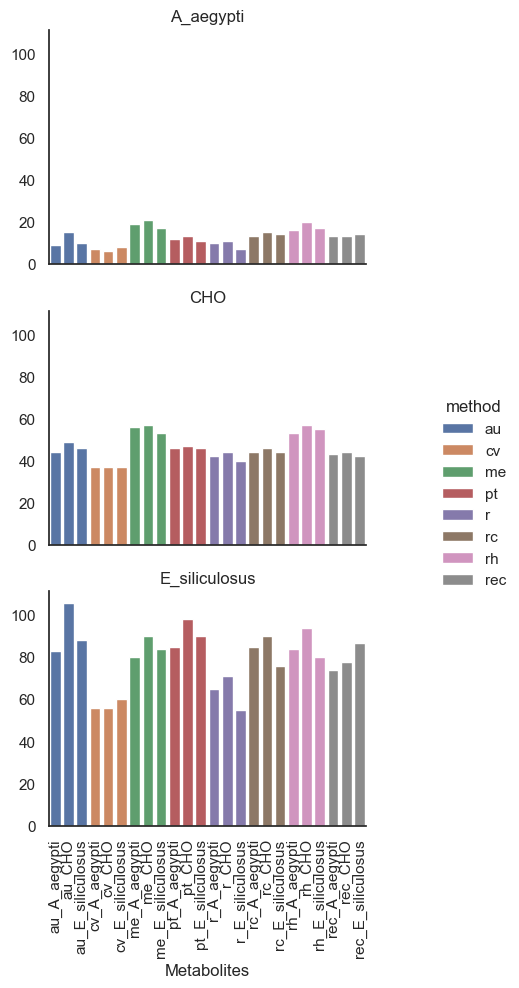

In [46]:
#g = sns.catplot(
#    df_map_spe_mets, kind="bar",
#    x="model", y="metabolites", hue='type', row="organism",
#    height=4, aspect=1.5,
#)
sns.set_theme(style="white", palette="deep")
g = sns.catplot(
    df_map_spe_mets, kind="bar",
    x="model", y="metabolites", hue='method', row="organism",
    height=3, aspect=1.5, dodge=False
)
g.set_axis_labels("Metabolites", "")
g.set_titles("{row_name}")
g.tight_layout()
g.tick_params(axis='x', labelrotation=90)
g.savefig("map_specialized_diff_only.png")
#g.set(ylim=(0, 1))
#g.despine(left=True)

In [90]:
from string import ascii_letters
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

In [91]:
d

A         B         C         D         E         F         G  \
0  -0.318854 -1.602981 -1.535218 -0.570401 -0.216728  0.254874 -0.149450   
1  -1.230374  0.205848  0.821371 -0.493780 -1.408794 -1.216324  1.734299   
2  -0.023842 -0.363738 -0.482943  0.739577  0.611252  0.491802  1.792924   
3  -0.292821  0.856582  0.933473 -0.421045  1.590430 -1.063801  2.104884   
4  -0.587376  1.751572  0.308274 -0.894283 -0.769156  0.869197  0.371381   
..       ...       ...       ...       ...       ...       ...       ...   
95 -1.036298 -1.177101 -2.472118 -0.370044  0.108184 -0.753487 -0.331042   
96 -0.681074  2.203923  1.555724 -0.808559 -1.415792  0.586590  0.393986   
97  0.616011  0.162773 -0.425326  2.040243  0.339979  0.489751  1.030780   
98 -1.268506 -0.815121 -1.670919 -1.103345 -1.348075  0.157345  0.249971   
99  0.719434 -1.451263  0.173934 -0.401525 -0.971152  0.531255  1.649531   

           H         I         J  ...         Q         R         S         T  \
0   2.010783 -0.096784  0.422202  ... -0.951219  0.832973 -1.000208  0.343463   
1  -0.206790 -0.733189  0.774163  ... -0.148826 -0.606270 -1.185801  0.455504   
2  -0.683737  1.054113 -0.615562  ... -1.120717  0.991136  1.630796 -1.900090   
3  -1.090494  1.484521 -1.089229  ...  0.230258  0.195235  0.535839  0.684299   
4  -0.628362 -0.922477 -0.903391  ...  1.519031  0.749896 -2.269087 -0.760599   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  2.203373 -0.319100  0.428793  ... -0.087225  0.190644 -0.506678 -0.442679   
96  0.455118 -0.050184  1.298277  ... -0.607768  0.051741 -1.183910  0.830444   
97  1.061831 -0.040148 -1.406366  ... -1.248445 -0.530126 -0.045328  1.314023   
98  0.581991  0.115223 -0.898088  ...  0.227623 -0.147131  0.692395 -1.308567   
99 -0.252332 -0.903050 -0.773817  ... -0.555178  0.768933  0.101751  0.146673   

           U         V         W         X         Y         Z  
0   1.546030  0.690081 -2.045853  0.334467 -0.641459 -0.222497  
1  -0.837645 -0.146961 -0.682350  1.487670 -1.094711 -1.654707  
2   0.062316  0.479998  0.379609 -1.512245  0.289020  0.095524  
3   2.821279  0.916504  0.150722  0.017747  0.006885  0.329035  
4  -0.955502  0.923951  0.315157  1.340910  0.678992  0.594258  
..       ...       ...       ...       ...       ...       ...  
95 -1.186259  0.743655 -1.842236  0.702369 -0.726212 -0.792110  
96  0.911260 -1.470621 -0.450259 -1.146024 -0.548446 -0.016534  
97 -0.203060  0.767502  2.055105 -0.131154 -1.185281 -0.208766  
98 -1.197288 -1.348862 -1.612158  0.968366 -0.936233 -0.733935  
99  1.483816 -1.319752  0.101646  0.145410 -0.363424  0.937096  

[100 rows x 26 columns]

## Venn diagram type comparison

In [164]:
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)


In [165]:
os.listdir('./to_plot/')

['.DS_Store',
 'carveMe',
 'merlin',
 'modelseed',
 'merlin_nuestro',
 'raven_homo',
 'reconstructor',
 'raven',
 'AuReMe',
 'raven_comb',
 'pathway_tools']

In [20]:
#mega_df['carveMe']['CHO']
methods_to_plot = ['carveMe', 'modelseed','pathway_tools', 'raven_comb', 'curated_models']
#methods_to_plot = ['raven', 'raven_homo', 'raven_comb']#, 'raven_homo']

mega_dict = dict()    
for method in os.listdir('./to_plot/'):
    if len(methods_to_plot) == 0:
            methods_to_plot = os.listdir('./to_plot/')
    if not method.startswith('.'):  
        if method in methods_to_plot:
            method_dict = dict()
            print(method)
            for org in os.listdir('./to_plot/'+method):
                if not org.startswith('.') and ( org.endswith('.xml') or org.endswith('.sbml')):
                    org_dict = dict()
                    print(org)
                    d = cobra.io.read_sbml_model('./to_plot/'+method+'/'+org)
                    org_dict = dict()
                    org_dict['metabolites'] = [m.id for m in d.metabolites]
                    org_dict['reactions'] = [r.id for r in d.reactions]
                    org_dict['genes'] = [g.id for g in d.genes]
                    #print(org_dict)
                    org = org.replace('.xml','')
                    org = org.replace('.sbml','')
                    
                    method_dict[org] = org_dict

            mega_dict[method] = method_dict

curated_models
S_japonica.xml


'' is not a valid SBML 'SId'.


E_siliculosus.xml
CHO.xml
A_aegypti.xml
carveMe
E_siliculosus.xml
CHO.xml
A_aegypti.xml
modelseed
E_siliculosus.xml
CHO.xml
A_aegypti.xml
M_pyrifera.xml


/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '9647706.fgenesh2_kg.23₂TRINITY_DN26574_c2_g1_i3' for <Reaction rxn00048_d0 at 0x7fbe4f353370>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))
/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '(9825993.estExt_fgenesh2_pg.C_340070 or 9511768.fgenesh2_kg.10㋺TRINITY_DN40656_c0_g2_i4)' for <Reaction rxn00076_c0 at 0x7fbe4aeafb20>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))
/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '(9411666.fgenesh2_kg.4༗TRINITY_DN38246_c0_g1_i4 or 1230796.estExt_Genewise1Plus.C_27_t10017 or 8862649.g15477.t1)' for <Reaction rxn00086_c0 at 0x7fbe4f353730>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, rep

/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '(5063177.estExt_Genemark4.C_30_t40045 or 9604977.fgenesh2_kg.19࢘TRINITY_DN16757_c0_g1_i5 or 9444101.fgenesh2_kg.6׶TRINITY_DN489_c0_g3_i1)' for <Reaction rxn02988_d0 at 0x7fbe30fa11f0>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))
/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '((9514985.fgenesh2_kg.11ݦTRINITY_DN615_c0_g1_i41 or 9433477.fgenesh2_kg.5☇TRINITY_DN21643_c1_g1_i8 or 1230168.estExt_Genewise1Plus.C_26_t10402 or 8876945.g16136.t1 or 1234177.estExt_Genewise1Plus.C_33_t10285 or 1170082.e_gw1.19.233.1) or (9514985.fgenesh2_kg.11ݦTRINITY_DN615_c0_g1_i41 or 9433477.fgenesh2_kg.5☇TRINITY_DN21643_c1_g1_i8 or 1230168.estExt_Genewise1Plus.C_26_t10402 or 8876945.g16136.t1 or 1234177.estExt_Genewise1Plus.C_33_t10285 or 1170082.e_gw1.19.233.1))' for 

/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '(9670554.fgenesh2_kg.25≎TRINITY_DN14349_c0_g2_i1 or 8805788.MIX56841_1877_12 or 8860427.g7035.t1 or 9762073.fgenesh2_kg.contig_41੼TRINITY_DN4290_c0_g1_i3)' for <Reaction rxn24348_c0 at 0x7fbe49188df0>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))
/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '(9810672.estExt_fgenesh2_pm.C_280214 or 9746264.fgenesh2_kg.34༟TRINITY_DN3240_c0_g1_i1 or 9819297.estExt_fgenesh2_pg.C_140228 or 8871306.g17093.t1)' for <Reaction rxn25647_d0 at 0x7fbe3acf23d0>
  warn("malformed gene_reaction_rule '%s' for %s" % (new_rule, repr(self)))
/opt/anaconda3/envs/paretoTest2/lib/python3.8/site-packages/cobra/core/reaction.py:438: UserWarning: malformed gene_reaction_rule '((9819297.estExt_fgenesh2_pg.C_140228 or 8871306.g17093.t1 o

raven_comb
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


CHO.xml
A_aegypti.xml
M_pyrifera.xml


No objective coefficients in model. Unclear what should be optimized


pathway_tools
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


CHO.xml


No objective coefficients in model. Unclear what should be optimized


A_aegypti.xml


No objective coefficients in model. Unclear what should be optimized


M_pyrifera.xml


No objective coefficients in model. Unclear what should be optimized


In [21]:
for k in mega_dict.keys():
    print(k)
    print(len(mega_dict[k]))

curated_models
4
carveMe
3
modelseed
4
raven_comb
4
pathway_tools
4


In [22]:
mega_dict['carveMe']

{'E_siliculosus': {'metabolites': ['10fthf_c',
   '12dgr140_c',
   '12dgr140_p',
   '12dgr160_c',
   '12dgr160_p',
   '12dgr161_c',
   '12dgr180_c',
   '12dgr180_p',
   '12dgr181_c',
   '12dgr181_p',
   '12ppd__R_c',
   '12ppd__S_c',
   '13dpg_c',
   '15dap_c',
   '1btol_c',
   '1ddecg3p_c',
   '1hdec9eg3p_c',
   '1p3h5c_c',
   '1pyr5c_c',
   '1tdec7eg3p_c',
   '23dhdp_c',
   '23dhmb_c',
   '23dhmp_c',
   '25aics_c',
   '25dhpp_c',
   '25dkglcn_c',
   '25dkglcn_e',
   '25dkglcn_p',
   '25drapp_c',
   '26dap_LL_c',
   '26dap__M_c',
   '26dap__M_e',
   '26dap__M_p',
   '2agpe120_c',
   '2agpe120_p',
   '2agpe141_c',
   '2agpe141_p',
   '2agpe161_c',
   '2agpe161_p',
   '2agpg120_c',
   '2agpg120_p',
   '2agpg140_c',
   '2agpg140_p',
   '2agpg141_c',
   '2agpg141_p',
   '2agpg160_c',
   '2agpg160_p',
   '2agpg161_c',
   '2agpg161_p',
   '2agpg180_c',
   '2agpg180_p',
   '2agpg181_c',
   '2agpg181_p',
   '2ahbut_c',
   '2ahhmd_c',
   '2ahhmp_c',
   '2amsa_c',
   '2aobut_c',
   '2cpr5p_c',


In [23]:
def get_plot_dict(mega_dict, org, what):
    #mega_dict with all the data
    #org organism to plot
    #what: what is going to be ploted (metabolites, genes, reactions)
    plot_dict = dict()
    for k in mega_dict.keys():
        print(k)
        print(org)
        print(what)

        plot_dict[k] = mega_dict[k][org][what]
    
    return(plot_dict)

In [30]:
plot_dict = get_plot_dict(mega_dict, 'CHO', 'genes') #TO DO: add "curated model" to list

curated_models
CHO
genes
carveMe
CHO
genes
modelseed
CHO
genes
raven_comb
CHO
genes
pathway_tools
CHO
genes


In [32]:
plot_dict['carveMe']

['EGW07470_1',
 'EGW07730_1',
 'EGW00123_1',
 'EGV99305_1',
 'EGW01285_1',
 'EGW12364_1',
 'EGW06556_1',
 'EGW14196_1',
 'EGW03661_1',
 'EGV99221_1',
 'EGW08067_1',
 'EGV97091_1',
 'EGW08065_1',
 'EGV92911_1',
 'EGW04004_1',
 'EGV92923_1',
 'EGW02517_1',
 'EGW08829_1',
 'EGW08831_1',
 'EGW08830_1',
 'EGW05732_1',
 'EGW03299_1',
 'EGW05427_1',
 'EGV97641_1',
 'EGW06288_1',
 'EGV94337_1',
 'spontaneous',
 'EGW10621_1',
 'EGV94920_1',
 'EGW02764_1',
 'EGW11143_1',
 'EGV94516_1',
 'EGV95390_1',
 'EGW08028_1',
 'EGV95477_1',
 'EGV98342_1',
 'EGW08711_1',
 'EGW08874_1',
 'EGW13953_1',
 'EGV97063_1',
 'EGV97360_1',
 'EGW05652_1',
 'EGW04903_1',
 'EGV96337_1',
 'EGW12366_1',
 'EGW00109_1',
 'EGW09769_1',
 'EGW02474_1',
 'EGV98286_1',
 'EGV97216_1',
 'EGV99525_1',
 'EGV98592_1',
 'EGW07674_1',
 'EGV93745_1',
 'EGV98853_1',
 'EGW05467_1',
 'EGW02708_1',
 'EGV93588_1',
 'EGW13933_1',
 'EGW02660_1',
 'EGW10131_1',
 'EGW05607_1',
 'EGW11540_1',
 'EGW08788_1',
 'EGW10407_1',
 'EGV98664_1',
 'EGV9641

In [350]:
plot_dict

#in this particular case carveMe has genes plotted without points

for k in plot_dict.keys():
    plot_dict[k] = [g.replace('GENE_','') for g in plot_dict[k]]
    plot_dict[k] = [g.replace('jgi_Macpyr2_','') for g in plot_dict[k]]
    if "." in plot_dict[k][0]:
        plot_dict[k] = [g.split('.')[0] for g in plot_dict[k]]
    elif "_" in plot_dict[k][0]:
        plot_dict[k] = [g.split('_')[0] for g in plot_dict[k]]
    
    plot_dict[k] = list(set(plot_dict[k]))
    #if k != 'reconstructor':
    #    plot_dict[k] = [g[:-2] for g in plot_dict[k]]
    #remove 'GENE_'    
    

In [351]:
plot_dict

{'carveMe': ['spontaneous', 'XP'],
 'modelseed': ['Unknown'],
 'raven_comb': ['XP_021696403',
  'XP_021705502',
  'XP_021704374',
  'XP_021702040',
  'XP_021710800',
  'XP_021712090',
  'XP_021694239',
  'XP_021693221',
  'XP_001653673',
  'XP_001653614',
  'XP_021699603',
  'XP_001651236',
  'XP_021693110',
  'XP_021694771',
  'XP_021704378',
  'XP_021708641',
  'XP_021701368',
  'XP_021698646',
  'XP_021704425',
  'XP_001652257',
  'XP_021710372',
  'XP_001660206',
  'XP_001662944',
  'XP_001652487',
  'XP_001654275',
  'XP_001658946',
  'XP_021696292',
  'XP_001655635',
  'XP_021695942',
  'XP_021711085',
  'XP_021697547',
  'XP_021710642',
  'XP_021693348',
  'XP_021700233',
  'XP_021709634',
  'XP_001656284',
  'XP_021707072',
  'XP_021710802',
  'XP_021693428',
  'XP_001660862',
  'XP_021711395',
  'XP_021692982',
  'XP_021694331',
  'XP_021698394',
  'XP_021713023',
  'XP_021713264',
  'XP_021697278',
  'XP_021703053',
  'XP_021697746',
  'XP_021702564',
  'XP_001651369',
  'XP_

In [352]:
import upsetplot
from upsetplot import from_contents

In [353]:
#RA_genes, CM_genes, PT_genes
genes = from_contents(plot_dict)


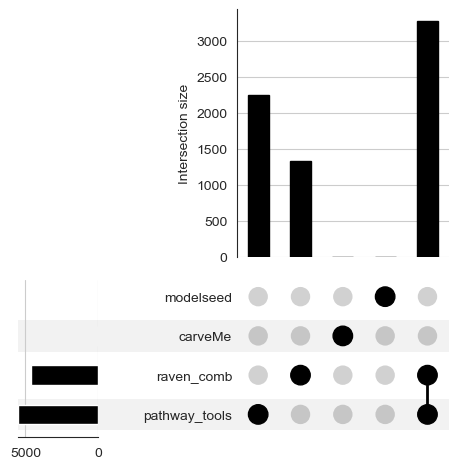

In [354]:
from upsetplot import UpSet

ax_dict = UpSet(genes, subset_size='count', element_size=40).plot()

## Model dataframe data

Load models and compute a dataframe with their data. I will start with defining just a matrix of metabolites present on each model



In [4]:
os.listdir('./to_plot/')

['.DS_Store',
 'carveMe',
 'merlin',
 'modelseed',
 'merlin_nuestro',
 'raven_homo',
 'reconstructor',
 'raven',
 'AuReMe',
 'raven_comb',
 'pathway_tools']

In [5]:
import os
import cobra
import logging

logging.getLogger("cobra").setLevel(logging.ERROR)

In [46]:
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method, example: loaded cobrapy model, metabolite ids

#The idea is that for each method you have access for all the metabolites. The sad thing is that once you
# get the method dict (as a variable) you have no way to know which is that specific method? unless I added 
# that to the info of their specific dicts, just to be sure
compartment_dict = {'cytosol': 'c', 'extracellular':'e', 'CCO__45__OUT': 'CCO-OUT', 'CCO__45__IN': 'CCO-IN'}
#methods = [ 'modelseed',  'reconstructor'] #modelseed

#methods = ['raven', 'raven_homo', 'raven_comb', 'pathway_tools'] #metacyc
methods = ['merlin', 'raven_homo'] #kegg
#methods = ['pathway_tools']
#methods = os.listdir('./to_plot/')
for method in methods:
    if not method.startswith('.'):
        method_dict = dict()
        print(method)
        for org in os.listdir('./to_plot/'+method):
            if not org.startswith('.') and not org.endswith('.json'):
                org_dict = dict()
                print(org)
                #load model cobrapy
                sbml_path = './to_plot/'+method+'/'+org
                model = cobra.io.read_sbml_model(sbml_path) 
                org_dict['model'] = model
                #store list of metabolites and metabolite participation
                met_dict = dict()
                par_dict = dict()
                met_list = model.metabolites
                db_out = 'MNX'#map all models to metanetx
                #Old version, all same DB
                #for met in model.metabolites:
                #    print(met.id)
                #    if met.compartment.startswith('C_'):
                #        comp = met.compartment.replace('C_','')
                #    else:
                #        if len(met.compartment)> 5:
                #            print('comp dict')
                #            comp = compartment_dict[met.compartment]
                #            #I am assuming we are using words?
                #            #TO DO FILTER IF WORDS ARE BEING USED HERE (CYTOSOL, EXTRACELLULAR)
                #       else: 
                #            comp = met.compartment
                #    print(met.compartment)
                #    print(comp)
                    
                #    new_met = met.id.replace('_'+comp,'')
                #    if new_met.endswith('_'):
                #        new_met = new_met[:-1]
                    met_dict[new_met] = 1
                    par_dict[new_met] = len(met.reactions)

                #store list of reactions
                rxn_dict = dict()
                for r in model.reactions:
                    rxn_dict[r.id] = 1


                org_dict['metabolites'] = met_dict
                org_dict['metabolite participation'] = par_dict
                org_dict['reactions'] = rxn_dict
                org_string = org.replace('.xml','')
                org_string = org_string.replace('.sbml','')
                method_dict[org_string] = org_dict

            mega_dict[method] = method_dict
            
           
            

merlin
E_siliculosus.xml
C00114__extr
C_extr
extr
C02646__extr
C_extr
extr
C00072__extr
C_extr
extr
C00052__extr
C_extr
extr
C00249__extr
C_extr
extr
C00079__extr
C_extr
extr
C02325__extr
C_extr
extr
C00590__extr
C_extr
extr
C15805__extr
C_extr
extr
C00002__extr
C_extr
extr
C19691__extr
C_extr
extr
C06098__extr
C_extr
extr
C05422__extr
C_extr
extr
C00704__extr
C_extr
extr
C03692__extr
C_extr
extr
C00015__extr
C_extr
extr
C00011__extr
C_extr
extr
C15804__extr
C_extr
extr
C15777__extr
C_extr
extr
C15604__extr
C_extr
extr
C03461__extr
C_extr
extr
C02505__extr
C_extr
extr
C21754__extr
C_extr
extr
C00097__extr
C_extr
extr
C03798__extr
C_extr
extr
C15807__extr
C_extr
extr
C00080__extr
C_extr
extr
C01609__extr
C_extr
extr
C03715__extr
C_extr
extr
C00001__extr
C_extr
extr
C00017__extr
C_extr
extr
C05212__extr
C_extr
extr
C00027__extr
C_extr
extr
C00007__extr
C_extr
extr
C05360__extr
C_extr
extr
C03633__extr
C_extr
extr
C02729__extr
C_extr
extr
C00067__extr
C_extr
extr
C00132__extr
C_extr
extr


C00370__extr
C_extr
extr
C00029__extr
C_extr
extr
C15577__extr
C_extr
extr
C00016__extr
C_extr
extr
C06429__extr
C_extr
extr
C00831__extr
C_extr
extr
C11508__extr
C_extr
extr
C12455__extr
C_extr
extr
C05400__extr
C_extr
extr
C00147__extr
C_extr
extr
C01081__extr
C_extr
extr
C06124__extr
C_extr
extr
C01678__extr
C_extr
extr
C04398__extr
C_extr
extr
C17324__extr
C_extr
extr
C08492__extr
C_extr
extr
C04943__extr
C_extr
extr
C01019__extr
C_extr
extr
C00780__extr
C_extr
extr
C00011__extr
C_extr
extr
C00662__extr
C_extr
extr
C00121__extr
C_extr
extr
C00003__extr
C_extr
extr
C01416__extr
C_extr
extr
C01724__extr
C_extr
extr
C00024__extr
C_extr
extr
C00257__extr
C_extr
extr
C21925__extr
C_extr
extr
C11173__extr
C_extr
extr
C05946__extr
C_extr
extr
C00244__extr
C_extr
extr
C05713__extr
C_extr
extr
C05147__extr
C_extr
extr
C00388__extr
C_extr
extr
C04825__extr
C_extr
extr
C01432__extr
C_extr
extr
C15610__extr
C_extr
extr
C05726__extr
C_extr
extr
C20190__extr
C_extr
extr
C00037__extr
C_extr
extr


C04317__out
C_out
out
C01262__out
C_out
out
C00051__out
C_out
out
C03836__out
C_out
out
C00079__out
C_out
out
C15587__out
C_out
out
C00234__out
C_out
out
C00318__out
C_out
out
C00082__out
C_out
out
C00550__out
C_out
out
C01132__out
C_out
out
C00181__out
C_out
out
C00350__out
C_out
out
C00395__out
C_out
out
C00504__out
C_out
out
C16138__out
C_out
out
C00135__out
C_out
out
C00535__out
C_out
out
C00019__out
C_out
out
C00149__out
C_out
out
C00065__out
C_out
out
C00020__out
C_out
out
C05791__out
C_out
out
C00704__out
C_out
out
C01876__out
C_out
out
C00036__out
C_out
out
C01563__out
C_out
out
C05993__out
C_out
out
C00236__out
C_out
out
C05512__out
C_out
out
C00735__out
C_out
out
C00916__out
C_out
out
C00116__out
C_out
out
C08362__out
C_out
out
C00477__out
C_out
out
C06426__out
C_out
out
C15672__out
C_out
out
C05726__out
C_out
out
C02191__out
C_out
out
C01977__out
C_out
out
C00121__out
C_out
out
C00003__out
C_out
out
C01802__out
C_out
out
C01530__out
C_out
out
C00263__out
C_out
out
C00203__ou

C15602__extr
C_extr
extr
C00167__extr
C_extr
extr
C00350__extr
C_extr
extr
C00187__extr
C_extr
extr
C00114__extr
C_extr
extr
C00049__extr
C_extr
extr
C00029__extr
C_extr
extr
C00009__extr
C_extr
extr
C03082__extr
C_extr
extr
C00720__extr
C_extr
extr
C00740__extr
C_extr
extr
C00695__extr
C_extr
extr
C01595__extr
C_extr
extr
C02872__extr
C_extr
extr
C00310__extr
C_extr
extr
C19691__extr
C_extr
extr
C00147__extr
C_extr
extr
C14819__extr
C_extr
extr
C00584__extr
C_extr
extr
C01165__extr
C_extr
extr
C00328__extr
C_extr
extr
C00376__extr
C_extr
extr
C00181__extr
C_extr
extr
C00051__extr
C_extr
extr
C00406__extr
C_extr
extr
C09762__extr
C_extr
extr
C00258__extr
C_extr
extr
C01019__extr
C_extr
extr
C00031__extr
C_extr
extr
C00011__extr
C_extr
extr
C02990__extr
C_extr
extr
C01197__extr
C_extr
extr
C00121__extr
C_extr
extr
C15493__extr
C_extr
extr
C00043__extr
C_extr
extr
C06561__extr
C_extr
extr
C01724__extr
C_extr
extr
C00024__extr
C_extr
extr
C14818__extr
C_extr
extr
C04501__extr
C_extr
extr


No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00069
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s

No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00069
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s

No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s
C00106
s
s

No objective coefficients in model. Unclear what should be optimized


C00001
s
s
C00002
s
s
C00003
s
s
C00004
s
s
C00005
s
s
C00006
s
s
C00007
s
s
C00008
s
s
C00009
s
s
C00010
s
s
C00011
s
s
C00012
s
s
C00013
s
s
C00014
s
s
C00015
s
s
C00016
s
s
C00017
s
s
C00018
s
s
C00019
s
s
C00020
s
s
C00021
s
s
C00022
s
s
C00024
s
s
C00025
s
s
C00026
s
s
C00027
s
s
C00028
s
s
C00029
s
s
C00030
s
s
C00031
s
s
C00032
s
s
C00033
s
s
C00035
s
s
C00036
s
s
C00037
s
s
C00040
s
s
C00041
s
s
C00042
s
s
C00043
s
s
C00044
s
s
C00045
s
s
C00047
s
s
C00048
s
s
C00049
s
s
C00051
s
s
C00052
s
s
C00053
s
s
C00054
s
s
C00055
s
s
C00058
s
s
C00059
s
s
C00060
s
s
C00061
s
s
C00062
s
s
C00063
s
s
C00064
s
s
C00065
s
s
C00067
s
s
C00068
s
s
C00069
s
s
C00071
s
s
C00072
s
s
C00073
s
s
C00074
s
s
C00075
s
s
C00077
s
s
C00078
s
s
C00079
s
s
C00080
s
s
C00081
s
s
C00082
s
s
C00083
s
s
C00084
s
s
C00085
s
s
C00086
s
s
C00087
s
s
C00088
s
s
C00089
s
s
C00091
s
s
C00092
s
s
C00093
s
s
C00094
s
s
C00095
s
s
C00096
s
s
C00097
s
s
C00099
s
s
C00100
s
s
C00101
s
s
C00103
s
s
C00104
s
s
C00105
s
s

In [ ]:

prefix = {'modelseed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven_homo': 'rh_', 'raven_comb': 'rc_', 
         'pathway_tools': 'pt_', 'merlin': 'me_'}
df_dict = dict()
for m in methods:
    method_dict = mega_dict[m]
    for org in method_dict.keys():
        this_org = method_dict[org]
        df_dict[prefix[m]+org] = this_org['metabolites']
        #df_dict[org] = this_org['reactions']

In [ ]:
df = pd.DataFrame.from_dict(df_dict).fillna(0)#.transpose()
to_remove = df[(df[df.columns]==1).all(axis=1)].index
#to_remove = df[(df[df.columns]>100).all(axis=1)].index

In [ ]:
df.drop(to_remove, axis=0, inplace=True)

In [ ]:
df

In [11]:
###Get files to curate mapping manually
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method, example: loaded cobrapy model, metabolite ids

#The idea is that for each method you have access for all the metabolites. The sad thing is that once you
# get the method dict (as a variable) you have no way to know which is that specific method? unless I added 
# that to the info of their specific dicts, just to be sure
#methods = [ 'modelseed',  'reconstructor'] #modelseed

#methods = ['raven', 'raven_homo', 'raven_comb', 'pathway_tools'] #metacyc
#methods = ['merlin', 'raven_homo'] #kegg
#BANANA
#methods = ['raven_homo']
#methods = ['pathway_tools']
#met
#methods = os.listdir('./to_plot/')
#con too si no pa que
methods = ['AuReMe', 'carveMe',
 'merlin',
 'modelseed', 'raven_homo',
 'reconstructor',
 'raven',
 'raven_comb',
 'pathway_tools']
#methods=['carveMe']

db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"]}
for method in methods:
    if not method.startswith('.'):
        method_dict = dict()
        print(method)
        for org in os.listdir('./to_plot/'+method):
            if not org.startswith('.') and not org.endswith('.json') and not org.startswith('~$'):
                org_dict = dict()
                if not org.startswith('M_pyrifera'):
                    print(org)
                    #load model cobrapy
                    sbml_path = './to_plot/'+method+'/'+org
                    model = cobra.io.read_sbml_model(sbml_path) 
                    org_dict['model'] = model
                    #store list of metabolites and metabolite participation
                    met_dict = dict()
                    par_dict = dict()
                    met_list = [m.id for m in model.metabolites]
                    db_out = 'MNX'#map all models to metanetx
                    
                    for this_db in db_dict[method]:
                        map_dict = map_metabolites(met_list, sbml_path, this_db, db_out, mnx_only=False)
                    
                        for m in map_dict.keys():
                            met_dict[map_dict[m]] = 1
                    #par_dict[new_met] = len(met.reactions)
    
                    #store list of reactions
                    #rxn_dict = dict()
                    #for r in model.reactions:
                    #    rxn_dict[r.id] = 1
    
    
                    org_dict['metabolites'] = met_dict
                    #org_dict['metabolite participation'] = par_dict
                    #org_dict['reactions'] = rxn_dict
                    org_string = org.replace('.xml','')
                    org_string = org_string.replace('.sbml','')
                    method_dict[org_string] = org_dict

            mega_dict[method] = method_dict
            
           
            

AuReMe
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c          NaN   
2                                    M_10fthfglu_L_c          NaN   
3                                    M_10fthfglu_L_m          NaN   
4                                         M_10fthf_h          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c                
2                                    M_10fthfglu_L_c                
3                                    M_10fthfglu_L_m                
4                                         M_10fthf_h                

                         metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1                                                                          
2                                                                          
3                                                                          
4           

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...          NaN   
1                                         M_10fthf_c  MNXM1102376   
2                                    M_10fthfglu_L_c   MNXM164047   
3                                    M_10fthfglu_L_m          NaN   
4                                         M_10fthf_h          NaN   

           bigg    metacyc_mnx kegg_mnx modelseed_mnx Modelseed_DB  
0           NaN            NaN      NaN           NaN          NaN  
1        10fthf  10-FORMYL-THF   C00234      cpd00201     cpd00201  
2  10fthfglu__L            NaN      NaN           NaN     cpd03524  
3           NaN            NaN      NaN           NaN          NaN  
4           NaN            NaN      NaN        

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                normalized_id  \
0  10formyldihydrofolateglunc   
1                     10fthfc   
2                 10fthfglulc   
3                 10fthfglulm   
4                     10fthfh   

                                         original_id MNX kegg bigg_mnx  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...                     
1                                         M_10fthf_c                     
2                                    M_10fthfglu_L_c                     
3                                    M_10fthfglu_L_m                     
4                                         M_10fthf_h                     

  metacyc_mnx modelseed_mnx bigg_DB Modelseed_DB  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN  
adding name and formula
                normalized

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id MNX modelseed bigg_mnx  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...                          
1                                         M_10fthf_c                          
2                                    M_10fthfglu_L_c                          
3                                    M_10fthfglu_L_m                          
4                                         M_10fthf_h                          

  metacyc_mnx kegg_mnx bigg_DB name formula  
0                                            
1                                            
2                                            
3                                            
4                                            
fuzzy meta
               normalized_id  \
0  10formyldi

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                     10fthf   
3                 10fthf5glu   
4                 10fthf5glu   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c          NaN   
2                                         M_10fthf_e          NaN   
3                                     M_10fthf5glu_c          NaN   
4                                     M_10fthf5glu_e          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                     10fthf   
3                 10fthf5glu   
4                 10fthf5glu   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c                
2                                         M_10fthf_e                
3                                     M_10fthf5glu_c                
4                                     M_10fthf5glu_e                

                         metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1                                                                          
2                                                                          
3                                                                          
4           

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                     10fthf   
3                 10fthf5glu   
4                 10fthf5glu   

                                         original_id          MNX        bigg  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...          NaN         NaN   
1                                         M_10fthf_c  MNXM1102376      10fthf   
2                                         M_10fthf_e  MNXM1102376      10fthf   
3                                     M_10fthf5glu_c     MNXM3428  10fthf5glu   
4                                     M_10fthf5glu_e     MNXM3428  10fthf5glu   

     metacyc_mnx kegg_mnx modelseed_mnx Modelseed_DB  
0            NaN      NaN           NaN          NaN  
1  10-FORMYL-THF   C00234      cpd00201     cpd00201  
2  10-FORMYL-THF   C00234      cpd00201     cpd00201  
3            NaN      NaN           NaN          NaN  
4            NaN      NaN           NaN      

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                normalized_id  \
0  10formyldihydrofolateglunc   
1                 10fthf5gluc   
2                 10fthf5glue   
3                 10fthf5glum   
4                 10fthf6gluc   

                                         original_id MNX kegg bigg_mnx  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...                     
1                                     M_10fthf5glu_c                     
2                                     M_10fthf5glu_e                     
3                                     M_10fthf5glu_m                     
4                                     M_10fthf6glu_c                     

  metacyc_mnx modelseed_mnx bigg_DB Modelseed_DB  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN  
adding name and formula
                normalized

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthf5glu   
3                10fthf5glue   
4                10fthf5glum   

                                         original_id MNX modelseed bigg_mnx  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...                          
1                                         M_10fthf_c                          
2                                     M_10fthf5glu_c                          
3                                     M_10fthf5glu_e                          
4                                     M_10fthf5glu_m                          

  metacyc_mnx kegg_mnx bigg_DB name formula  
0                                            
1                                            
2                                            
3                                            
4                                            
fuzzy meta
               normalized_id  \
0  10formyldi

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1    12dglucosyl5dgalactosyloxyllys   
2                    12diglycerides   
3  12dipalmitoylphosphatidylcholine   
4                   13alphadglucans   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...     MNXM4937   
2                     M_1__45__2__45__Diglycerides_c    MNXM96050   
3   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c    MNXM32122   
4        M_1__45__3__45__alpha__45__D__45__Glucans_c   MNXM733732   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  
0

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                      normalized_id  \
0         10formyldihydrofolateglun   
1    12dglucosyl5dgalactosyloxyllys   
2                    12diglycerides   
3  12dipalmitoylphosphatidylcholine   
4                   13alphadglucans   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...     MNXM4937   
2                     M_1__45__2__45__Diglycerides_c    MNXM96050   
3   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c    MNXM32122   
4        M_1__45__3__45__alpha__45__D__45__Glucans_c   MNXM733732   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  \
0          10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705   
1  12-D-GLUCOSYL-5-D-GALACTOSYLOXY-L-LYS                                   
2                       1-2-Diglycerides                                   
3     1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE      

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                      normalized_id  \
0         10formyldihydrofolateglun   
1    12dglucosyl5dgalactosyloxyllys   
2                    12diglycerides   
3  12dipalmitoylphosphatidylcholine   
4                   13alphadglucans   

                                         original_id  MNX bigg metacyc_mnx  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  NaN  NaN         NaN   
1  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...  NaN  NaN         NaN   
2                     M_1__45__2__45__Diglycerides_c  NaN  NaN         NaN   
3   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c  NaN  NaN         NaN   
4        M_1__45__3__45__alpha__45__D__45__Glucans_c  NaN  NaN         NaN   

  kegg_mnx modelseed_mnx Modelseed_DB  
0      NaN           NaN          NaN  
1      NaN           NaN          NaN  
2      NaN           NaN          NaN  
3      NaN           NaN          NaN  
4      NaN           NaN          NaN  
adding name and formula
                      normalized

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                       normalized_id  \
0         10formyldihydrofolateglunc   
1    12dglucosyl5dgalactosyloxyllysc   
2                    12diglyceridesc   
3  12dipalmitoylphosphatidylcholinec   
4                   13alphadglucansc   

                                         original_id MNX kegg bigg_mnx  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...                     
1  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...                     
2                     M_1__45__2__45__Diglycerides_c                     
3   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c                     
4        M_1__45__3__45__alpha__45__D__45__Glucans_c                     

  metacyc_mnx modelseed_mnx bigg_DB Modelseed_DB  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN  
adding n

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


                      normalized_id  \
0         10formyldihydrofolateglun   
1    12dglucosyl5dgalactosyloxyllys   
2                    12diglycerides   
3  12dipalmitoylphosphatidylcholine   
4                   13alphadglucans   

                                         original_id MNX modelseed bigg_mnx  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...                          
1  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...                          
2                     M_1__45__2__45__Diglycerides_c                          
3   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c                          
4        M_1__45__3__45__alpha__45__D__45__Glucans_c                          

  metacyc_mnx kegg_mnx bigg_DB name formula  
0                                            
1                                            
2                                            
3                                            
4                                            
fuzzy meta
   

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id   original_id          MNX      bigg    metacyc_mnx kegg_mnx  \
0        10fthf    M_10fthf_c  MNXM1102376    10fthf  10-FORMYL-THF   C00234   
1      12dgr140  M_12dgr140_c     MNXM2902  12dgr140            NaN      NaN   
2      12dgr140  M_12dgr140_p     MNXM2902  12dgr140            NaN      NaN   
3      12dgr160  M_12dgr160_c     MNXM3132  12dgr160       CPD66-34      NaN   
4      12dgr160  M_12dgr160_p     MNXM3132  12dgr160       CPD66-34      NaN   

  modelseed_mnx Modelseed_DB  
0      cpd00201     cpd00201  
1      cpd15307     cpd15307  
2      cpd15307     cpd15307  
3      cpd26605     cpd15309  
4      cpd26605     cpd15309  
adding name and formula
  normalized_id   original_id          MNX      bigg    metacyc_mnx kegg_mnx  \
0        10fthf    M_10fthf_c  MNXM1102376    10fthf  10-FORMYL-THF   C00234   
1      12dgr140  M_12dgr140_c     MNXM2902  12dgr140            NaN      NaN   
2      12dgr140  M_12dgr140_p     MNXM2902  12dgr140            NaN  

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id   original_id          MNX      bigg    metacyc_mnx kegg_mnx  \
0        10fthf    M_10fthf_c  MNXM1102376    10fthf  10-FORMYL-THF   C00234   
1      12dgr141  M_12dgr141_c     MNXM4940  12dgr141            NaN      NaN   
2      12dgr141  M_12dgr141_p     MNXM4940  12dgr141            NaN      NaN   
3        12ppdr  M_12ppd__R_c    MNXM90191  12ppd__R       CPD-8891   C02912   
4        12ppdr  M_12ppd__R_e    MNXM90191  12ppd__R       CPD-8891   C02912   

  modelseed_mnx Modelseed_DB  
0      cpd00201     cpd00201  
1      cpd15308     cpd15308  
2      cpd15308     cpd15308  
3      cpd01861     cpd01861  
4      cpd01861     cpd01861  
adding name and formula
  normalized_id   original_id          MNX      bigg    metacyc_mnx kegg_mnx  \
0        10fthf    M_10fthf_c  MNXM1102376    10fthf  10-FORMYL-THF   C00234   
1      12dgr141  M_12dgr141_c     MNXM4940  12dgr141            NaN      NaN   
2      12dgr141  M_12dgr141_p     MNXM4940  12dgr141            NaN  

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id   original_id          MNX      bigg       metacyc_mnx  \
0        10fthf    M_10fthf_c  MNXM1102376    10fthf     10-FORMYL-THF   
1        12ppdr  M_12ppd__R_c    MNXM90191  12ppd__R          CPD-8891   
2        12ppds  M_12ppd__S_c     MNXM1255  12ppd__S  PROPANE-1-2-DIOL   
3         13dpg     M_13dpg_c  MNXM1108073     13dpg               DPG   
4      1ddecg3p  M_1ddecg3p_c  MNXM1103432  1ddecg3p         CPD0-2200   

  kegg_mnx modelseed_mnx Modelseed_DB  
0   C00234      cpd00201     cpd00201  
1   C02912      cpd01861     cpd01861  
2   C02917      cpd19024     cpd19024  
3   C00236      cpd00203     cpd00203  
4      NaN      cpd15325     cpd15325  
adding name and formula
  normalized_id   original_id          MNX      bigg       metacyc_mnx  \
0        10fthf    M_10fthf_c  MNXM1102376    10fthf     10-FORMYL-THF   
1        12ppdr  M_12ppd__R_c    MNXM90191  12ppd__R          CPD-8891   
2        12ppds  M_12ppd__S_c     MNXM1255  12ppd__S  PROPANE-1-2-DIO

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id      original_id    MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001   M_C00001__extr  WATER  C00001      h2o       WATER   
1        c00001  M_C00001__cytop  WATER  C00001      h2o       WATER   
2        c00001   M_C00001__mito  WATER  C00001      h2o       WATER   
3        c00001   M_C00001__chlo  WATER  C00001      h2o       WATER   
4        c00001   M_C00001__nucl  WATER  C00001      h2o       WATER   

  modelseed_mnx bigg_DB Modelseed_DB  
0      cpd00001             cpd00001  
1      cpd00001             cpd00001  
2      cpd00001             cpd00001  
3      cpd00001             cpd00001  
4      cpd00001             cpd00001  
adding name and formula
  normalized_id      original_id    MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001   M_C00001__extr  WATER  C00001      h2o       WATER   
1        c00001  M_C00001__cytop  WATER  C00001      h2o       WATER   
2        c00001   M_C00001__mito  WATER  C00001      h2o       WATER   
3        c00001   M_C

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id      original_id    MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001   M_C00001__extr  WATER  C00001      h2o       WATER   
1        c00001  M_C00001__cytop  WATER  C00001      h2o       WATER   
2        c00001   M_C00001__mito  WATER  C00001      h2o       WATER   
3        c00001   M_C00001__nucl  WATER  C00001      h2o       WATER   
4        c00001   M_C00001__vacu  WATER  C00001      h2o       WATER   

  modelseed_mnx bigg_DB Modelseed_DB  
0      cpd00001             cpd00001  
1      cpd00001             cpd00001  
2      cpd00001             cpd00001  
3      cpd00001             cpd00001  
4      cpd00001             cpd00001  
adding name and formula
  normalized_id      original_id    MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001   M_C00001__extr  WATER  C00001      h2o       WATER   
1        c00001  M_C00001__cytop  WATER  C00001      h2o       WATER   
2        c00001   M_C00001__mito  WATER  C00001      h2o       WATER   
3        c00001   M_C

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id    original_id MNX kegg bigg_mnx metacyc_mnx modelseed_mnx  \
0     c04317out  M_C04317__out                                               
1     c01262out  M_C01262__out                                               
2     c00051out  M_C00051__out                                               
3     c03836out  M_C03836__out                                               
4     c00079out  M_C00079__out                                               

  bigg_DB Modelseed_DB  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
adding name and formula
  normalized_id    original_id MNX kegg bigg_mnx metacyc_mnx modelseed_mnx  \
0     c04317out  M_C04317__out                                               
1     c01262out  M_C01262__out                                               
2     c00051out  M_C00051__out                                               
3     c03836out  M_C03836__out               

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


  normalized_id    original_id    MNX modelseed bigg_mnx metacyc_mnx kegg_mnx  \
0      cpd00001  M_cpd00001_c0  WATER  cpd00001      h2o       WATER   C00001   
1      cpd00001  M_cpd00001_d0  WATER  cpd00001      h2o       WATER   C00001   
2      cpd00001  M_cpd00001_g0  WATER  cpd00001      h2o       WATER   C00001   
3      cpd00001  M_cpd00001_v0  WATER  cpd00001      h2o       WATER   C00001   
4      cpd00001  M_cpd00001_w0  WATER  cpd00001      h2o       WATER   C00001   

  bigg_DB name formula  
0          H2O     H2O  
1          H2O     H2O  
2          H2O     H2O  
3          H2O     H2O  
4          H2O     H2O  
fuzzy meta
Identificadores agregados para D-fructose-6-phosphate - C6H11O9P: ['CPD-18719']
Identificadores agregados para D-fructose-6-phosphate - C6H11O9P: ['CPD-18719']
Identificadores agregados para Glyceraldehyde3-phosphate - C3H5O6P: ['CPD0-2032', 'L-GLYCERALDEHYDE-3-PHOSPHATE']
Identificadores agregados para Glyceraldehyde3-phosphate - C3H5O6P: ['CPD0-203

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


  normalized_id    original_id    MNX modelseed bigg_mnx metacyc_mnx kegg_mnx  \
0      cpd00001  M_cpd00001_c0  WATER  cpd00001      h2o       WATER   C00001   
1      cpd00001  M_cpd00001_d0  WATER  cpd00001      h2o       WATER   C00001   
2      cpd00001  M_cpd00001_g0  WATER  cpd00001      h2o       WATER   C00001   
3      cpd00001  M_cpd00001_v0  WATER  cpd00001      h2o       WATER   C00001   
4      cpd00001  M_cpd00001_w0  WATER  cpd00001      h2o       WATER   C00001   

  bigg_DB name formula  
0          H2O     H2O  
1          H2O     H2O  
2          H2O     H2O  
3          H2O     H2O  
4          H2O     H2O  
fuzzy meta
Identificadores agregados para D-fructose-6-phosphate - C6H11O9P: ['CPD-18719']
Identificadores agregados para D-fructose-6-phosphate - C6H11O9P: ['CPD-18719']
Identificadores agregados para Glyceraldehyde3-phosphate - C3H5O6P: ['CPD0-2032', 'L-GLYCERALDEHYDE-3-PHOSPHATE']
Identificadores agregados para Glyceraldehyde3-phosphate - C3H5O6P: ['CPD0-203

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


  normalized_id    original_id    MNX modelseed bigg_mnx metacyc_mnx kegg_mnx  \
0      cpd00001  M_cpd00001_c0  WATER  cpd00001      h2o       WATER   C00001   
1      cpd00001  M_cpd00001_d0  WATER  cpd00001      h2o       WATER   C00001   
2      cpd00001  M_cpd00001_g0  WATER  cpd00001      h2o       WATER   C00001   
3      cpd00001  M_cpd00001_v0  WATER  cpd00001      h2o       WATER   C00001   
4      cpd00001  M_cpd00001_w0  WATER  cpd00001      h2o       WATER   C00001   

  bigg_DB name formula  
0          H2O     H2O  
1          H2O     H2O  
2          H2O     H2O  
3          H2O     H2O  
4          H2O     H2O  
fuzzy meta
Identificadores agregados para D-fructose-6-phosphate - C6H11O9P: ['CPD-18719']
Identificadores agregados para D-fructose-6-phosphate - C6H11O9P: ['CPD-18719']
Identificadores agregados para Glyceraldehyde3-phosphate - C3H5O6P: ['CPD0-2032', 'L-GLYCERALDEHYDE-3-PHOSPHATE']
Identificadores agregados para Glyceraldehyde3-phosphate - C3H5O6P: ['CPD0-203

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
bigg map
mapping modelseed


/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  bigg_DB Modelseed_DB  
0      cpd00001              cpd00001  
1      cpd00002    atp_c     cpd00002  
2      cpd00003    nad_c     cpd00003  
3      cpd00004   nadh_c     cpd00004  
4      cpd00005  nadph_c     cpd00005  
adding name and formula
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
bigg map
mapping modelseed


/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  bigg_DB Modelseed_DB  
0      cpd00001              cpd00001  
1      cpd00002    atp_c     cpd00002  
2      cpd00003    nad_c     cpd00003  
3      cpd00004   nadh_c     cpd00004  
4      cpd00005  nadph_c     cpd00005  
adding name and formula
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
bigg map
mapping modelseed


/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  bigg_DB Modelseed_DB  
0      cpd00001              cpd00001  
1      cpd00002    atp_c     cpd00002  
2      cpd00003    nad_c     cpd00003  
3      cpd00004   nadh_c     cpd00004  
4      cpd00005  nadph_c     cpd00005  
adding name and formula
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


  normalized_id   original_id         MNX modelseed bigg_mnx metacyc_mnx  \
0      cpd00005  M_cpd00005_c  MNXM738702  cpd00005    nadph       NADPH   
1      cpd00067  M_cpd00067_c       MNXM1  cpd00067        h      PROTON   
2      cpd03387  M_cpd03387_c    MNXM1157  cpd03387     slnt    SELENITE   
3      cpd00001  M_cpd00001_c       WATER  cpd00001      h2o       WATER   
4      cpd00006  M_cpd00006_c       MNXM5  cpd00006     nadp        NADP   

  kegg_mnx  bigg_DB name formula  
0   C00005  nadph_c               
1   C00080      h_c               
2   C05684   slnt_c               
3   C00001                        
4   C00006   nadp_c               
fuzzy meta
  normalized_id   original_id         MNX modelseed bigg_mnx metacyc_mnx  \
0      cpd00005  M_cpd00005_c  MNXM738702  cpd00005    nadph       NADPH   
1      cpd00067  M_cpd00067_c       MNXM1  cpd00067        h      PROTON   
2      cpd03387  M_cpd03387_c    MNXM1157  cpd03387     slnt    SELENITE   
3      cpd00001  M

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


  normalized_id   original_id         MNX modelseed bigg_mnx      metacyc_mnx  \
0      cpd11735  M_cpd11735_c  MNXM727744  cpd11735                             
1      cpd11657  M_cpd11657_c  MNXM725905  cpd11657                             
2      cpd00004  M_cpd00004_c      MNXM10  cpd00004     nadh             NADH   
3      cpd00007  M_cpd00007_c  MNXM735438  cpd00007       o2  OXYGEN-MOLECULE   
4      cpd00067  M_cpd00067_c       MNXM1  cpd00067        h           PROTON   

  kegg_mnx bigg_DB name formula  
0                                
1                                
2   C00004  nadh_c               
3   C00007    o2_c               
4   C00080     h_c               
fuzzy meta
  normalized_id   original_id         MNX modelseed bigg_mnx      metacyc_mnx  \
0      cpd11735  M_cpd11735_c  MNXM727744  cpd11735                             
1      cpd11657  M_cpd11657_c  MNXM725905  cpd11657                             
2      cpd00004  M_cpd00004_c      MNXM10  cpd00004    

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:280: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(path_ms_db, sep='\t')


  normalized_id   original_id          MNX modelseed bigg_mnx     metacyc_mnx  \
0      cpd00006  M_cpd00006_c        MNXM5  cpd00006     nadp            NADP   
1      cpd00130  M_cpd00130_c  MNXM1107192  cpd00130   mal__L             MAL   
2      cpd00005  M_cpd00005_c   MNXM738702  cpd00005    nadph           NADPH   
3      cpd00011  M_cpd00011_c       MNXM13  cpd00011      co2  CARBON-DIOXIDE   
4      cpd00020  M_cpd00020_c       MNXM23  cpd00020      pyr        PYRUVATE   

  kegg_mnx   bigg_DB name formula  
0   C00006    nadp_c               
1   C00149  mal__L_c               
2   C00005   nadph_c               
3   C00011     co2_e               
4   C00022     pyr_e               
fuzzy meta
  normalized_id   original_id          MNX modelseed bigg_mnx     metacyc_mnx  \
0      cpd00006  M_cpd00006_c        MNXM5  cpd00006     nadp            NADP   
1      cpd00130  M_cpd00130_c  MNXM1107192  cpd00130   mal__L             MAL   
2      cpd00005  M_cpd00005_c   MNXM738702 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1            11z3oxoicos11enoylacps   
2  12dipalmitoylphosphatidylcholine   
3             1516dihydrobiliverdin   
4       16srrna2omethylcytidine1402   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
2     M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE    MNXM32122   
3                      M_1516__45__DIHYDROBILIVERDIN     MNXM3138   
4  M_16S__45__rRNA__45__2__45__O__45__methylcytid...    MNXM14023   

                              metacyc bigg_mnx kegg_mnx modelseed_mnx  
0   

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                      normalized_id  \
0         10formyldihydrofolateglun   
1            11z3oxoicos11enoylacps   
2  12dipalmitoylphosphatidylcholine   
3             1516dihydrobiliverdin   
4       16srrna2omethylcytidine1402   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
2     M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE    MNXM32122   
3                      M_1516__45__DIHYDROBILIVERDIN     MNXM3138   
4  M_16S__45__rRNA__45__2__45__O__45__methylcytid...    MNXM14023   

                              metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0       10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1        11Z-3-oxo-icos-11-enoyl-ACPs                        cpd37266           
2  1-2-DIPALMITOYLPHOSPHATIDYLCHOLINE                        cpd21748           
3              1516-DIHYDR

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
            normalized_id                             original_id         MNX  \
0  11betahydroxysteroids1    M_11__45__Beta__45__Hydroxysteroids1   MNXM10699   
1      11cisretinylesters  M_11__45__Cis__45__Retinyl__45__Esters    MNXM9666   
2        11cretinalralbps          M_11C__45__Retinal__45__RALBPs    MNXM9675   
3        11cretinolralbps          M_11C__45__Retinol__45__RALBPs    MNXM9676   
4   11deoxycorticosterone           M_11__45__DEOXYCORTICOSTERONE  MNXM730534   

                    metacyc     bigg_mnx kegg_mnx modelseed_mnx  
0  11-Beta-Hydroxysteroids1          NaN   C01058      cpd21788  
1     11-Cis-Retinyl-Esters          NaN      NaN      cpd21789  
2        11C-Retinal-RALBPs          NaN 

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


            normalized_id                             original_id         MNX  \
0  11betahydroxysteroids1    M_11__45__Beta__45__Hydroxysteroids1   MNXM10699   
1      11cisretinylesters  M_11__45__Cis__45__Retinyl__45__Esters    MNXM9666   
2        11cretinalralbps          M_11C__45__Retinal__45__RALBPs    MNXM9675   
3        11cretinolralbps          M_11C__45__Retinol__45__RALBPs    MNXM9676   
4   11deoxycorticosterone           M_11__45__DEOXYCORTICOSTERONE  MNXM730534   

                    metacyc     bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  11-Beta-Hydroxysteroids1                C01058      cpd21788           
1     11-Cis-Retinyl-Esters                            cpd21789           
2        11C-Retinal-RALBPs                            cpd21795           
3        11C-Retinol-RALBPs                            cpd21796           
4    11-DEOXYCORTICOSTERONE  11docrtstrn   C03205      cpd02047           

  Modelseed_DB  
0     cpd21788  
1     cpd21789  
2     cpd21

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                    normalized_id  \
0        11cis3hydroxyretinalrbps   
1        11cis3hydroxyretinolrbps   
2                11cretinalralbps   
3                11cretinolralbps   
4  12dglucosyl5dgalactosyloxyllys   

                                         original_id        MNX  \
0  M_11__45__cis__45__3__45__hydroxyretinal__45__...  MNXM97445   
1  M_11__45__cis__45__3__45__hydroxyretinol__45__...  MNXM97446   
2                     M_11C__45__Retinal__45__RALBPs   MNXM9675   
3                     M_11C__45__Retinol__45__RALBPs   MNXM9676   
4  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...   MNXM4937   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  
0           11-cis-3-hydr

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                    normalized_id  \
0        11cis3hydroxyretinalrbps   
1        11cis3hydroxyretinolrbps   
2                11cretinalralbps   
3                11cretinolralbps   
4  12dglucosyl5dgalactosyloxyllys   

                                         original_id        MNX  \
0  M_11__45__cis__45__3__45__hydroxyretinal__45__...  MNXM97445   
1  M_11__45__cis__45__3__45__hydroxyretinol__45__...  MNXM97446   
2                     M_11C__45__Retinal__45__RALBPs   MNXM9675   
3                     M_11C__45__Retinol__45__RALBPs   MNXM9676   
4  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...   MNXM4937   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  \
0           11-cis-3-hydroxyretinal-RBPs                        cpd21792   
1           11-cis-3-hydroxyretinol-RBPs                        cpd21793   
2                     11C-Retinal-RALBPs                        cpd21795   
3                     11C-Retinol-RALBPs                        cpd217

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1      11deoxycorticosterone   
2     11z3oxoicos11enoylacps   
3                     124tcb   
4            12dibromoethane   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                      M_11__45__DEOXYCORTICOSTERONE   MNXM730534   
2  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
3                                     M_124__45__TCB     MNXM4214   
4                            M_12__45__DIBROMOETHANE     MNXM6026   

                         metacyc     bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N          NaN  

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1      11deoxycorticosterone   
2     11z3oxoicos11enoylacps   
3                     124tcb   
4            12dibromoethane   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                      M_11__45__DEOXYCORTICOSTERONE   MNXM730534   
2  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
3                                     M_124__45__TCB     MNXM4214   
4                            M_12__45__DIBROMOETHANE     MNXM6026   

                         metacyc     bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  10-FORMYL-DIHYDROFOLATE-GLU-N                            cpd36705           
1         11-DEOXYCORTICOSTERONE  11docrtstrn   C03205      cpd02047           
2   11Z-3-oxo-icos-11-enoyl-ACPs                            cpd37266           
3                        124-TCB                C06594      cpd03998    

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


                      normalized_id  \
0                  5oxo12campholide   
1                           menthol   
2  12dipalmitoylphosphatidylcholine   
3                17dimethylxanthine   
4             1alkenyl2acylglycerol   

                                         original_id MNX kegg bigg_mnx  \
0  M___43____45__5__45__oxo__45__1__45__2__45__ca...                     
1                              M___45____45__MENTHOL                     
2     M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE                     
3                   M_1__45__7__45__DIMETHYLXANTHINE                     
4          M_1__45__ALKENYL__45__2__45__ACYLGLYCEROL                     

  metacyc_mnx modelseed_mnx bigg_DB Modelseed_DB  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN  
adding name an

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


            normalized_id                 original_id        MNX  \
0  11betahydroxysteroids1  M_11_Beta_Hydroxysteroids1  MNXM10699   
1      11cisretinylesters     M_11_Cis_Retinyl_Esters   MNXM9666   
2        11cretinalralbps        M_11C_Retinal_RALBPs   MNXM9675   
3        11cretinolralbps        M_11C_Retinol_RALBPs   MNXM9676   
4                   11dce                    M_11_DCE   MNXM5399   

                    metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  11-Beta-Hydroxysteroids1            C01058      cpd21788           
1     11-Cis-Retinyl-Esters                        cpd21789           
2        11C-Retinal-RALBPs                        cpd21795           
3        11C-Retinol-RALBPs                        cpd21796           
4                    11-DCE            C14039      cpd09766           

  Modelseed_DB  
0     cpd21788  
1     cpd21789  
2     cpd21795  
3     cpd21796  
4     cpd09766  
adding name and formula
            normalized_id             

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


            normalized_id                 original_id MNX kegg bigg_mnx  \
0  11betahydroxysteroids1  M_11_Beta_Hydroxysteroids1                     
1      11cisretinylesters     M_11_Cis_Retinyl_Esters                     
2        11cretinalralbps        M_11C_Retinal_RALBPs                     
3        11cretinolralbps        M_11C_Retinol_RALBPs                     
4                   11dce                    M_11_DCE                     

  metacyc_mnx modelseed_mnx bigg_DB Modelseed_DB  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN  
adding name and formula
            normalized_id                 original_id MNX kegg bigg_mnx  \
0  11betahydroxysteroids1  M_11_Beta_Hydroxysteroids1                     
1      11cisretinylesters     M_11_Cis_Retinyl_Esters                

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


              normalized_id                     original_id         MNX  \
0  11cis3hydroxyretinalrbps  M_11_cis_3_hydroxyretinal_RBPs   MNXM97445   
1  11cis3hydroxyretinolrbps  M_11_cis_3_hydroxyretinol_RBPs   MNXM97446   
2          11cretinalralbps            M_11C_Retinal_RALBPs    MNXM9675   
3          11cretinolralbps            M_11C_Retinol_RALBPs    MNXM9676   
4     11deoxycorticosterone        M_11_DEOXYCORTICOSTERONE  MNXM730534   

                        metacyc     bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  11-cis-3-hydroxyretinal-RBPs                            cpd21792           
1  11-cis-3-hydroxyretinol-RBPs                            cpd21793           
2            11C-Retinal-RALBPs                            cpd21795           
3            11C-Retinol-RALBPs                            cpd21796           
4        11-DEOXYCORTICOSTERONE  11docrtstrn   C03205      cpd02047           

  Modelseed_DB  
0     cpd21792  
1     cpd21793  
2     cpd21795  
3     

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


              normalized_id                     original_id MNX kegg bigg_mnx  \
0  11cis3hydroxyretinalrbps  M_11_cis_3_hydroxyretinal_RBPs                     
1  11cis3hydroxyretinolrbps  M_11_cis_3_hydroxyretinol_RBPs                     
2          11cretinalralbps            M_11C_Retinal_RALBPs                     
3          11cretinolralbps            M_11C_Retinol_RALBPs                     
4     11deoxycorticosterone        M_11_DEOXYCORTICOSTERONE                     

  metacyc_mnx modelseed_mnx bigg_DB Modelseed_DB  
0                                            NaN  
1                                            NaN  
2                                            NaN  
3                                            NaN  
4                                            NaN  
adding name and formula
              normalized_id                     original_id MNX kegg bigg_mnx  \
0  11cis3hydroxyretinalrbps  M_11_cis_3_hydroxyretinal_RBPs                     
1  11cis3hydroxyretin

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                     11hepe   
3     11z3oxoicos11enoylacps   
4         11zicos11enoylacps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                                    _11__45__HEPE_c          NaN   
3  _11Z__45__3__45__oxo__45__icos__45__11__45__en...   MNXM148050   
4      _11Z__45__icos__45__11__45__enoyl__45__ACPs_c   MNXM148796   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                     11hepe   
3     11z3oxoicos11enoylacps   
4         11zicos11enoylacps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c                
2                                    _11__45__HEPE_c                
3  _11Z__45__3__45__oxo__45__icos__45__11__45__en...   MNXM148050   
4      _11Z__45__icos__45__11__45__enoyl__45__ACPs_c   MNXM148796   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1                                                                          
2                                                                          
3   11Z-3-oxo-icos-11-enoyl-ACPs                        cpd37266           
4         11

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3           11cretinalralbps   
4           11cretinolralbps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                         _11__45__12__45__DiHETrE_c          NaN   
3                    _11C__45__Retinal__45__RALBPs_c     MNXM9675   
4                    _11C__45__Retinol__45__RALBPs_c     MNXM9676   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3           11cretinalralbps   
4           11cretinolralbps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c                
2                         _11__45__12__45__DiHETrE_c                
3                    _11C__45__Retinal__45__RALBPs_c     MNXM9675   
4                    _11C__45__Retinol__45__RALBPs_c     MNXM9676   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1                                                                          
2                                                                          
3             11C-Retinal-RALBPs                        cpd21795           
4           

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3                     11hepe   
4                     11hete   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                         _11__45__12__45__DiHETrE_c          NaN   
3                                    _11__45__HEPE_c          NaN   
4                                    _11__45__HETE_c          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

/var/folders/hs/dpqhx1597vbdm46f_rrw5s540000gn/T/ipykernel_45541/2634194313.py:240: DtypeWarning: Columns (4,7,8,9,10,11,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo, sep='\t', header=None)


               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3                     11hepe   
4                     11hete   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c                
2                         _11__45__12__45__DiHETrE_c                
3                                    _11__45__HEPE_c                
4                                    _11__45__HETE_c                

                         metacyc bigg_mnx kegg_mnx modelseed_mnx bigg_DB  \
0  10-FORMYL-DIHYDROFOLATE-GLU-N                        cpd36705           
1                                                                          
2                                                                          
3                                                                          
4           

In [30]:
file_list = os.listdir('./met_map_csvs')
df_final = pd.DataFrame()
for file in file_list:
    df = pd.read_csv('./met_map_csvs/'+file)
    df['model'] = file.split('.')[0]
    df_final = pd.concat([df_final, df], ignore_index=True, sort=False)

In [31]:
df_final = df_final.sort_values(by=['MNX'])
df_final = df_final.drop(['Unnamed: 0'], axis=1)

In [32]:
df_final.to_csv('all_metabolite_maps.csv')

In [33]:
df_final.columns

Index(['normalized_id', 'original_id', 'MNX', 'metacyc', 'bigg_mnx',
       'kegg_mnx', 'modelseed_mnx', 'bigg_DB', 'Modelseed_DB', 'name',
       'formula', 'kegg_NF_direc', 'kegg_opc', 'modelseed_NF_direc',
       'modelseed_opc', 'bigg_NF_direc', 'bigg_opc', 'model', 'modelseed',
       'metacyc_mnx', 'metacyc_NF_direc', 'metacyc_opc', 'bigg', 'kegg'],
      dtype='object')

## Dendogram
The idea is to compare models of different organisms but generated with the same tool (same identifiers). They can be compared in regards to:
- Reactions
- Metabolites
- Participation of metabolites in reactions (number in the matrix is number of reactions in which that metabolite participates in)


TO DO:
- Filter columns that are equal in all of the analyzed models
- Assign categories to reactions/metabolites? (After we make script to concile all namespaces)

In [58]:
os.listdir('./to_plot/')

['.DS_Store',
 'carveMe',
 'merlin',
 'modelseed',
 'merlin_nuestro',
 'raven_homo',
 'reconstructor',
 'raven',
 'AuReMe',
 'raven_comb',
 'pathway_tools']

In [59]:
mega_dict = dict()
#mega_dict: keys are methods, maps to method_dict
#method_dict: one dictionary for each method, keys are organisms (org_dict)
#org_dict: keys are features of org for that method, example: loaded cobrapy model, metabolite ids

#The idea is that for each method you have access for all the metabolites. The sad thing is that once you
# get the method dict (as a variable) you have no way to know which is that specific method? unless I added 
# that to the info of their specific dicts, just to be sure
#methods = [ 'modelseed',  'reconstructor'] #modelseed

#methods = ['raven', 'raven_homo', 'raven_comb', 'pathway_tools'] #metacyc
#methods = ['merlin', 'raven_homo'] #kegg
#BANANA
#methods = ['raven_homo']
#methods = ['pathway_tools']
#met
#methods = os.listdir('./to_plot/')
#con too si no pa que
methods = ['AuReMe', 'carveMe',
 'merlin',
 'modelseed', 'raven_homo',
 'reconstructor',
 'raven',
 'raven_comb',
 'pathway_tools']
#methods=['carveMe']

db_dict = {'raven': ['metacyc'], 'raven_homo': ['kegg'], 'raven_comb': ['metacyc', "kegg"] , 'pathway_tools': ['metacyc'],
          'merlin': ['kegg'], 'carveMe': ['bigg'], 'reconstructor': ['modelseed'], 'modelseed': ['modelseed'], 
           "AuReMe": ['metacyc', "bigg", "kegg", "modelseed"]}
for method in methods:
    if not method.startswith('.'):
        method_dict = dict()
        print(method)
        for org in os.listdir('./to_plot/'+method):
            if not org.startswith('.') and not org.endswith('.json') and not org.startswith('~$'):
                org_dict = dict()
                if not org.startswith('M_pyrifera'):
                    print(org)
                    #load model cobrapy
                    sbml_path = './to_plot/'+method+'/'+org
                    model = cobra.io.read_sbml_model(sbml_path) 
                    org_dict['model'] = model
                    #store list of metabolites and metabolite participation
                    met_dict = dict()
                    par_dict = dict()
                    met_list = [m.id for m in model.metabolites]
                    db_out = 'MNX'#map all models to metanetx
                    
                    for this_db in db_dict[method]:
                        map_dict = map_metabolites(met_list, sbml_path, this_db, db_out, mnx_only=True)
                    
                        for m in map_dict.keys():
                            met_dict[map_dict[m]] = 1
                    #par_dict[new_met] = len(met.reactions)
    
                    #store list of reactions
                    #rxn_dict = dict()
                    #for r in model.reactions:
                    #    rxn_dict[r.id] = 1
    
    
                    org_dict['metabolites'] = met_dict
                    #org_dict['metabolite participation'] = par_dict
                    #org_dict['reactions'] = rxn_dict
                    org_string = org.replace('.xml','')
                    org_string = org_string.replace('.sbml','')
                    method_dict[org_string] = org_dict

            mega_dict[method] = method_dict
            
           
            

AuReMe
E_siliculosus.xml


No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                 10fthfglul   
3                10fthfglulm   
4                    10fthfh   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c          NaN   
2                                    M_10fthfglu_L_c          NaN   
3                                    M_10fthfglu_L_m          NaN   
4                                         M_10fthf_h          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                     10fthf   
2                     10fthf   
3                 10fthf5glu   
4                 10fthf5glu   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                                         M_10fthf_c          NaN   
2                                         M_10fthf_e          NaN   
3                                     M_10fthf5glu_c          NaN   
4                                     M_10fthf5glu_e          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1    12dglucosyl5dgalactosyloxyllys   
2                    12diglycerides   
3  12dipalmitoylphosphatidylcholine   
4                   13alphadglucans   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...     MNXM4937   
2                     M_1__45__2__45__Diglycerides_c    MNXM96050   
3   M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE_c    MNXM32122   
4        M_1__45__3__45__alpha__45__D__45__Glucans_c   MNXM733732   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  
0

df_metanetx
            normalized_id     MNX
original_id                      
M_oh1                moh1  MNXM02
oh1                   oh1  MNXM02
M_h                    mh   MNXM1
h                       h   MNXM1
M_nadh              mnadh  MNXM10
mapping metanetx
  normalized_id   original_id          MNX      bigg       metacyc_mnx  \
0        10fthf    M_10fthf_c  MNXM1102376    10fthf     10-FORMYL-THF   
1        12ppdr  M_12ppd__R_c    MNXM90191  12ppd__R          CPD-8891   
2        12ppds  M_12ppd__S_c     MNXM1255  12ppd__S  PROPANE-1-2-DIOL   
3         13dpg     M_13dpg_c  MNXM1108073     13dpg               DPG   
4      1ddecg3p  M_1ddecg3p_c  MNXM1103432  1ddecg3p         CPD0-2200   

  kegg_mnx modelseed_mnx  
0   C00234      cpd00201  
1   C02912      cpd01861  
2   C02917      cpd19024  
3   C00236      cpd00203  
4      NaN      cpd15325  
['10fthf_c', '12ppd__R_c', '12ppd__S_c', '13dpg_c', '1ddecg3p_c', '1ddecg3p_p', '1hdec9eg3p_c', '1hdec9eg3p_p', '1p3h5c_c', '1

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
  normalized_id original_id         MNX    kegg bigg_mnx metacyc_mnx  \
0        c00001    M_C00001       WATER  C00001      h2o       WATER   
1        c00002    M_C00002       MNXM3  C00002      atp         ATP   
2        c00003    M_C00003       MNXM8  C00003      nad         NAD   
3        c00004    M_C00004      MNXM10  C00004     nadh        NADH   
4        c00005    M_C00005  MNXM738702  C00005    nadph       NADPH   

  modelseed_mnx  
0      cpd00001  
1      cpd00002  
2      cpd00003  
3      cpd00004  
4      cpd00005  
['C00001', 'C00002', 'C00003', 'C00004', 'C00005', 'C00006', 'C00007', 'C00008', 'C00009', 'C00010', 'C00011', 'C00012', 'C00013', 'C00014', 'C00015', 'C00016', 'C00017', 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                      normalized_id  \
0         10formyldihydrofolateglun   
1            11z3oxoicos11enoylacps   
2  12dipalmitoylphosphatidylcholine   
3             1516dihydrobiliverdin   
4       16srrna2omethylcytidine1402   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
2     M_1__45__2__45__DIPALMITOYLPHOSPHATIDYLCHOLINE    MNXM32122   
3                      M_1516__45__DIHYDROBILIVERDIN     MNXM3138   
4  M_16S__45__rRNA__45__2__45__O__45__methylcytid...    MNXM14023   

                              metacyc bigg_mnx kegg_mnx modelseed_mnx  
0   

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
            normalized_id                             original_id         MNX  \
0  11betahydroxysteroids1    M_11__45__Beta__45__Hydroxysteroids1   MNXM10699   
1      11cisretinylesters  M_11__45__Cis__45__Retinyl__45__Esters    MNXM9666   
2        11cretinalralbps          M_11C__45__Retinal__45__RALBPs    MNXM9675   
3        11cretinolralbps          M_11C__45__Retinol__45__RALBPs    MNXM9676   
4   11deoxycorticosterone           M_11__45__DEOXYCORTICOSTERONE  MNXM730534   

                    metacyc     bigg_mnx kegg_mnx modelseed_mnx  
0  11-Beta-Hydroxysteroids1          NaN   C01058      cpd21788  
1     11-Cis-Retinyl-Esters          NaN      NaN      cpd21789  
2        11C-Retinal-RALBPs          NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
                    normalized_id  \
0        11cis3hydroxyretinalrbps   
1        11cis3hydroxyretinolrbps   
2                11cretinalralbps   
3                11cretinolralbps   
4  12dglucosyl5dgalactosyloxyllys   

                                         original_id        MNX  \
0  M_11__45__cis__45__3__45__hydroxyretinal__45__...  MNXM97445   
1  M_11__45__cis__45__3__45__hydroxyretinol__45__...  MNXM97446   
2                     M_11C__45__Retinal__45__RALBPs   MNXM9675   
3                     M_11C__45__Retinol__45__RALBPs   MNXM9676   
4  M_12__45__D__45__GLUCOSYL__45__5__45__D__45__G...   MNXM4937   

                                 metacyc bigg_mnx kegg_mnx modelseed_mnx  
0           11-cis-3-hydr

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1      11deoxycorticosterone   
2     11z3oxoicos11enoylacps   
3                     124tcb   
4            12dibromoethane   

                                         original_id          MNX  \
0  M_10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__...  MNXM1101068   
1                      M_11__45__DEOXYCORTICOSTERONE   MNXM730534   
2  M_11Z__45__3__45__oxo__45__icos__45__11__45__e...   MNXM148050   
3                                     M_124__45__TCB     MNXM4214   
4                            M_12__45__DIBROMOETHANE     MNXM6026   

                         metacyc     bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N          NaN  

df_metanetx
            normalized_id        MNX
original_id                         
C01328             c01328     MNXM02
C00080             c00080      MNXM1
C00004             c00004     MNXM10
C00341             c00341    MNXM100
C16496             c16496  MNXM10006
mapping metanetx
              normalized_id                     original_id  MNX kegg  \
0  11cis3hydroxyretinalrbps  M_11_cis_3_hydroxyretinal_RBPs  NaN  NaN   
1  11cis3hydroxyretinolrbps  M_11_cis_3_hydroxyretinol_RBPs  NaN  NaN   
2          11cretinalralbps            M_11C_Retinal_RALBPs  NaN  NaN   
3          11cretinolralbps            M_11C_Retinol_RALBPs  NaN  NaN   
4     11deoxycorticosterone        M_11_DEOXYCORTICOSTERONE  NaN  NaN   

  bigg_mnx metacyc_mnx modelseed_mnx  
0      NaN         NaN           NaN  
1      NaN         NaN           NaN  
2      NaN         NaN           NaN  
3      NaN         NaN           NaN  
4      NaN         NaN           NaN  
['+_5_oxo_1_2_campholide', '1_2_DIPALMI

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                     11hepe   
3     11z3oxoicos11enoylacps   
4         11zicos11enoylacps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                                    _11__45__HEPE_c          NaN   
3  _11Z__45__3__45__oxo__45__icos__45__11__45__en...   MNXM148050   
4      _11Z__45__icos__45__11__45__enoyl__45__ACPs_c   MNXM148796   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty DataFrame
Columns: [normalized_id, original_id, MNX, metacyc, bigg_mnx, kegg_mnx, modelseed_mnx]
Index: []
is empty?
Empty 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3           11cretinalralbps   
4           11cretinolralbps   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                         _11__45__12__45__DiHETrE_c          NaN   
3                    _11C__45__Retinal__45__RALBPs_c     MNXM9675   
4                    _11C__45__Retinol__45__RALBPs_c     MNXM9676   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

No objective coefficients in model. Unclear what should be optimized


df_metanetx
            normalized_id      MNX
original_id                       
OH                     oh   MNXM02
OXONIUM           oxonium   MNXM03
PROTON             proton    MNXM1
NADH                 nadh   MNXM10
GERANYL-PP      geranylpp  MNXM100
mapping metanetx
               normalized_id  \
0  10formyldihydrofolateglun   
1                    10hdohe   
2                1112dihetre   
3                     11hepe   
4                     11hete   

                                         original_id          MNX  \
0  _10__45__FORMYL__45__DIHYDROFOLATE__45__GLU__4...  MNXM1101068   
1                                   _10__45__HDoHE_c          NaN   
2                         _11__45__12__45__DiHETrE_c          NaN   
3                                    _11__45__HEPE_c          NaN   
4                                    _11__45__HETE_c          NaN   

                         metacyc bigg_mnx kegg_mnx modelseed_mnx  
0  10-FORMYL-DIHYDROFOLATE-GLU-N      NaN      NaN 

In [60]:
prefix = {'modelseed': 'ms_', 'reconstructor': 'rec_', 'raven': 'r_', 'raven_homo': 'rh_', 'raven_comb': 'rc_', 
         'pathway_tools': 'pt_', 'merlin': 'me_', 'carveMe': 'cv_', 'AuReMe': 'au_' }
dbs2plot = {'raven': 'metacyc', 'raven_homo': 'kegg', 'raven_comb': 'metacyc-kegg' , 'pathway_tools': 'metacyc',
          'merlin': 'kegg', 'carveMe': 'bigg', 'reconstructor': 'modelseed', 'modelseed': 'modelseed', 
           "AuReMe": 'other'}
dbs_plot = dict()
df_dict = dict()
model_names =[]
for m in methods:
    method_dict = mega_dict[m]
    for org in method_dict.keys():
        this_org = method_dict[org]
        df_dict[prefix[m]+org] = this_org['metabolites']
        model_names.append(prefix[m]+org)
        dbs_plot[prefix[m]+org] = dbs2plot[m]
        #df_dict[org] = this_org['reactions']

In [61]:
df = pd.DataFrame.from_dict(df_dict).fillna(0)#.transpose()
df = df.drop("")
#to_remove = df[(df[df.columns]==1).all(axis=1)].index

#to_remove = df[(df[df.columns]>100).all(axis=1)].index

### Name list of metabolites for Mika

In [36]:
mnx_to_map = [i for i in df.index]

In [37]:
mnx_df = pd.read_csv("./DB/chem_xref.tsv", sep="\t",  comment='#', header=None)


In [41]:
mnx_df

0        1  \
0                       BIOMASS  BIOMASS   
1                   mnx:BIOMASS  BIOMASS   
2        seed.compound:cpd11416  BIOMASS   
3              seedM:M_cpd11416  BIOMASS   
4                seedM:cpd11416  BIOMASS   
...                         ...      ...   
2996505     sabiork.compound:40    WATER   
2996506             sabiorkM:40    WATER   
2996507  seed.compound:cpd00001    WATER   
2996508        seedM:M_cpd00001    WATER   
2996509          seedM:cpd00001    WATER   

                                                         2  
0                                                  BIOMASS  
1                                                  BIOMASS  
2                                                  Biomass  
3                    secondary/obsolete/fantasy identifier  
4                                                  Biomass  
...                                                    ...  
2996505                                         H2O||Water  
2996506                                         H2O||Water  
2996507  H2O||H20||H3O+||HO-||Hydroxide ion||OH||OH-||W...  
2996508              secondary/obsolete/fantasy identifier  
2996509  H2O||H20||H3O+||HO-||Hydroxide ion||OH||OH-||W...  

[2996510 rows x 3 columns]

In [42]:
#filt_df = mnx_df[mnx_df[1]==mnx_to_map[0]][2] #for name mapping
filt_df = mnx_df[mnx_df[1]==mnx_to_map[0]][0] #for kegg mappint


In [47]:
mnx_to_map

['MNXM145828',
 'MNXM60',
 'MNXM3',
 'MNXM95',
 'MNXM40333',
 'MNXM1106022',
 'WATER',
 'MNXM1105026',
 'MNXM1105027',
 'MNXM148830',
 'MNXM1075',
 'MNXM147424',
 'MNXM1',
 'MNXM732055',
 'MNXM738804',
 'MNXM729029',
 'MNXM148828',
 'MNXM1108206',
 'MNXM114',
 'MNXM729060',
 'MNXM729062',
 'MNXM9',
 'MNXM727276',
 'MNXM738702',
 'MNXM5',
 'MNXM1102167',
 'MNXM123',
 'MNXM1105760',
 'MNXM727918',
 'MNXM168',
 'MNXM1103205',
 'MNXM1132989',
 'MNXM728294',
 'MNXM11',
 'MNXM1104453',
 'MNXM1106160',
 'MNXM66',
 'MNXM732965',
 'MNXM729253',
 'MNXM743725',
 'MNXM735978',
 'MNXM90667',
 'MNXM167416',
 'MNXM145829',
 'MNXM145832',
 'MNXM145824',
 'MNXM732990',
 'MNXM738562',
 'MNXM739618',
 'MNXM1104016',
 'MNXM735438',
 'MNXM726611',
 'MNXM1104667',
 'MNXM726594',
 'MNXM1486',
 'MNXM20',
 'MNXM990',
 'MNXM25',
 'MNXM13',
 'MNXM1104555',
 'MNXM739454',
 'MNXM8',
 'MNXM10',
 'MNXM137',
 'MNXM737082',
 'MNXM416',
 'MNXM162231',
 'MNXM730534',
 'MNXM804',
 'MNXM730568',
 'MNXM1195',
 'MNXM1519',


In [ ]:
mnx_name_dict = dict()
for m in mnx_to_map:
    print(m)
    #filt_df = mnx_df[mnx_df[1]==m][2] #name mapping
    filt_df = mnx_df[mnx_df[1]==m][0] #kegg mapping
    filt_df.reset_index(drop=True,inplace=True)
    print(filt_df)
    i=0
    this_filt = filt_df.iloc[i]
    not_found = True
    while not_found and i < filt_df.size:
        result = ''
        print(i)
        this_filt = filt_df.iloc[i]
        if this_filt.startswith('keggC'): ##start KEGG map
            result = this_filt.replace('keggC:','')
            if result.startswith('M_'):
                i = i+1
            else:
                not_found = False #found!
                
        #if this_filt != 'secondary/obsolete/fantasy identifier':#cambiar por KEGG
        #    result = this_filt.split('||')[0]
        #    not_found = False
        else:
            i = i+1
            
    mnx_name_dict[m] = result
    #print(result)
    #print('\n\n\n\n\n')

MNXM145828
0                    CHEBI:76457
1                    CHEBI:76640
2                  SLM:000389633
3                    chebi:76457
4                    chebi:76640
5     metacyc.compound:CPD-17263
6             metacycM:CPD-17263
7         seed.compound:cpd31489
8               seedM:M_cpd31489
9                 seedM:cpd31489
10                 slm:000389633
Name: 0, dtype: object
0
1
2
3
4
5
6
7
8
9
10
MNXM60
0                                           CHEBI:17544
1                                           CHEBI:28976
2                                           CHEBI:41609
3                                 bigg.metabolite:h2co3
4                                  bigg.metabolite:hco3
5                                         biggM:M_h2co3
6                                          biggM:M_hco3
7                                           biggM:h2co3
8                                            biggM:hco3
9                                           chebi:13351
10           

In [75]:
#with open('met_names.txt', 'a') as f:
with open('met_kegg_ids.txt', 'a') as f:
    for m in mnx_name_dict.keys():
        if not len(mnx_name_dict[m]) == 0:
            f.write(mnx_name_dict[m]+'\n')

### Load metaboanalyst files of metabolites

In [ ]:
with open(chem_xref_file, "r") as f:
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
        

In [62]:
if row[0].startswith(db_prefix_dict[this_db]): #especifico DB
            id_orig = row[0][len(db_prefix_dict[this_db]):]  # Eliminar los primeros 6 caracteres ("biggM:") #id_orig comes from the id of the DB
            id_norm = normalize_id_no_prefix_suffix(id_orig)
            value = row[1]
            metanetx_dict[id_orig] = (id_norm, value) #tuple instead of single value

NameError: name 'row' is not defined

In [ ]:
chem_xref_file = r"./DB/chem_xref.tsv"

In [54]:
df.sum() #compare to count of total metabolites

au_CHO               3933.0
au_A_aegypti         2409.0
au_E_siliculosus     2979.0
cv_E_siliculosus      816.0
cv_CHO                629.0
cv_A_aegypti          594.0
me_E_siliculosus     2016.0
me_CHO               2400.0
me_A_aegypti         2038.0
ms_E_siliculosus      510.0
ms_CHO                510.0
ms_A_aegypti          510.0
rh_E_siliculosus     1800.0
rh_CHO               2007.0
rh_A_aegypti         1715.0
rec_CHO              1545.0
rec_A_aegypti        1411.0
rec_E_siliculosus    1660.0
r_E_siliculosus      1766.0
r_CHO                2082.0
r_A_aegypti          1720.0
rc_E_siliculosus     2828.0
rc_CHO               3281.0
rc_A_aegypti         2763.0
pt_E_siliculosus     2387.0
pt_CHO               2608.0
pt_A_aegypti         2157.0
dtype: float64

In [63]:
df.describe()

au_E_siliculosus       au_CHO  au_A_aegypti  cv_E_siliculosus  \
count       8447.000000  8447.000000   8447.000000       8447.000000   
mean           0.352670     0.465609      0.285190          0.096602   
std            0.477829     0.498845      0.451532          0.295433   
min            0.000000     0.000000      0.000000          0.000000   
25%            0.000000     0.000000      0.000000          0.000000   
50%            0.000000     0.000000      0.000000          0.000000   
75%            1.000000     1.000000      1.000000          0.000000   
max            1.000000     1.000000      1.000000          1.000000   

            cv_CHO  cv_A_aegypti  me_E_siliculosus       me_CHO  me_A_aegypti  \
count  8447.000000   8447.000000       8447.000000  8447.000000   8447.000000   
mean      0.074464      0.070321          0.238665     0.284125      0.241269   
std       0.262541      0.255702          0.426293     0.451023      0.427878   
min       0.000000      0.000000          0.000000     0.000000      0.000000   
25%       0.000000      0.000000          0.000000     0.000000      0.000000   
50%       0.000000      0.000000          0.000000     0.000000      0.000000   
75%       0.000000      0.000000          0.000000     1.000000      0.000000   
max       1.000000      1.000000          1.000000     1.000000      1.000000   

       ms_E_siliculosus  ...  rec_E_siliculosus  r_E_siliculosus        r_CHO  \
count       8447.000000  ...        8447.000000      8447.000000  8447.000000   
mean           0.060376  ...           0.196519         0.209068     0.246478   
std            0.238197  ...           0.397389         0.406667     0.430986   
min            0.000000  ...           0.000000         0.000000     0.000000   
25%            0.000000  ...           0.000000         0.000000     0.000000   
50%            0.000000  ...           0.000000         0.000000     0.000000   
75%            0.000000  ...           0.000000         0.000000     0.000000   
max            1.000000  ...           1.000000         1.000000     1.000000   

       r_A_aegypti  rc_E_siliculosus       rc_CHO  rc_A_aegypti  \
count  8447.000000       8447.000000  8447.000000   8447.000000   
mean      0.203623          0.334793     0.388422      0.327098   
std       0.402715          0.471946     0.487420      0.469181   
min       0.000000          0.000000     0.000000      0.000000   
25%       0.000000          0.000000     0.000000      0.000000   
50%       0.000000          0.000000     0.000000      0.000000   
75%       0.000000          1.000000     1.000000      1.000000   
max       1.000000          1.000000     1.000000      1.000000   

       pt_E_siliculosus       pt_CHO  pt_A_aegypti  
count       8447.000000  8447.000000   8447.000000  
mean           0.282586     0.308749      0.255357  
std            0.450283     0.462005      0.436087  
min            0.000000     0.000000      0.000000  
25%            0.000000     0.000000      0.000000  
50%            0.000000     0.000000      0.000000  
75%            1.000000     1.000000      1.000000  
max            1.000000     1.000000      1.000000  

[8 rows x 27 columns]

In [64]:
dbs_df = pd.DataFrame.from_dict(dbs_plot, orient="index", columns=["Database"])
rxn_names = dbs_df.index
dbs_plot = dbs_df.pop("Database")
lut = dict(zip(dbs_plot.unique(), sns.color_palette("colorblind", len(dbs_plot.unique()))))#it was pastel
col_colors = dbs_plot.map(lut)
col_colors=col_colors.to_frame()
col_colors.index = model_names
col_colors.columns = ['Database']

In [65]:
dbs_plot

au_E_siliculosus            other
au_CHO                      other
au_A_aegypti                other
cv_E_siliculosus             bigg
cv_CHO                       bigg
cv_A_aegypti                 bigg
me_E_siliculosus             kegg
me_CHO                       kegg
me_A_aegypti                 kegg
ms_E_siliculosus        modelseed
ms_CHO                  modelseed
ms_A_aegypti            modelseed
rh_E_siliculosus             kegg
rh_CHO                       kegg
rh_A_aegypti                 kegg
rec_CHO                 modelseed
rec_A_aegypti           modelseed
rec_E_siliculosus       modelseed
r_E_siliculosus           metacyc
r_CHO                     metacyc
r_A_aegypti               metacyc
rc_E_siliculosus     metacyc-kegg
rc_CHO               metacyc-kegg
rc_A_aegypti         metacyc-kegg
pt_E_siliculosus          metacyc
pt_CHO                    metacyc
pt_A_aegypti              metacyc
Name: Database, dtype: object

In [66]:
col_colors

Database
au_E_siliculosus   (0.00392156862745098, 0.45098039215686275, 0.6...
au_CHO             (0.00392156862745098, 0.45098039215686275, 0.6...
au_A_aegypti       (0.00392156862745098, 0.45098039215686275, 0.6...
cv_E_siliculosus   (0.8705882352941177, 0.5607843137254902, 0.019...
cv_CHO             (0.8705882352941177, 0.5607843137254902, 0.019...
cv_A_aegypti       (0.8705882352941177, 0.5607843137254902, 0.019...
me_E_siliculosus   (0.00784313725490196, 0.6196078431372549, 0.45...
me_CHO             (0.00784313725490196, 0.6196078431372549, 0.45...
me_A_aegypti       (0.00784313725490196, 0.6196078431372549, 0.45...
ms_E_siliculosus       (0.8352941176470589, 0.3686274509803922, 0.0)
ms_CHO                 (0.8352941176470589, 0.3686274509803922, 0.0)
ms_A_aegypti           (0.8352941176470589, 0.3686274509803922, 0.0)
rh_E_siliculosus   (0.00784313725490196, 0.6196078431372549, 0.45...
rh_CHO             (0.00784313725490196, 0.6196078431372549, 0.45...
rh_A_aegypti       (0.00784313725490196, 0.6196078431372549, 0.45...
rec_CHO                (0.8352941176470589, 0.3686274509803922, 0.0)
rec_A_aegypti          (0.8352941176470589, 0.3686274509803922, 0.0)
rec_E_siliculosus      (0.8352941176470589, 0.3686274509803922, 0.0)
r_E_siliculosus       (0.8, 0.47058823529411764, 0.7372549019607844)
r_CHO                 (0.8, 0.47058823529411764, 0.7372549019607844)
r_A_aegypti           (0.8, 0.47058823529411764, 0.7372549019607844)
rc_E_siliculosus   (0.792156862745098, 0.5686274509803921, 0.3803...
rc_CHO             (0.792156862745098, 0.5686274509803921, 0.3803...
rc_A_aegypti       (0.792156862745098, 0.5686274509803921, 0.3803...
pt_E_siliculosus      (0.8, 0.47058823529411764, 0.7372549019607844)
pt_CHO                (0.8, 0.47058823529411764, 0.7372549019607844)
pt_A_aegypti          (0.8, 0.47058823529411764, 0.7372549019607844)

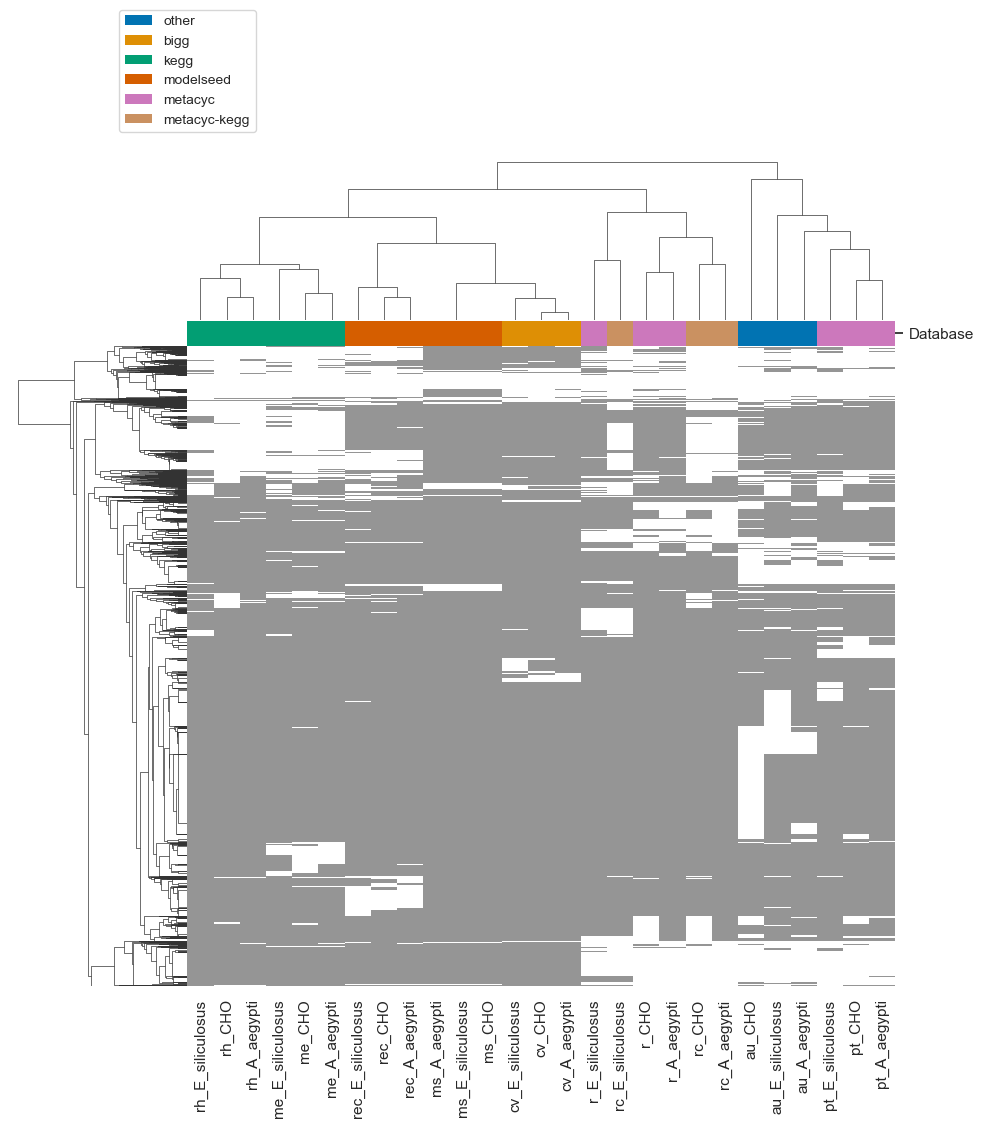

In [75]:
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
#cmap = sns.color_palette("magma_r", 2)
cmap = sns.color_palette("Greys", 1)
#cmap = sns.color_palette("Blues", 2)
#cmap = sns.color_palette('coolwarm',3)
mask = df>0
clustergrid = sns.clustermap(df,method='average', cmap=cmap, center=0, mask = mask, metric='hamming', yticklabels=False, xticklabels=True, col_colors=col_colors)
#clustergrid = sns.clustermap(df,method='average', cmap=cmap, center=0, metric='euclidean', yticklabels=False)
#clustergrid.set_xlabel("X Label",fontsize=30)
# add legends
for label in dbs_plot.unique():
    clustergrid.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0);
l1 = clustergrid.ax_col_dendrogram.legend(loc="center", ncol=1, bbox_to_anchor=(0, 1.5), fontsize=10)#, bbox_transform=gcf().transFigure)
clustergrid.cax.set_visible(False) #no colorbar
#clustergrid.savefig('pathway_tools_terminal_metabolites.pdf')
#clustergrid.savefig('pathway_tools_terminal_reactions.pdf')
#clustergrid.savefig('dendograma_preliminar4.pdf')
#clustergrid.savefig('dendograma_preliminar_noMPyr.pdf') #now with new E siliculosus Merlin
clustergrid.savefig('dendograma_preliminar_noMPyr.png', dpi=300) #now with new E siliculosus Merlin

## Compartment analysis plot

Load xlsx with Mika's data from compartments (compartment_analysis.csv)

In [84]:
file_path = 'compartment_analysis.csv'
comp_df = pd.read_csv(file_path, sep=';')

In [86]:
comp_df.index = comp_df['model']

In [91]:
comp_df = comp_df[comp_df['Organism']!= 'M_pyrifera']
comp_df = comp_df[comp_df['Organism']!= 'S_japonica']

<Axes: xlabel='model'>

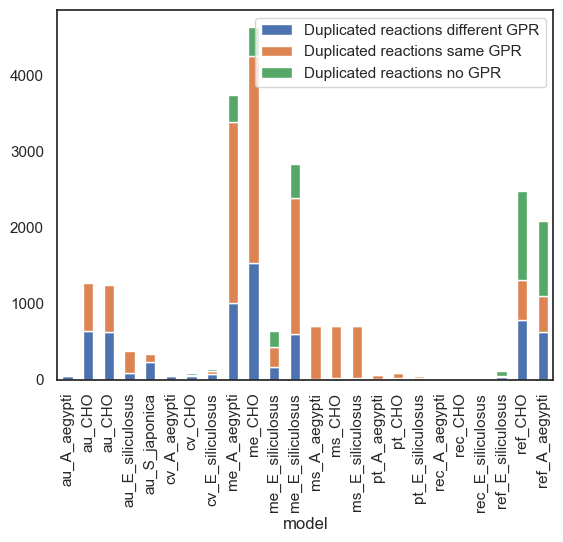

In [92]:
comp_df.plot.bar(stacked=True)


In [93]:
comp_df

'Tool/File'  \
model                                                             
au_A_aegypti                         'Aureme\Aedes_Aureme.sbml'   
au_CHO                                 'Aureme\CHO_Aureme.sbml'   
au_CHO                                  'Aureme\CHO_Recon.sbml'   
au_E_siliculosus                'Aureme\Ectocarpus_Aureme.sbml'   
au_S_japonica              'Aureme\Ecto_Saccharina_Aureme.sbml'   
cv_A_aegypti                            'CarveMe\A_aegypti.xml'   
cv_CHO                                        'CarveMe\CHO.xml'   
cv_E_siliculosus                    'CarveMe\E_siliculosus.xml'   
me_A_aegypti                  'Merlin\Aedes_merlin_support.xml'   
me_CHO                          'Merlin\CHO_Merlin_support.xml'   
me_E_siliculosus         'Merlin\Ectocarpus_merlin_support.xml'   
me_E_siliculosus       'Merlin\E_siliculosus_01_12_support.xml'   
ms_A_aegypti                         'Modelseed\A_aegypti.sbml'   
ms_CHO                                     'Modelseed\CHO.sbml'   
ms_E_siliculosus                 'Modelseed\E_siliculosus.sbml'   
pt_A_aegypti                'PWT\A_aegypti_ptools_terminal.xml'   
pt_CHO                            'PWT\CHO_ptools_terminal.xml'   
pt_E_siliculosus        'PWT\E_siliculosus_ptools_terminal.xml'   
rec_A_aegypti                    'Reconstructor\A_aegypti.sbml'   
rec_CHO                                'Reconstructor\CHO.sbml'   
rec_E_siliculosus            'Reconstructor\E_siliculosus.sbml'   
ref_E_siliculosus                                       EctoGEM   
ref_CHO                                                     CHO   
ref_A_aegypti                                         A_aegypti   

                               model           Tool       Organism  \
model                                                                
au_A_aegypti            au_A_aegypti         AuReMe      A_aegypti   
au_CHO                        au_CHO         AuReMe            CHO   
au_CHO                        au_CHO         AuReMe            CHO   
au_E_siliculosus    au_E_siliculosus         AuReMe  E_siliculosus   
au_S_japonica          au_S_japonica         AuReMe  E_siliculosus   
cv_A_aegypti            cv_A_aegypti        carveMe      A_aegypti   
cv_CHO                        cv_CHO        carveMe            CHO   
cv_E_siliculosus    cv_E_siliculosus        carveMe  E_siliculosus   
me_A_aegypti            me_A_aegypti         Merlin      A_aegypti   
me_CHO                        me_CHO         Merlin            CHO   
me_E_siliculosus    me_E_siliculosus         Merlin  E_siliculosus   
me_E_siliculosus    me_E_siliculosus         Merlin  E_siliculosus   
ms_A_aegypti            ms_A_aegypti      Modelseed      A_aegypti   
ms_CHO                        ms_CHO      Modelseed            CHO   
ms_E_siliculosus    ms_E_siliculosus      Modelseed  E_siliculosus   
pt_A_aegypti            pt_A_aegypti  Pathway tools      A_aegypti   
pt_CHO                        pt_CHO  Pathway tools            CHO   
pt_E_siliculosus    pt_E_siliculosus  Pathway tools  E_siliculosus   
rec_A_aegypti          rec_A_aegypti  Reconstructor      A_aegypti   
rec_CHO                      rec_CHO  Reconstructor            CHO   
rec_E_siliculosus  rec_E_siliculosus  Reconstructor  E_siliculosus   
ref_E_siliculosus  ref_E_siliculosus      Reference  E_siliculosus   
ref_CHO                      ref_CHO      Reference            CHO   
ref_A_aegypti          ref_A_aegypti      Reference      A_aegypti   

                   Duplicated reactions different GPR  \
model                                                   
au_A_aegypti                                       46   
au_CHO                                            637   
au_CHO                                            631   
au_E_siliculosus                                   87   
au_S_japonica                                     229   
cv_A_aegypti                                       41   
cv_CHO                          

In [96]:
#cv, pt, rec and ref / delete aureme, merlin, modelseed

plot_df = comp_df[comp_df['Tool']!= 'AuReMe']
plot_df = plot_df[plot_df['Tool']!= 'Merlin']
plot_df = plot_df[plot_df['Tool']!= 'Modelseed']
plot_df = plot_df[plot_df['model']!= 'ref_CHO']
plot_df = plot_df[plot_df['model']!= 'ref_A_aegypti']

<Axes: xlabel='model'>

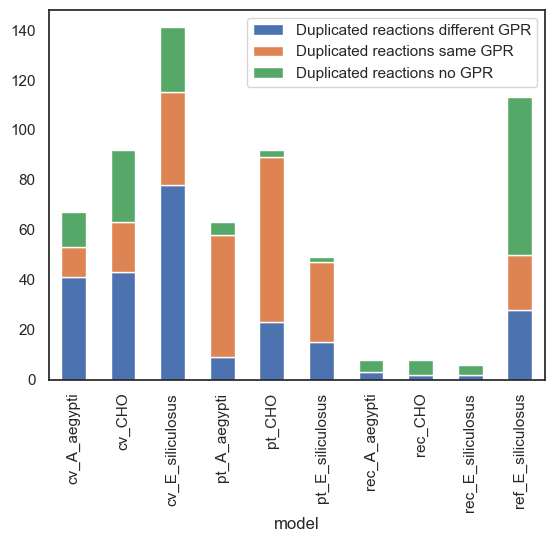

In [97]:
plot_df.plot.bar(stacked=True)

## PCA and other juice

In [51]:
df_trans = df.transpose()

In [125]:
#Add column category
#db_dict_plot = {'bigg': 0, 'kegg': 1, 'metacyc': 2, 'metacyc-kegg': 3, 'modelseed': 4, 'other': 5} 
db_dict_plot = {'kegg': 1, 'metacyc': 2, 'metacyc-kegg': 3, 'modelseed': 4, 'other': 5} 
df_trans['Database'] = [db_dict_plot[dbs_plot[model]] for model in df_trans.index]
#reorganize dataframe based on this value
df_trans = df_trans.sort_values(by=['Database'])
#pop column and keep it as separate for PCA
df_trans_db = df_trans.pop('Database').to_numpy()

In [127]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [128]:
scaler = StandardScaler()
 
scaler.fit(df_trans)
 
df_scaled = scaler.transform(df_trans)

In [132]:
pca = PCA(n_components=2)
 
pca.fit(df_scaled)
 
pca_df= pca.transform(df_scaled)

In [133]:
PC1 = pca_df[:,0]
PC2 = pca_df[:,1]

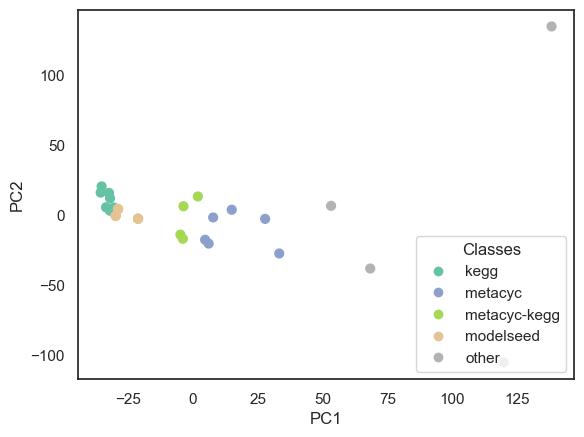

In [135]:
_, ax = plt.subplots()
scatter = ax.scatter(
    PC1,
    PC2,
    c=df_trans_db,
    s=40,
    cmap='Set2',
)
ax.set(xlabel='PC1', ylabel='PC2')
_ = ax.legend(
    scatter.legend_elements()[0], db_dict_plot.keys(), loc="lower right", title="Classes"
)

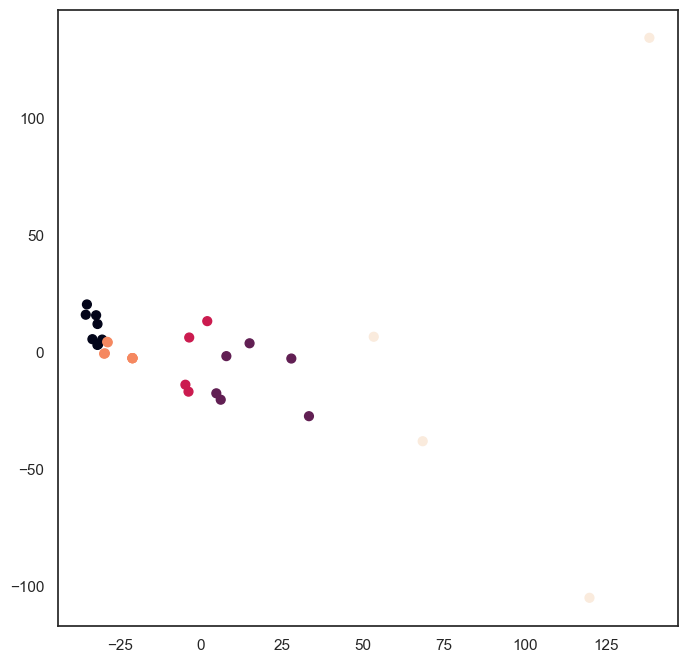

In [80]:
plt.figure(figsize=(8, 8))
plt.scatter(
    PC1,
    PC2,
    c=cat_plot,
    s=40,
)

[Text(-60.0, 0, ''),
 Text(-40.0, 0, ''),
 Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, '')]

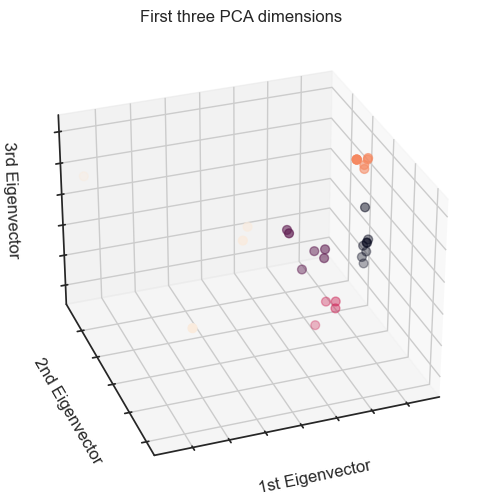

In [78]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

ax.scatter(
    PC1,
    PC2,
    PC3,
    c=cat_plot,
    s=40,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd Eigenvector")
ax.zaxis.set_ticklabels([])


In [36]:
labels=[]
 
for points in b_cancer.target:
    labels.append(b_cancer.target_names[points])
zipped = list(zip(PC1, 
                  PC2, 
                  b_cancer.target,
                  labels))
 
pc_df = pd.DataFrame(zipped, 
                     columns=['PC1', 
                              'PC2', 
                              'Target',
                              'Label'])
 
pc_df.head(6)


NameError: name 'b_cancer' is not defined

In [29]:
# Authors: Kyle Kastner
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA

iris = load_iris()
X = iris.data
y = iris.target

In [34]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [30]:
#df = pd.DataFrame.from_dict(df_dict).fillna(0)#.transpose()

In [31]:
n_components = 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(df)

In [32]:
X_pca

array([[-0.73513987, -0.7538897 ],
       [ 3.22196349,  0.5559808 ],
       [ 3.91233203, -0.23834151],
       ...,
       [-1.09163195,  0.12842206],
       [-1.09163195,  0.12842206],
       [-1.09163195,  0.12842206]])

ValueError: operands could not be broadcast together with shapes (8865,2) (150,2) 

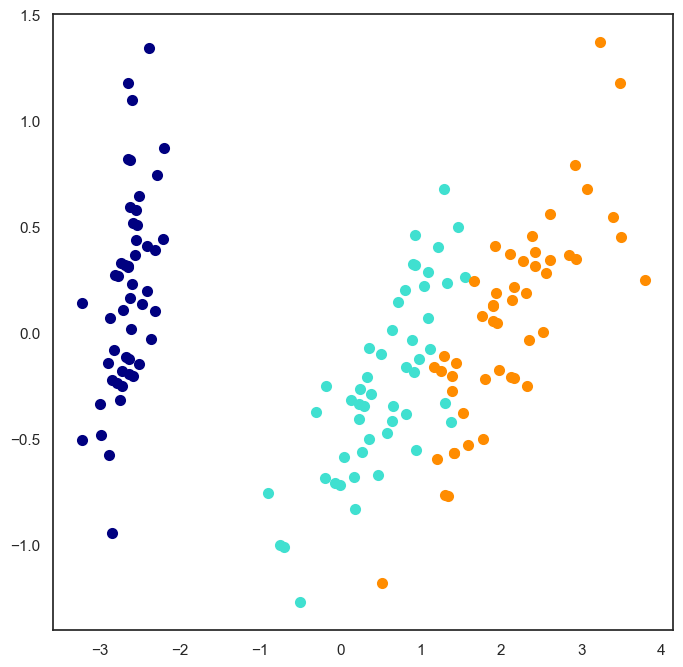

In [33]:
colors = ["navy", "turquoise", "darkorange"]

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(
            X_transformed[y == i, 0],
            X_transformed[y == i, 1],
            color=color,
            lw=2,
            label=target_name,
        )

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error %.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

In [98]:
type(iris)

sklearn.utils._bunch.Bunch

In [103]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

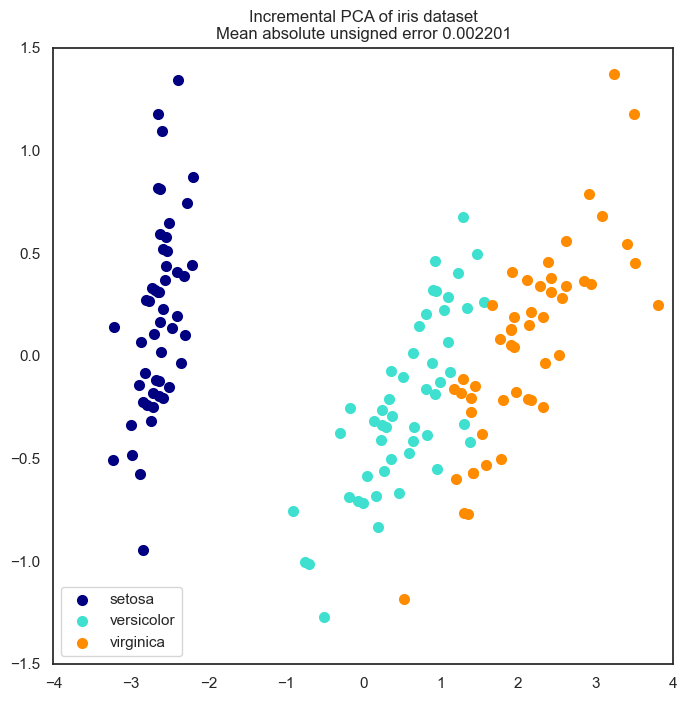

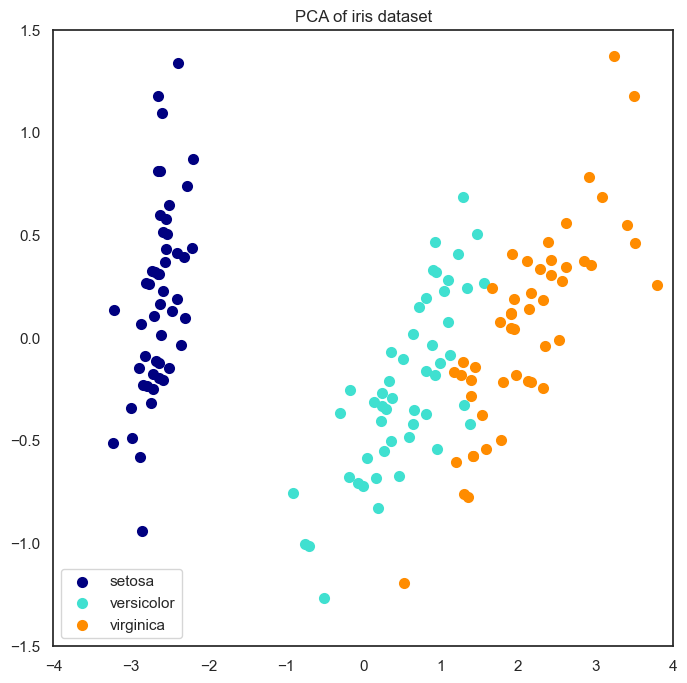

In [24]:
# Authors: Kyle Kastner
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, IncrementalPCA

iris = load_iris()
X = iris.data
y = iris.target

n_components = 2
ipca = IncrementalPCA(n_components=n_components, batch_size=10)
X_ipca = ipca.fit_transform(X)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

colors = ["navy", "turquoise", "darkorange"]

for X_transformed, title in [(X_ipca, "Incremental PCA"), (X_pca, "PCA")]:
    plt.figure(figsize=(8, 8))
    for color, i, target_name in zip(colors, [0, 1, 2], iris.target_names):
        plt.scatter(
            X_transformed[y == i, 0],
            X_transformed[y == i, 1],
            color=color,
            lw=2,
            label=target_name,
        )

    if "Incremental" in title:
        err = np.abs(np.abs(X_pca) - np.abs(X_ipca)).mean()
        plt.title(title + " of iris dataset\nMean absolute unsigned error %.6f" % err)
    else:
        plt.title(title + " of iris dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.axis([-4, 4, -1.5, 1.5])

plt.show()

In [ ]:
import cobra

model = cobra.io.read_sbml_model('./to_plot/'+folder+'/'+org) 

In [43]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  